# Setup

**Information about the different models which might be useful when writing the paper**
C-RADIOv2 models are available in multiple sizes: Base (90M parameters). Huge (653M parameters). C-RADIOv2 was trained for 1M steps (400k more steps than v1), using inverse frequency sampling for data balancing, and PHI Standardization for teacher distribution balancing. 

Model Architecture
Architecture Type: Neural Network
Network Architecture: Vision Transformer

c-radio-h	ViT-H/16-CPE https://github.com/NVlabs/RADIO

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import os
from pathlib import Path

In [56]:
PATH = "../results/results_exp_a_500_sharding_batch4_workers8_dataparallel_memory1024000.csv"
MEMORY = 1024000
ORIGINAL_DF = pd.read_csv(PATH)
DF = ORIGINAL_DF.copy()

In [57]:
# MODELS = {
#     "clip-vit-base-patch16": "CLIP ViT-B/16",
#     "dino_vitb16": "DINO ViT-B/16",
#     "dinov2_vitb14": "DINOv2 ViT-B/14",
#     "dinov3-vitb16-pretrain-lvd1689m": "DINOv3 ViT-B/16",
#     "C-RADIOv2-B": "C-RADIOv2 ViT-B/16-CPE",
#     "siglip2-base-patch16-512": "SigLIP B/16-512",
#     "tips-b14": "TIPS ViT-B/14-HR", # (448)
#     "vggt-1b": "VGGT-1B",
# }
MODELS = {
    "clip-vit-base-patch16": "CLIP",
    "dino_vitb16": "DINO",
    "dinov2_vitb14": "DINOv2",
    "dinov3-vitb16-pretrain-lvd1689m": "DINOv3",
    "C-RADIOv2-B": "C-RADIOv2",
    "siglip2-base-patch16-512": "SigLIP2",
    "tips-b14": "TIPS", # (448)
    "vggt-1b": "VGGT",
}
PREFIXES = {
    "clip-vit-base-patch16": "clip",
    "dino_vitb16": "dino",
    "dinov2_vitb14": "dinov2",
    "dinov3-vitb16-pretrain-lvd1689m": "dinov3",
    "C-RADIOv2-B": "radio",
    "siglip2-base-patch16-512": "siglip2",
    "tips-b14":"tips",
    "vggt-1b": "vggt",
}
COLORS = {
    "clip-vit-base-patch16": "#1f77b4",
    "dino_vitb16": "#ff7f0e",
    "dinov2_vitb14": "#2ca02c",
    "dinov3-vitb16-pretrain-lvd1689m": "#17becf",
    "C-RADIOv2-B": "#d62728",
    "siglip2-base-patch16-512": "#9467bd",
    "tips-b14": "#8c564b",
    "vggt-1b": "#e377c2",
}
TRAIN_BINS_DIFFICULTY = {
    "0_30_60_90": "easy",
    "0_45_90": "medium",
    "0_90": "hard",
    "0": "extreme"
}
XTICKS = [0, 15, 30, 45, 60, 75, 90]
CLASS_TO_INDEX = {
    0: 0,
    7: 1,
    8: 2,
    19: 3,
    46: 4,
    57: 5,
    60: 6,
    70: 7,
    99: 8,
    100: 9,
    113: 10,
    125: 11,
    126: 12,
    152: 13,
    166: 14,
    196: 15,
}
CLASS_TO_NAME = {
    0: "background",
    7: "stove",
    8: "sofa",
    19: "microwave",
    46: "bed",
    57: "toy cat",
    60: "toy cow",
    70: "toy dragon",
    99: "coat rack",
    100: "guitar stand",
    113: "ceiling lamp",
    125: "toilet",
    126: "sink",
    152: "strings",
    166: "broccoli",
    196: "durian"
}


# Experiment A

In [31]:
DF.head()

job_id                  model  train_bins  val_bin  jac_mean  jac_std  \
0  12081378  clip-vit-base-patch16  0_30_60_90        0     0.784    0.117   
1  12081378  clip-vit-base-patch16  0_30_60_90       15     0.764    0.136   
2  12081378  clip-vit-base-patch16  0_30_60_90       30     0.793    0.111   
3  12081378  clip-vit-base-patch16  0_30_60_90       45     0.775    0.126   
4  12081378  clip-vit-base-patch16  0_30_60_90       60     0.796    0.108   

    jac0   jac1   jac2   jac3   jac4   jac5   jac6   jac7   jac8   jac9  \
0  0.971  0.848  0.861  0.792  0.592  0.809  0.784  0.749  0.563  0.605   
1  0.970  0.857  0.850  0.792  0.579  0.789  0.759  0.728  0.503  0.560   
2  0.973  0.877  0.872  0.820  0.650  0.795  0.774  0.738  0.606  0.587   
3  0.972  0.862  0.847  0.806  0.576  0.787  0.770  0.743  0.559  0.548   
4  0.974  0.865  0.872  0.822  0.684  0.800  0.784  0.761  0.578  0.600   

   jac10  jac11  jac12  jac13  jac14  jac15  d_model  batch_size  input_size  \
0  0.756  0.876  0.674  0.883  0.872  0.905      768           4         512   
1  0.737  0.885  0.578  0.886  0.859  0.898      768           4         512   
2  0.746  0.896  0.696  0.894  0.861  0.903      768           4         512   
3  0.737  0.881  0.656  0.888  0.863  0.906      768           4         512   
4  0.755  0.879  0.704  0.882  0.870  0.908      768           4         512   

   patch_size  
0          16  
1          16  
2          16  
3          16  
4          16

In [32]:
DF_A = DF.copy()

def plot_exp_a(classes: None | list[int], include_bg: bool, extratitle: str, save_path: str | None = None):
    """
    Plot experiment A result as grouped bar histograms per class and model.
    """
    assert type(classes) in [list, type(None)], "classes must be a list or None"

    if classes is None:
        classes = list(CLASS_TO_INDEX.keys())
    else:
        assert all(c in CLASS_TO_INDEX for c in classes), "classes must be a subset of CLASS_TO_INDEX keys"

    if not include_bg:
        classes = [c for c in classes if c != 0]

    class_indices = [CLASS_TO_INDEX[c] for c in classes]

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), dpi=200)
    axes = axes.flatten()

    bar_width = 0.1
    for i, (train_bins, difficulty) in enumerate(TRAIN_BINS_DIFFICULTY.items()):
        ax = axes[i]
        train_bins_set = set(map(int, train_bins.split("_")))
        bin_vals = sorted(set(DF_A["val_bin"]))

        x_pos = np.arange(len(bin_vals))  # One group per val_bin
        total_models = len(MODELS)

        for model_idx, (model, model_label) in enumerate(MODELS.items()):
            df = DF_A[(DF_A["model"] == model) & (DF_A["train_bins"] == train_bins)].sort_values("val_bin")
            if df.empty:
                print(f"No data for model {model} with train_bins {train_bins} and classes {classes}")
                continue

            # Offset x for grouped bars
            offset = (model_idx - total_models / 2) * bar_width + bar_width / 2
            x_offset = x_pos + offset

            means = df[[f"jac{c}" for c in class_indices]].mean(axis=1).values

            if i == 0:
                means[0] = 0
                means[2] = 0
                means[4] = 0
                means[6] = 0
            elif i == 1:
                means[0] = 0
                means[3] = 0
                means[6] = 0
            elif i == 2:
                means[0] = 0
                means[6] = 0
            elif i == 3:
                means[0] = 0

            ax.bar(x_offset, means, width=bar_width, label=model_label,
                   color=COLORS[model], capsize=4, zorder=2)

            means = df[[f"jac{c}" for c in class_indices]].mean(axis=1).values
            if i == 0:
                means[1] = 0
                means[3] = 0
                means[5] = 0
            elif i == 1:
                means[1] = 0
                means[2] = 0
                means[4] = 0
                means[5] = 0
            elif i == 2:
                means[1] = 0
                means[2] = 0
                means[3] = 0
                means[4] = 0
                means[5] = 0
            elif i == 3:
                means[6] = 0
                means[1] = 0
                means[2] = 0
                means[3] = 0
                means[4] = 0
                means[5] = 0
            ax.scatter(x_offset, means, marker='.', color=COLORS[model], s=50, zorder=3)

        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(b) for b in bin_vals])
        ax.set_ylim(0, 1)
        ax.set_title(f"({string.ascii_letters[i]}) Train bin(s): {', '.join(train_bins.split('_'))} ({difficulty})")
        ax.set_xlabel("Validation Bin")
        ax.set_ylabel("mIoU")
        ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

    axes[0].legend(loc="lower left", bbox_to_anchor=(0, 0))
    plt.suptitle(f"Experiment A Results — {extratitle}", fontsize=25, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])


    # Save figure
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    plt.close()


## Plots

Saved figure to ../images/figures/All_Classes_No_BG.png


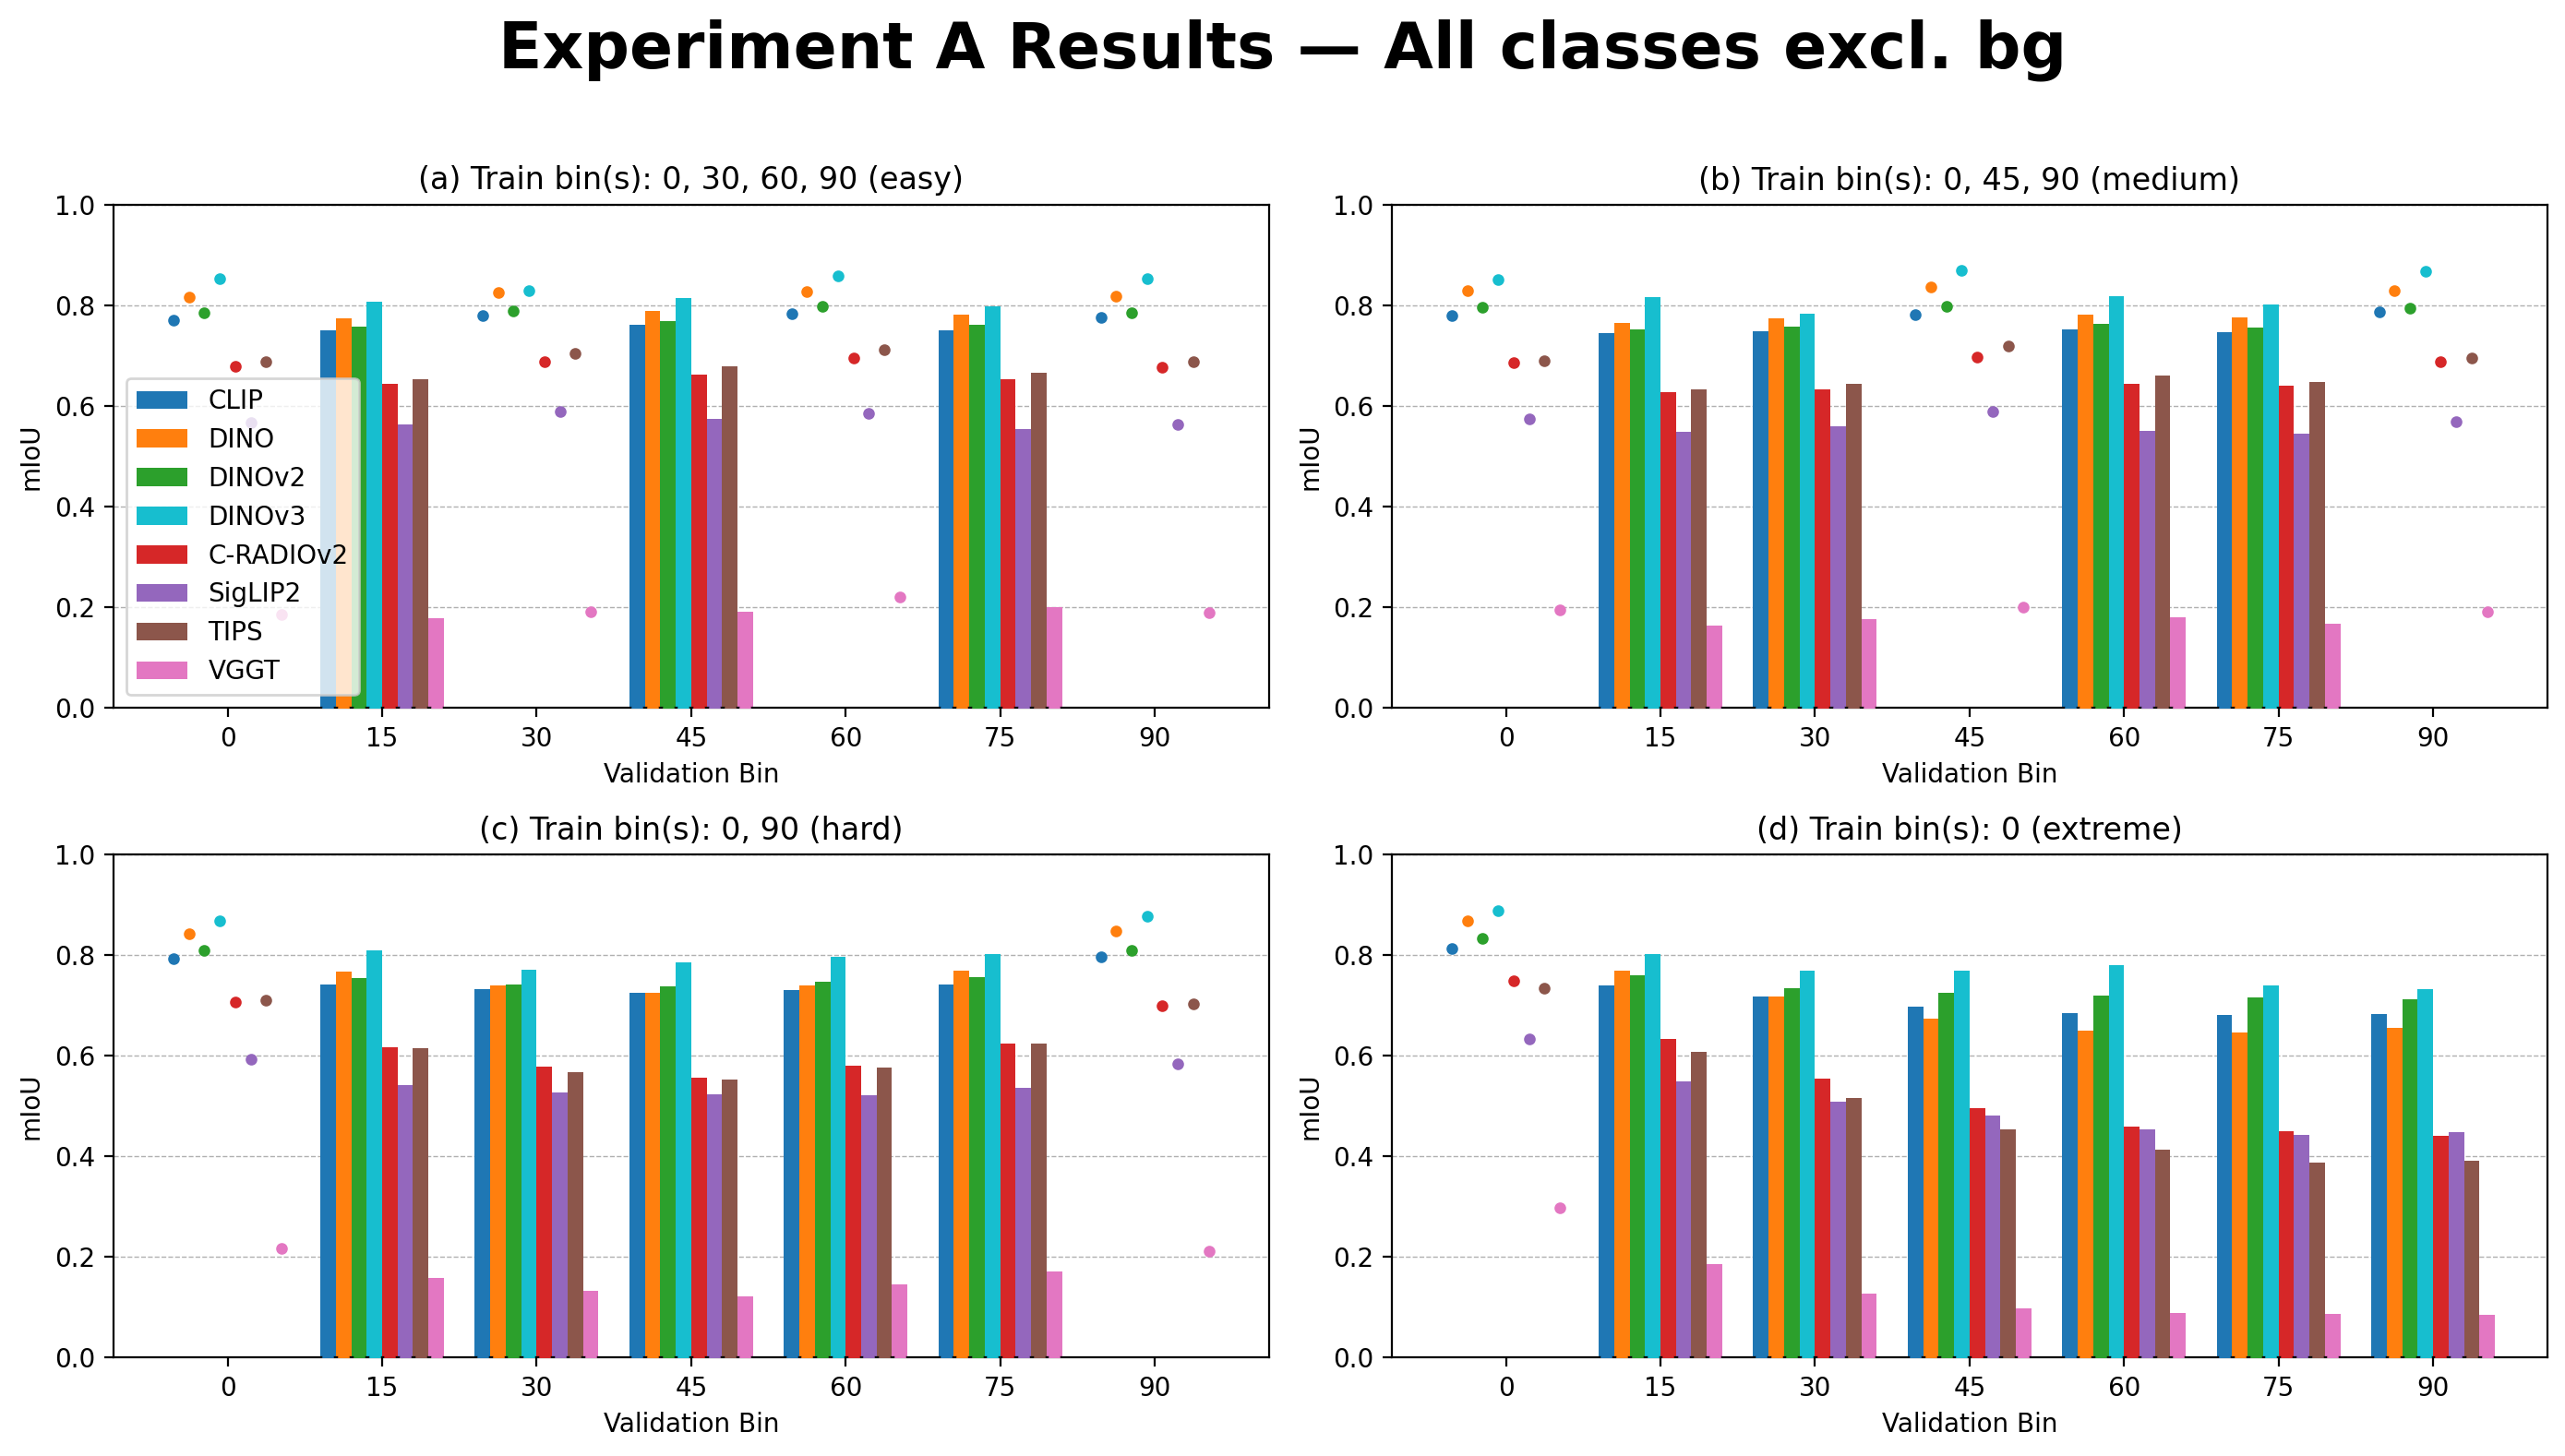

Saved figure to ../images/figures/All_Classes.png


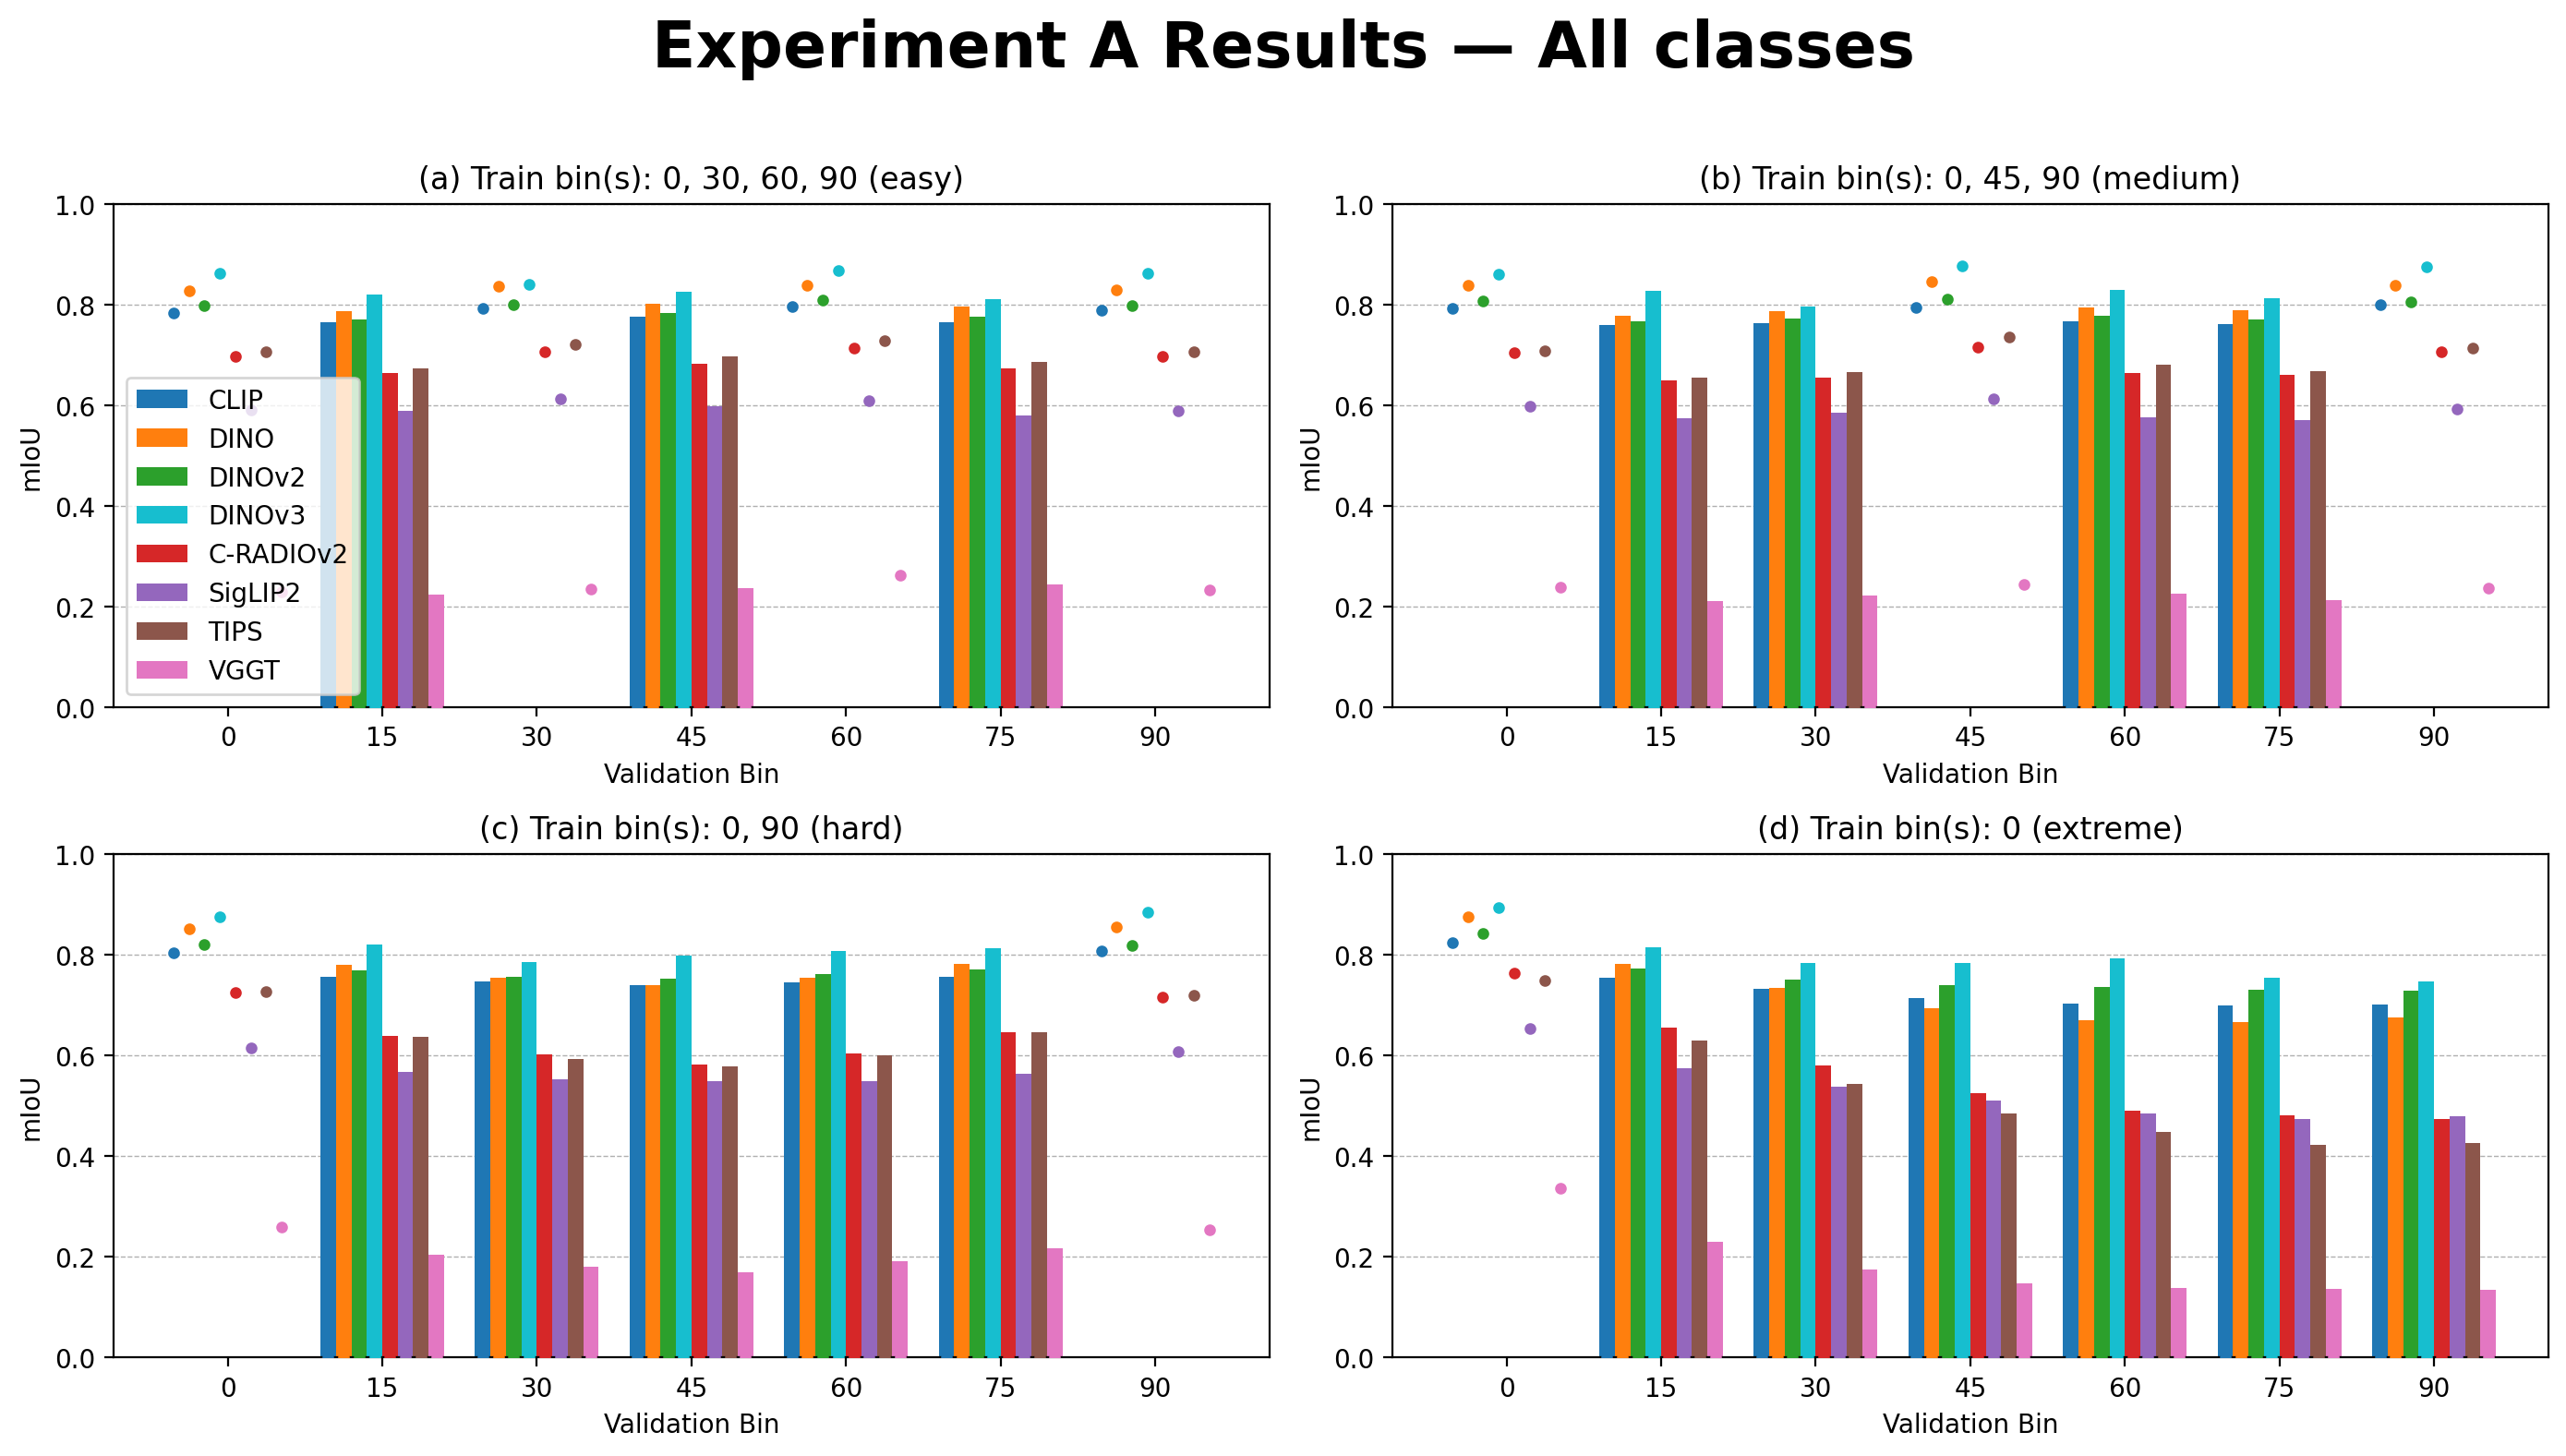

In [33]:
# Experiment A (Grouped Bar Histograms)
os.makedirs("../images/figures", exist_ok=True)

# Plot all classes
plot_exp_a(None, False, extratitle="All classes excl. bg", save_path="../images/figures/All_Classes_No_BG.png")
plot_exp_a(None, True, extratitle="All classes", save_path="../images/figures/All_Classes.png")

Saved figure to ../images/figures/0_background.png


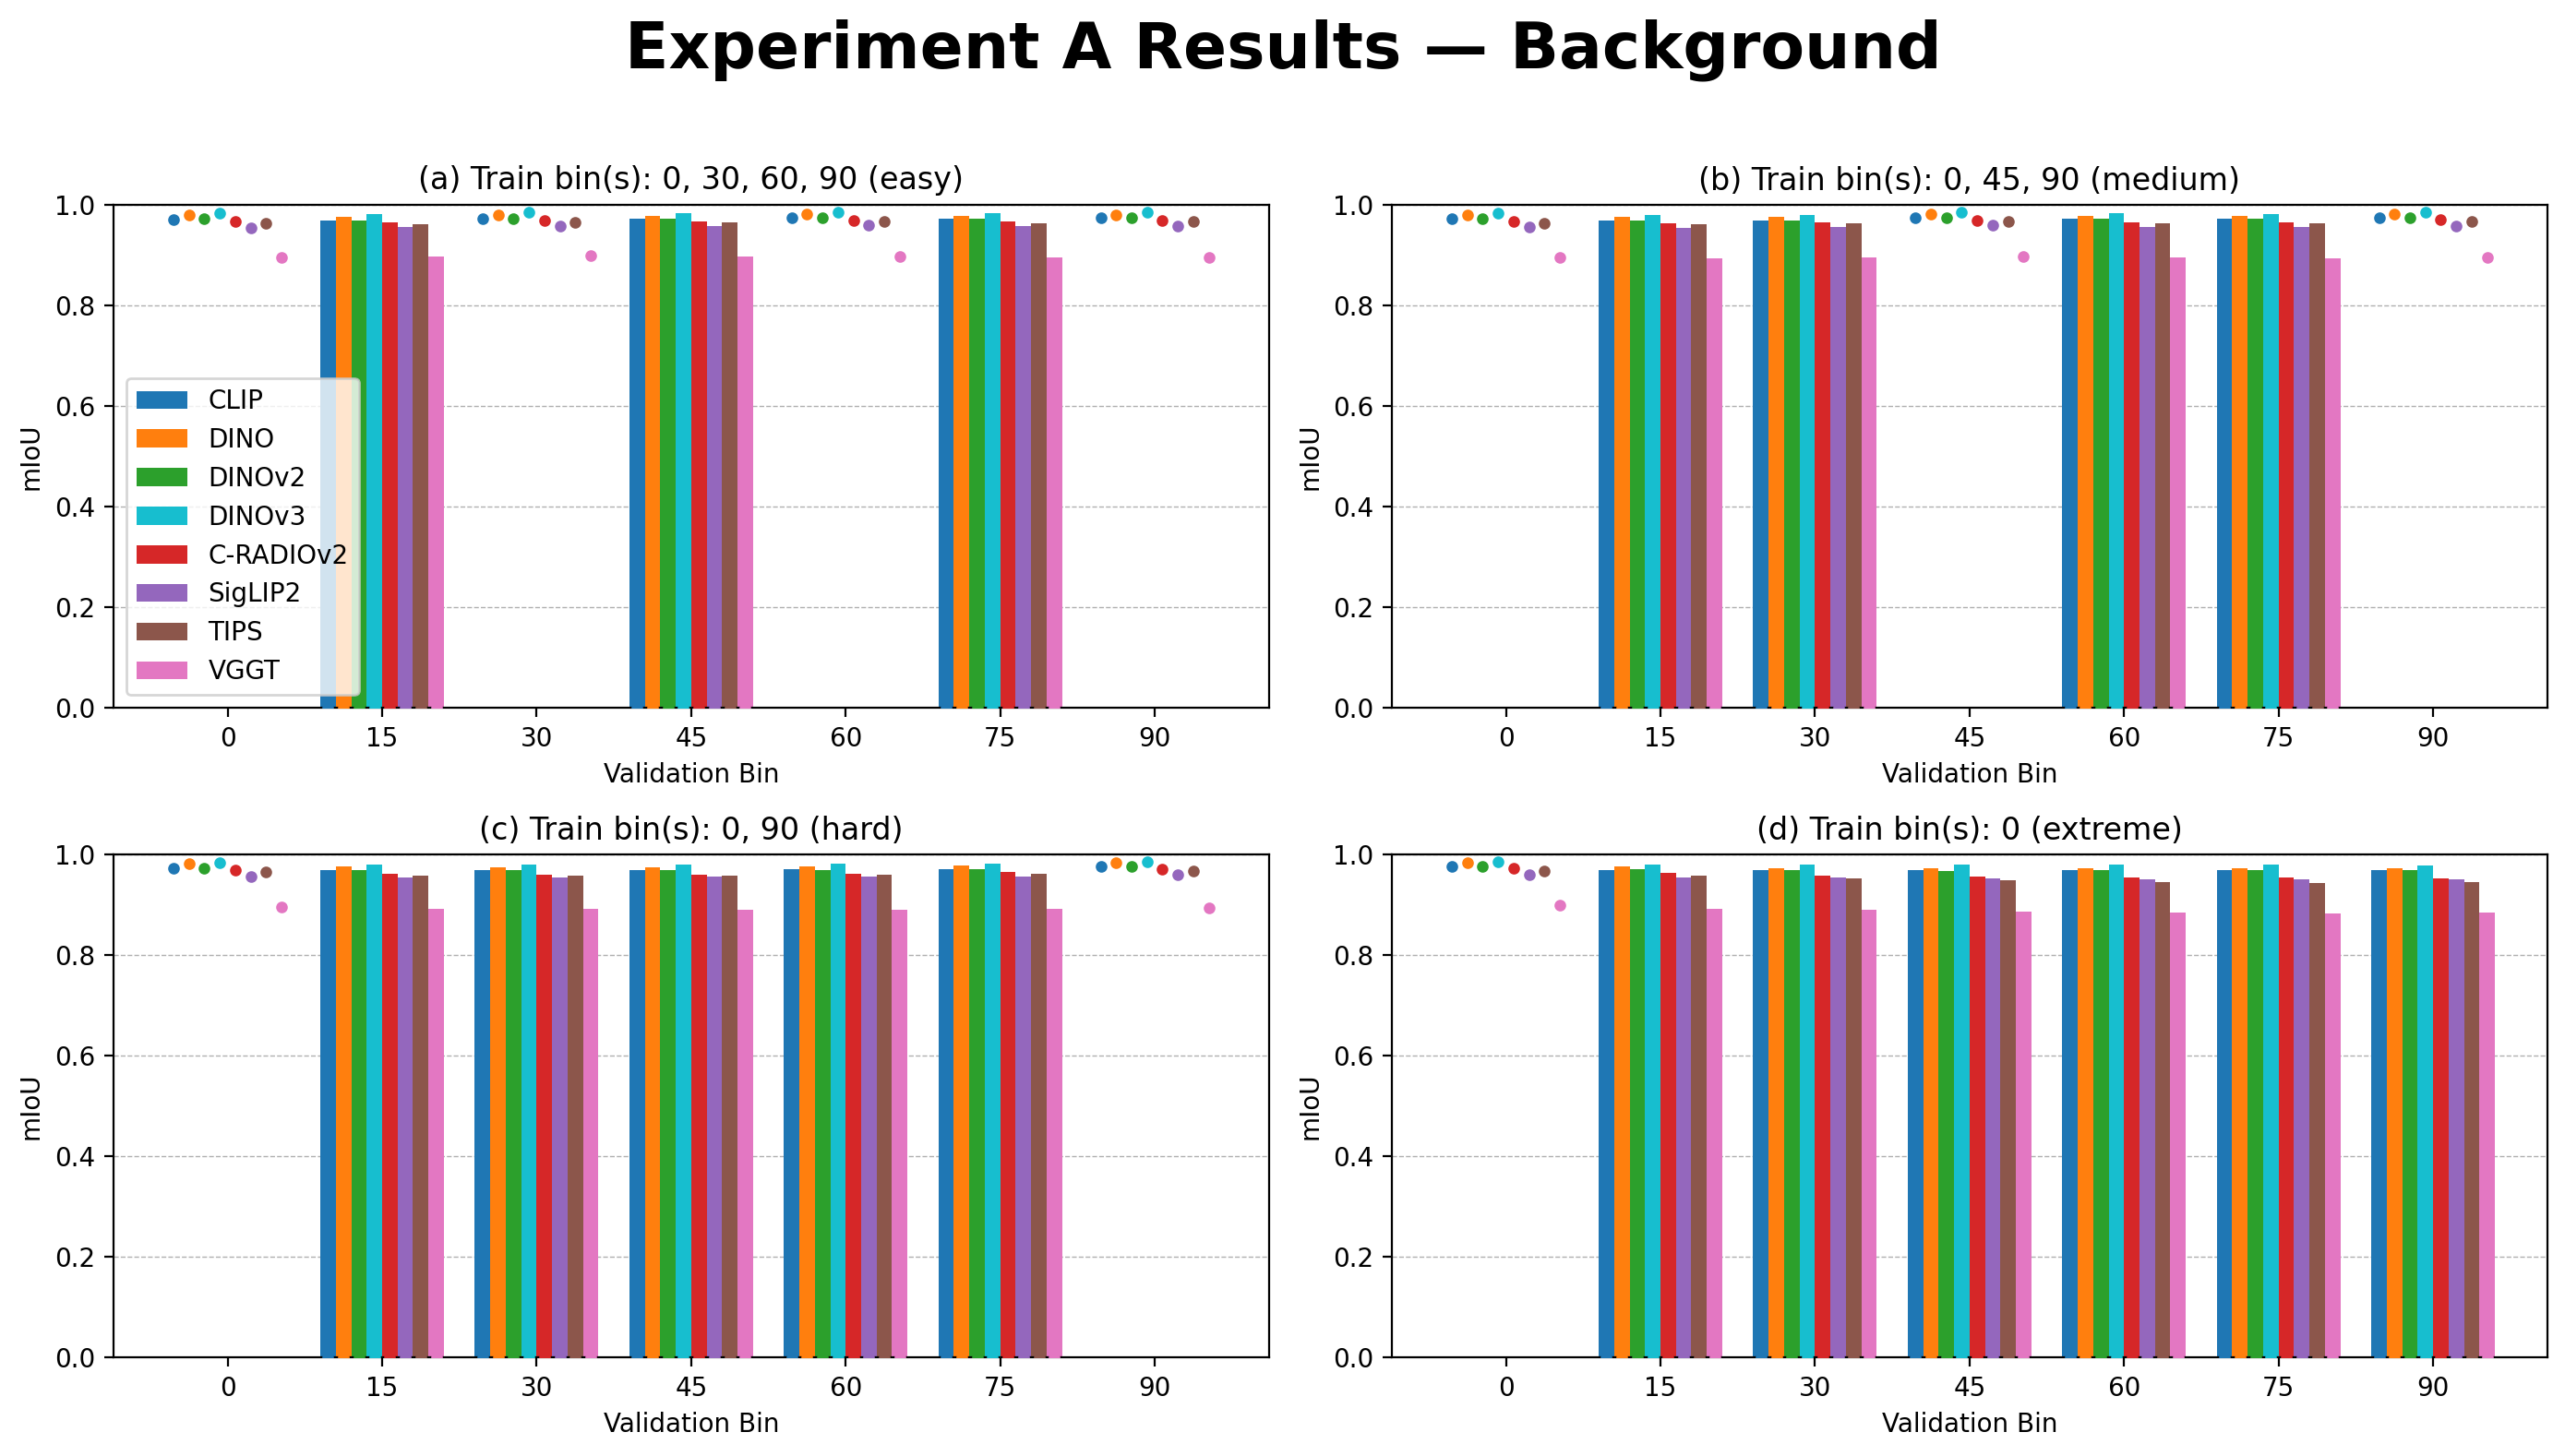

Saved figure to ../images/figures/1_stove.png


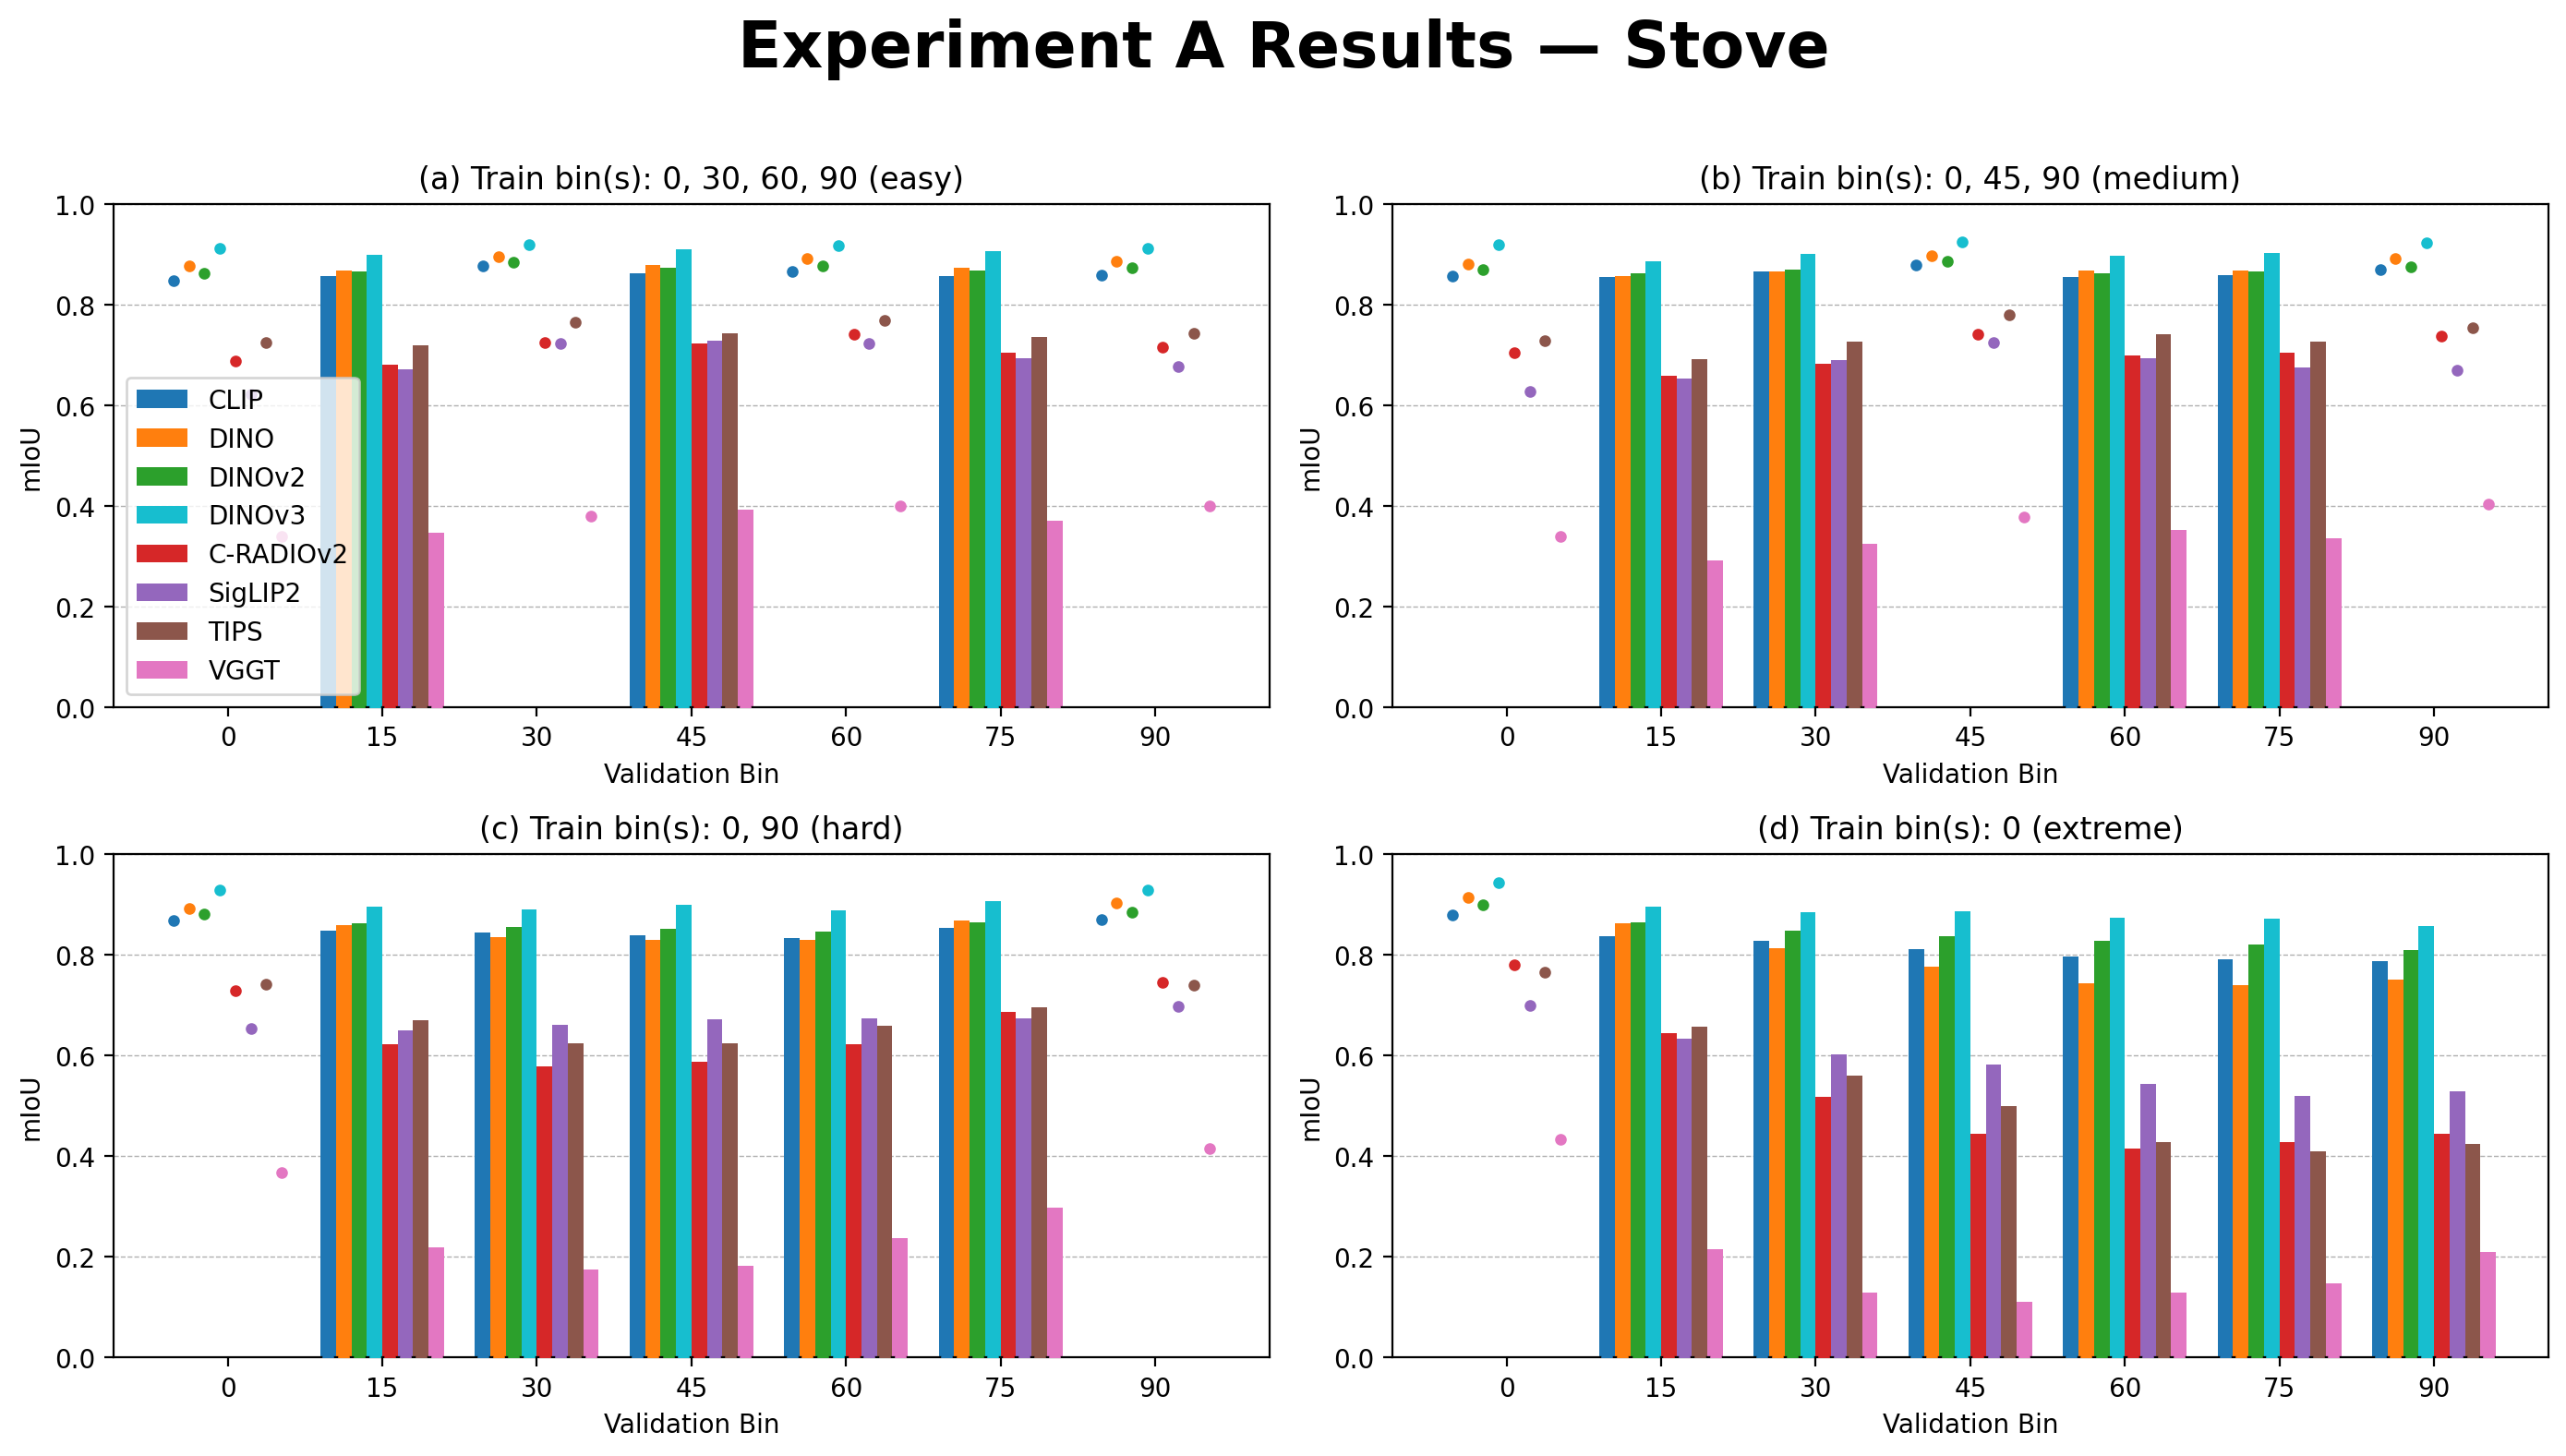

Saved figure to ../images/figures/2_sofa.png


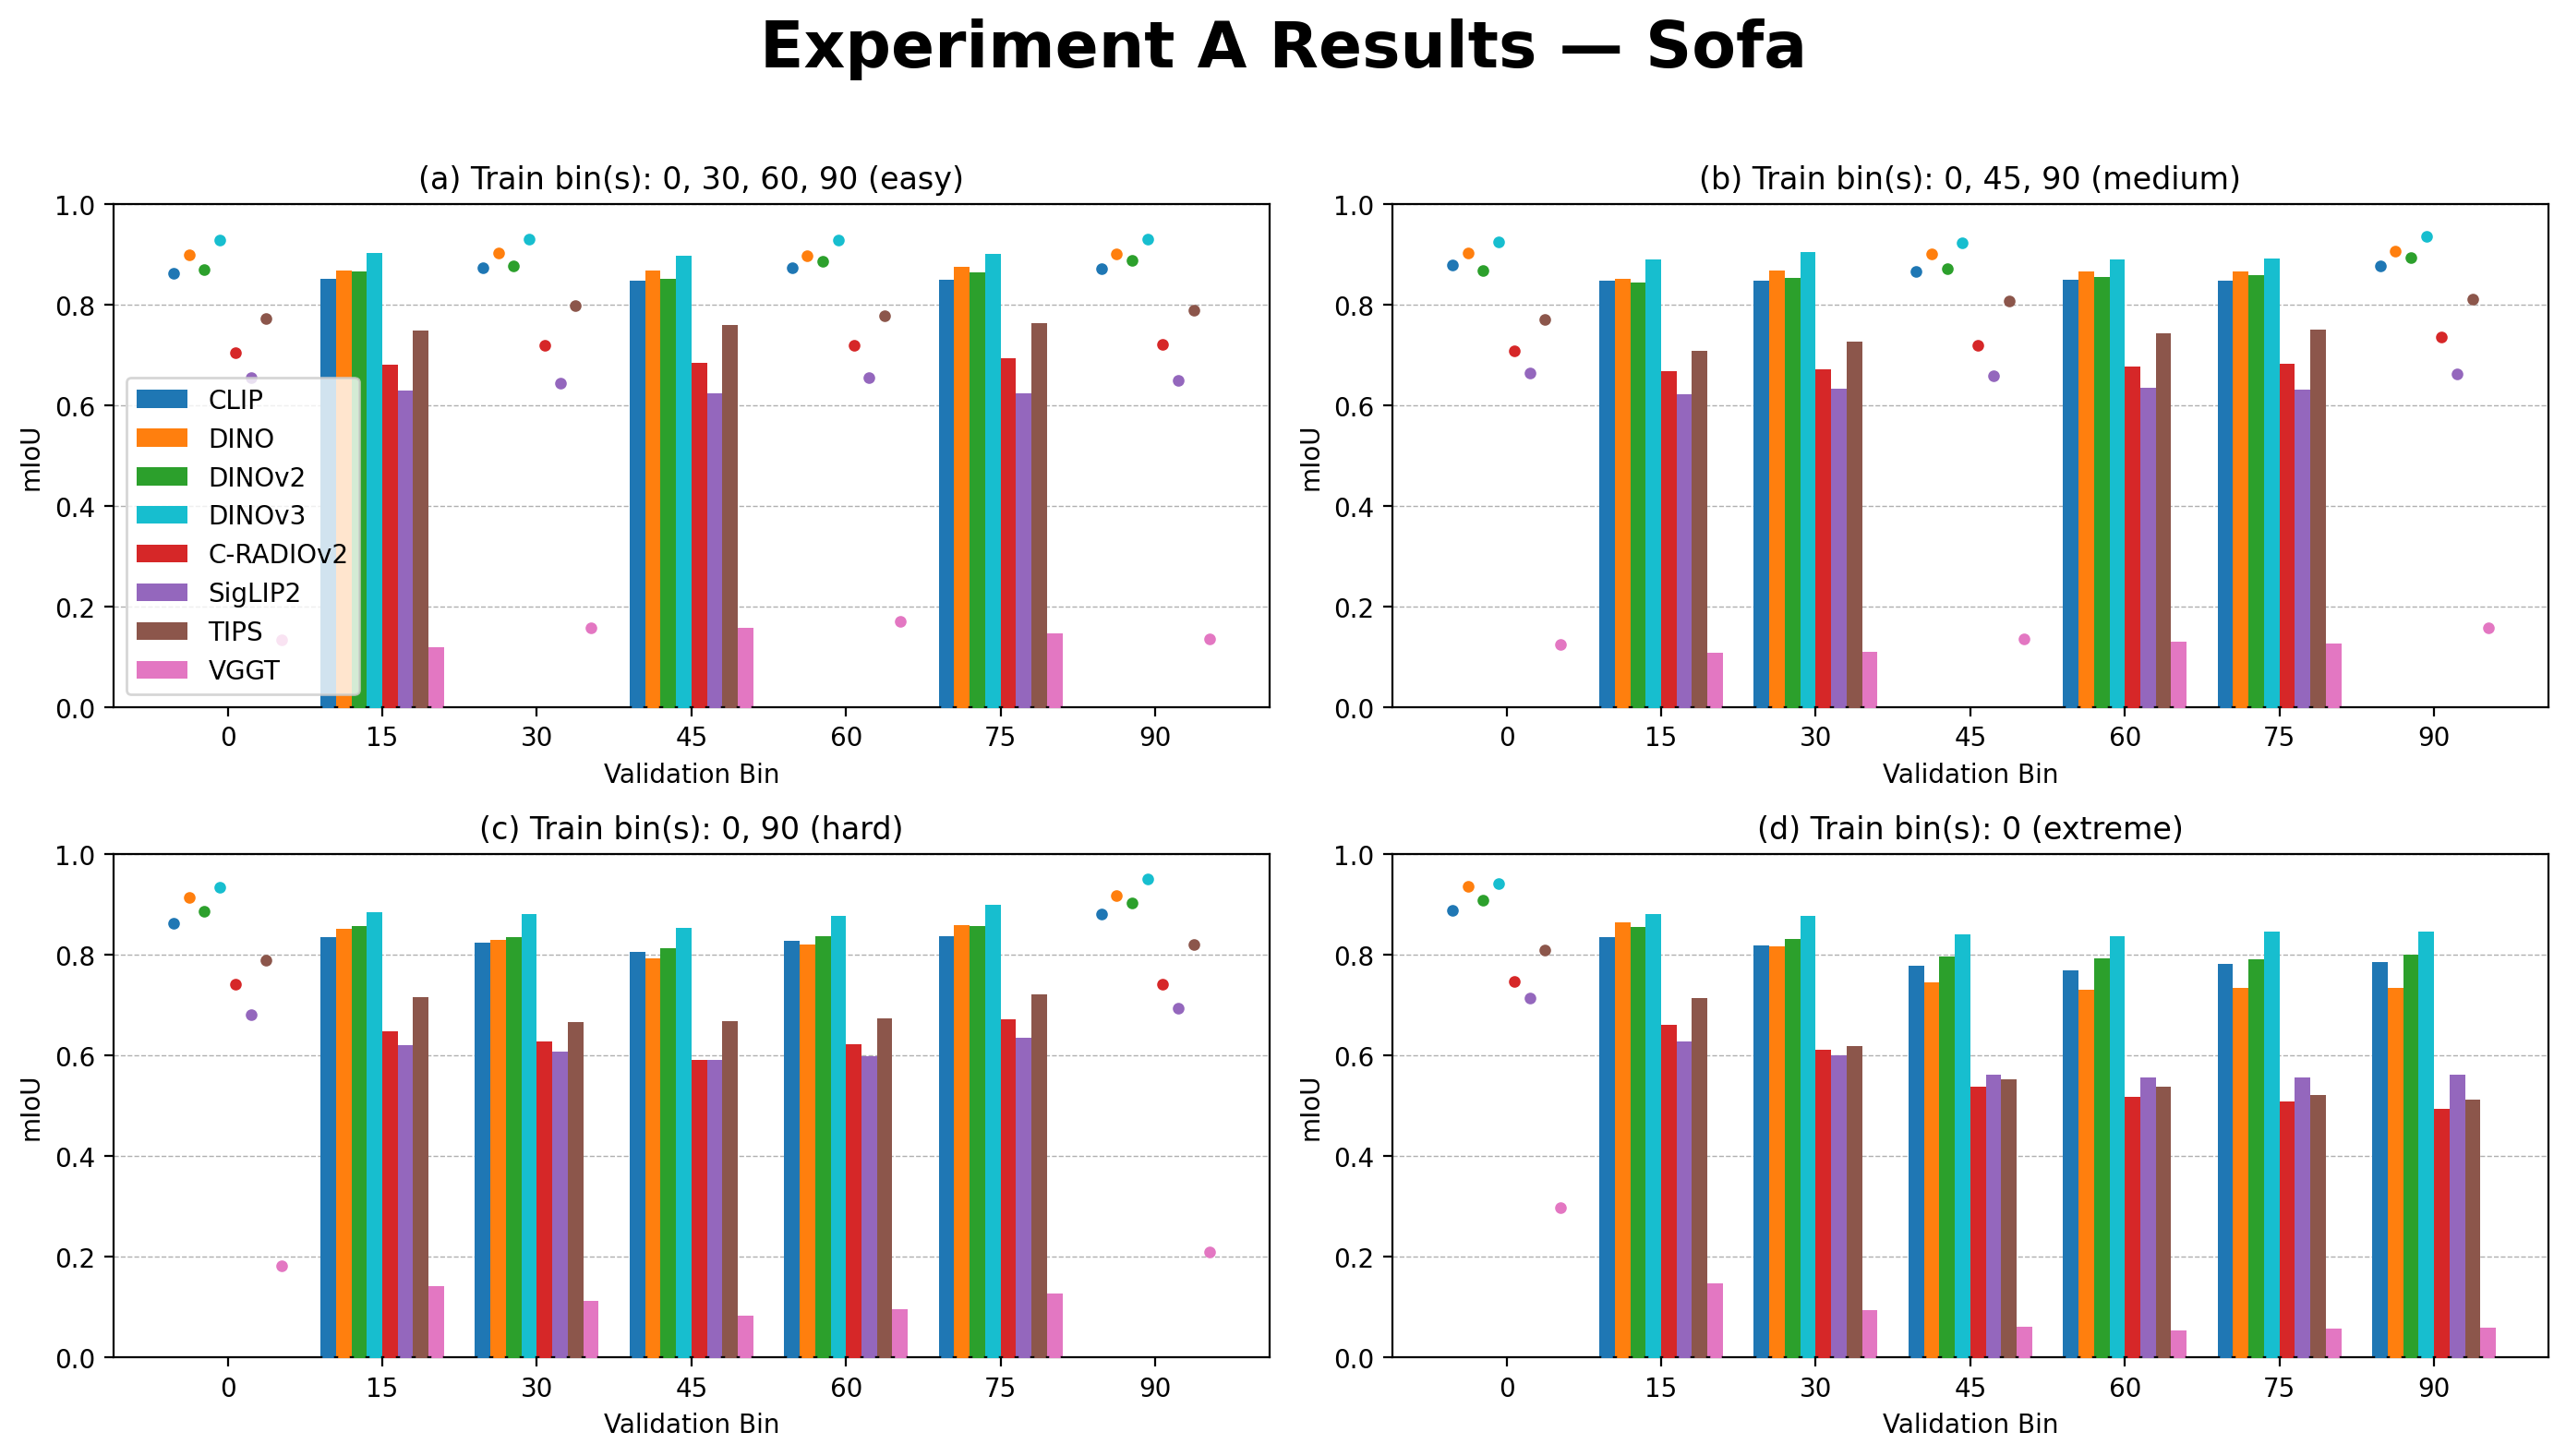

Saved figure to ../images/figures/3_microwave.png


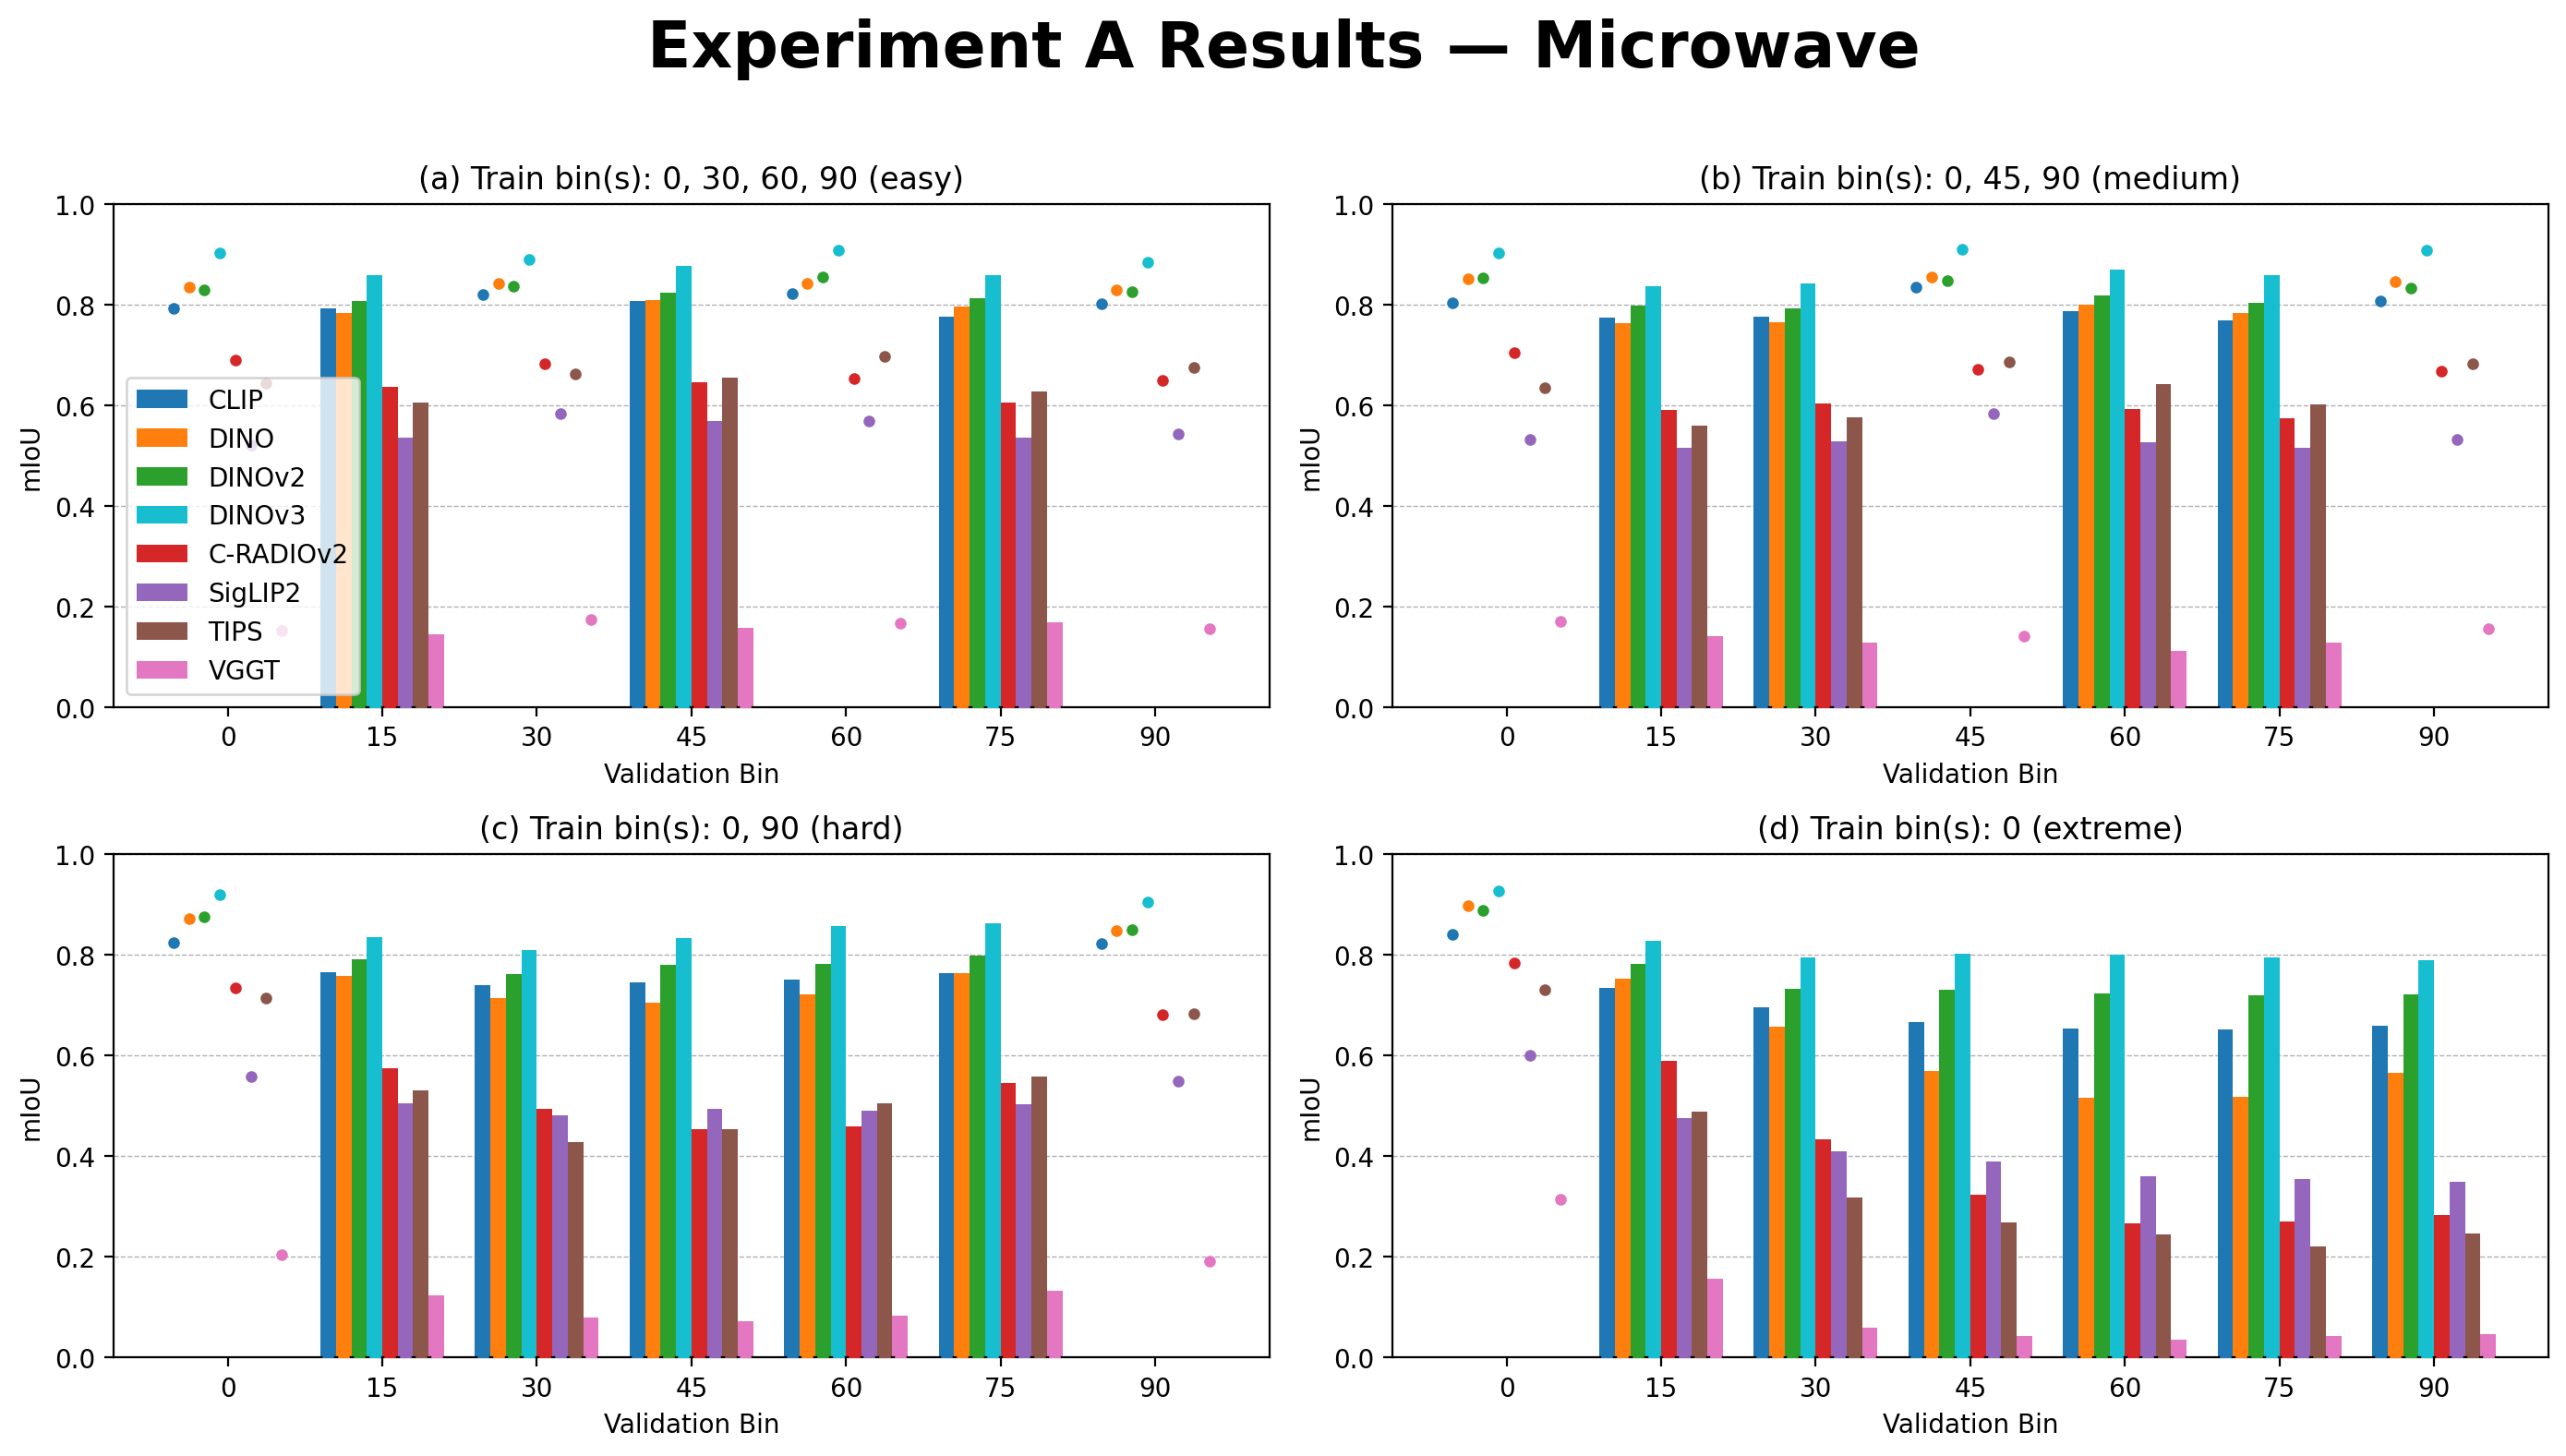

Saved figure to ../images/figures/4_bed.png


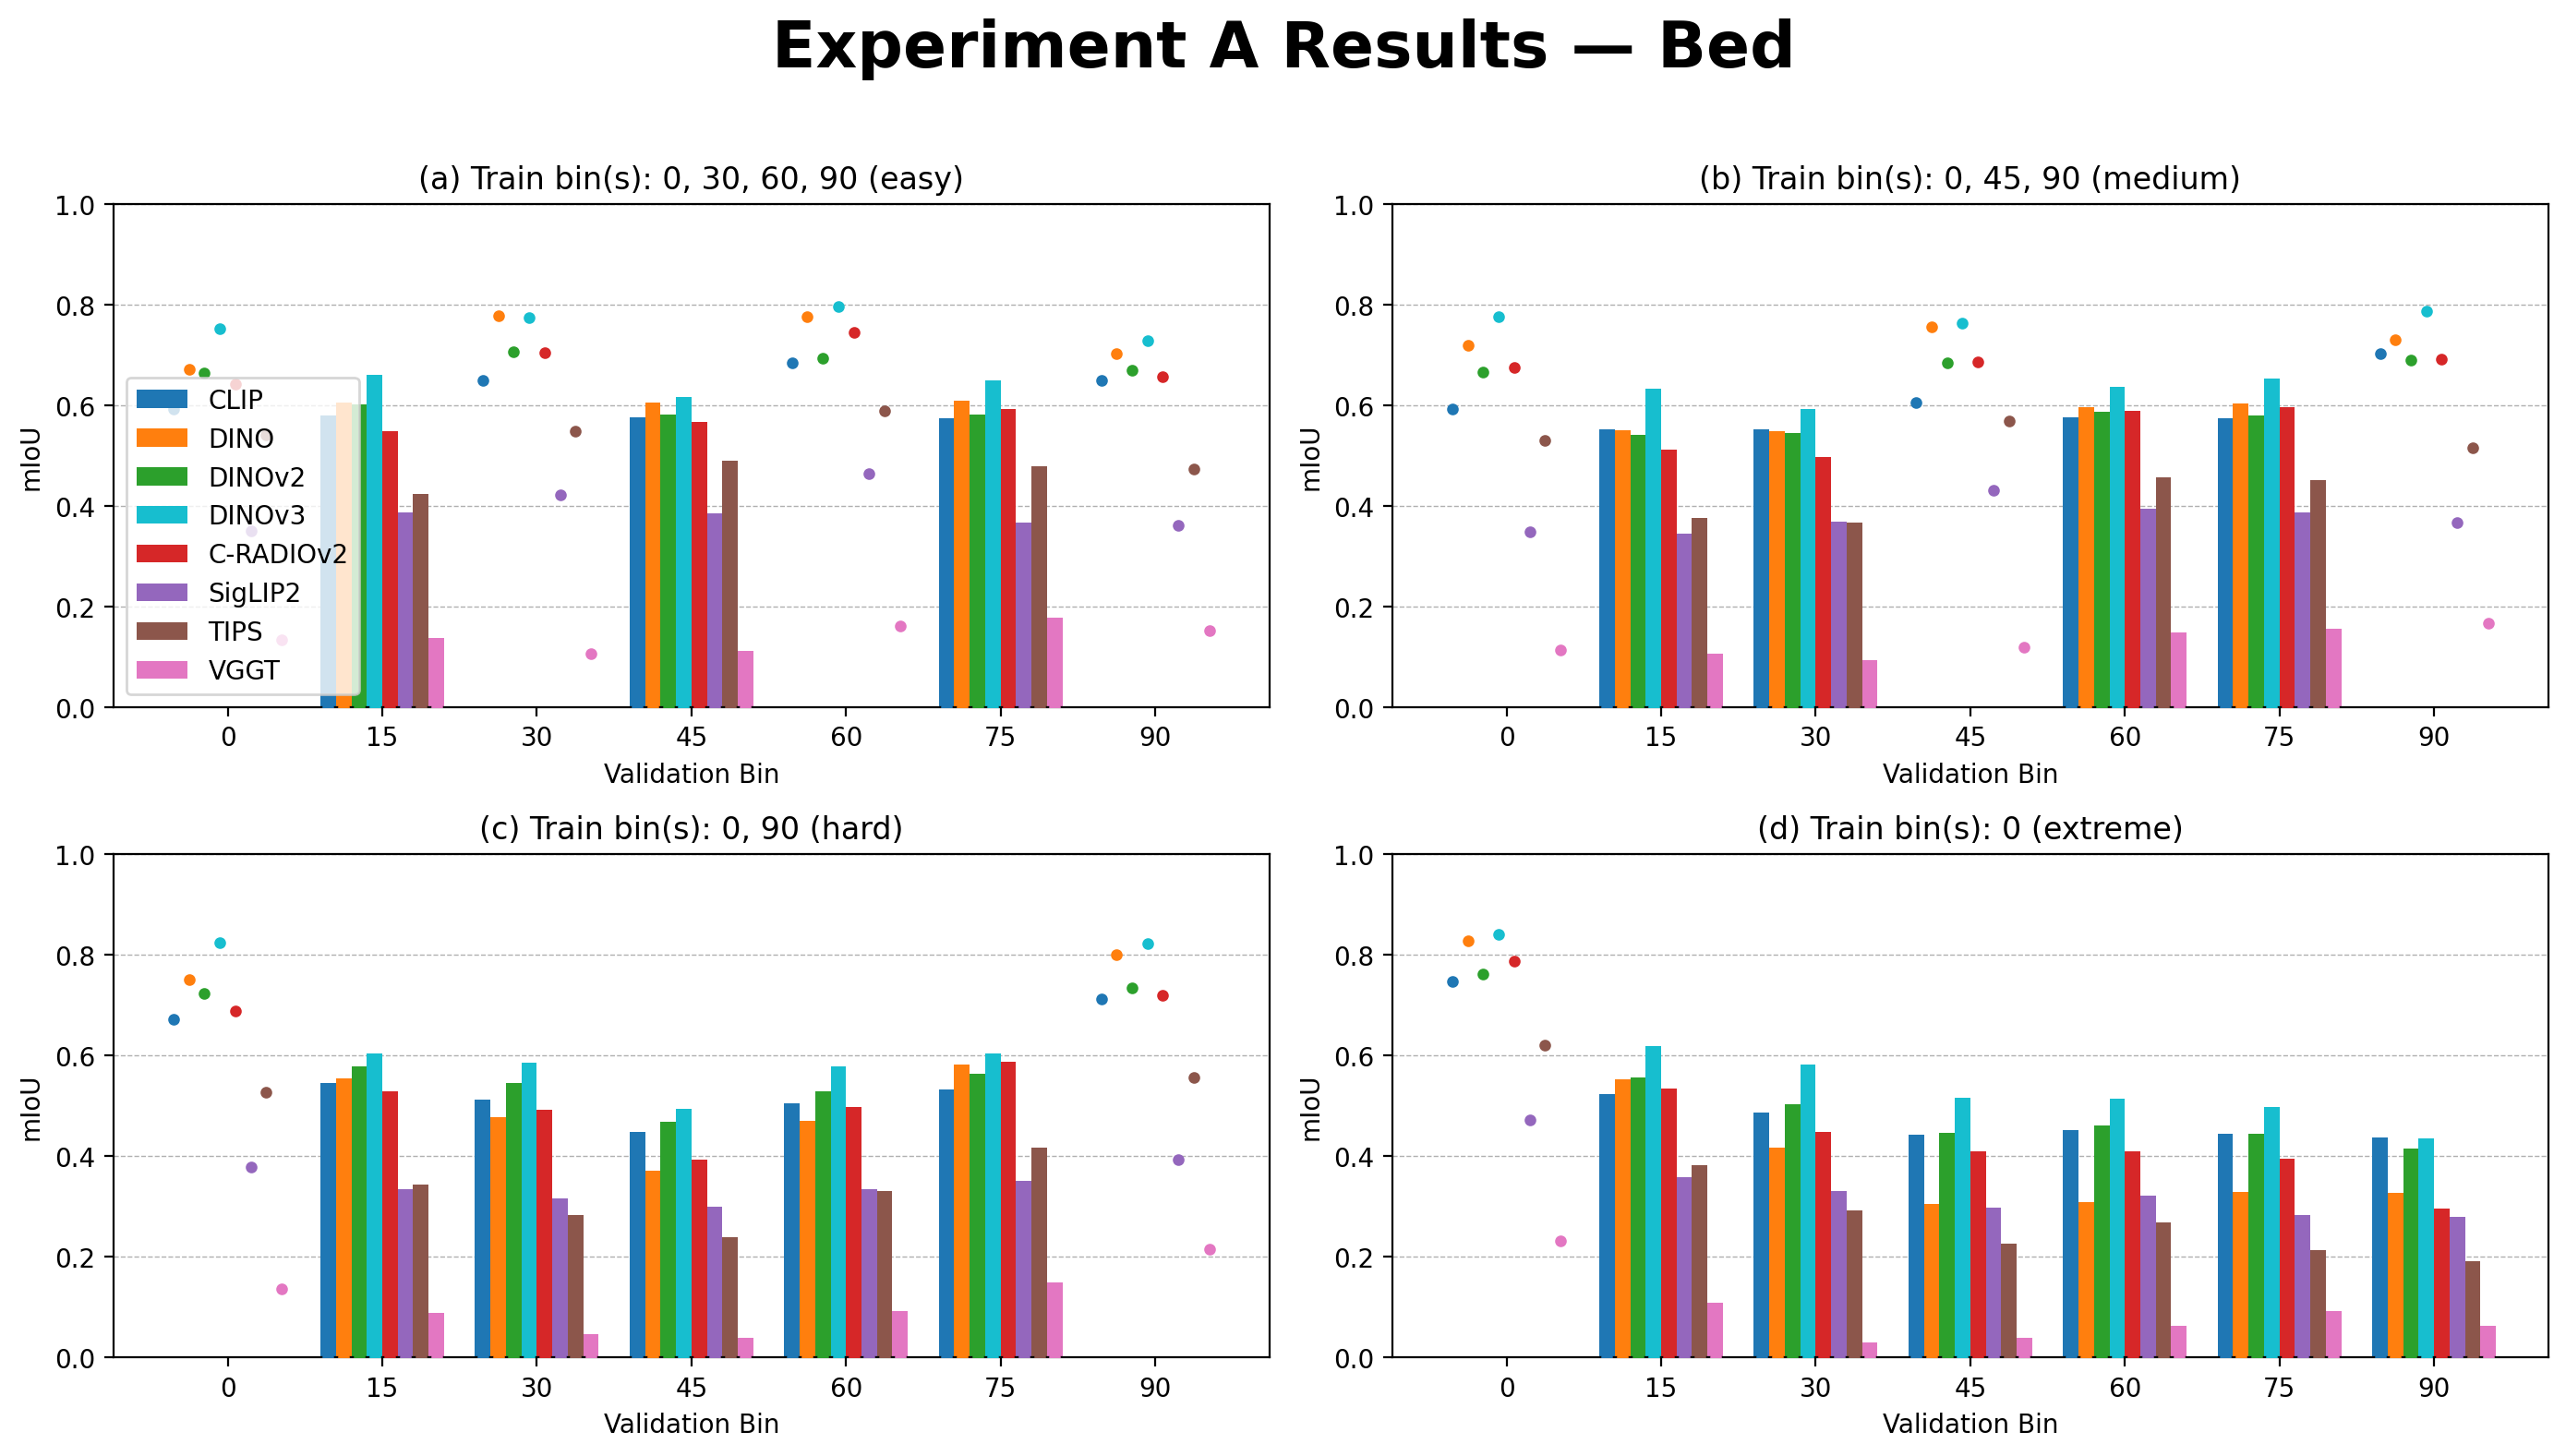

Saved figure to ../images/figures/5_toy_cat.png


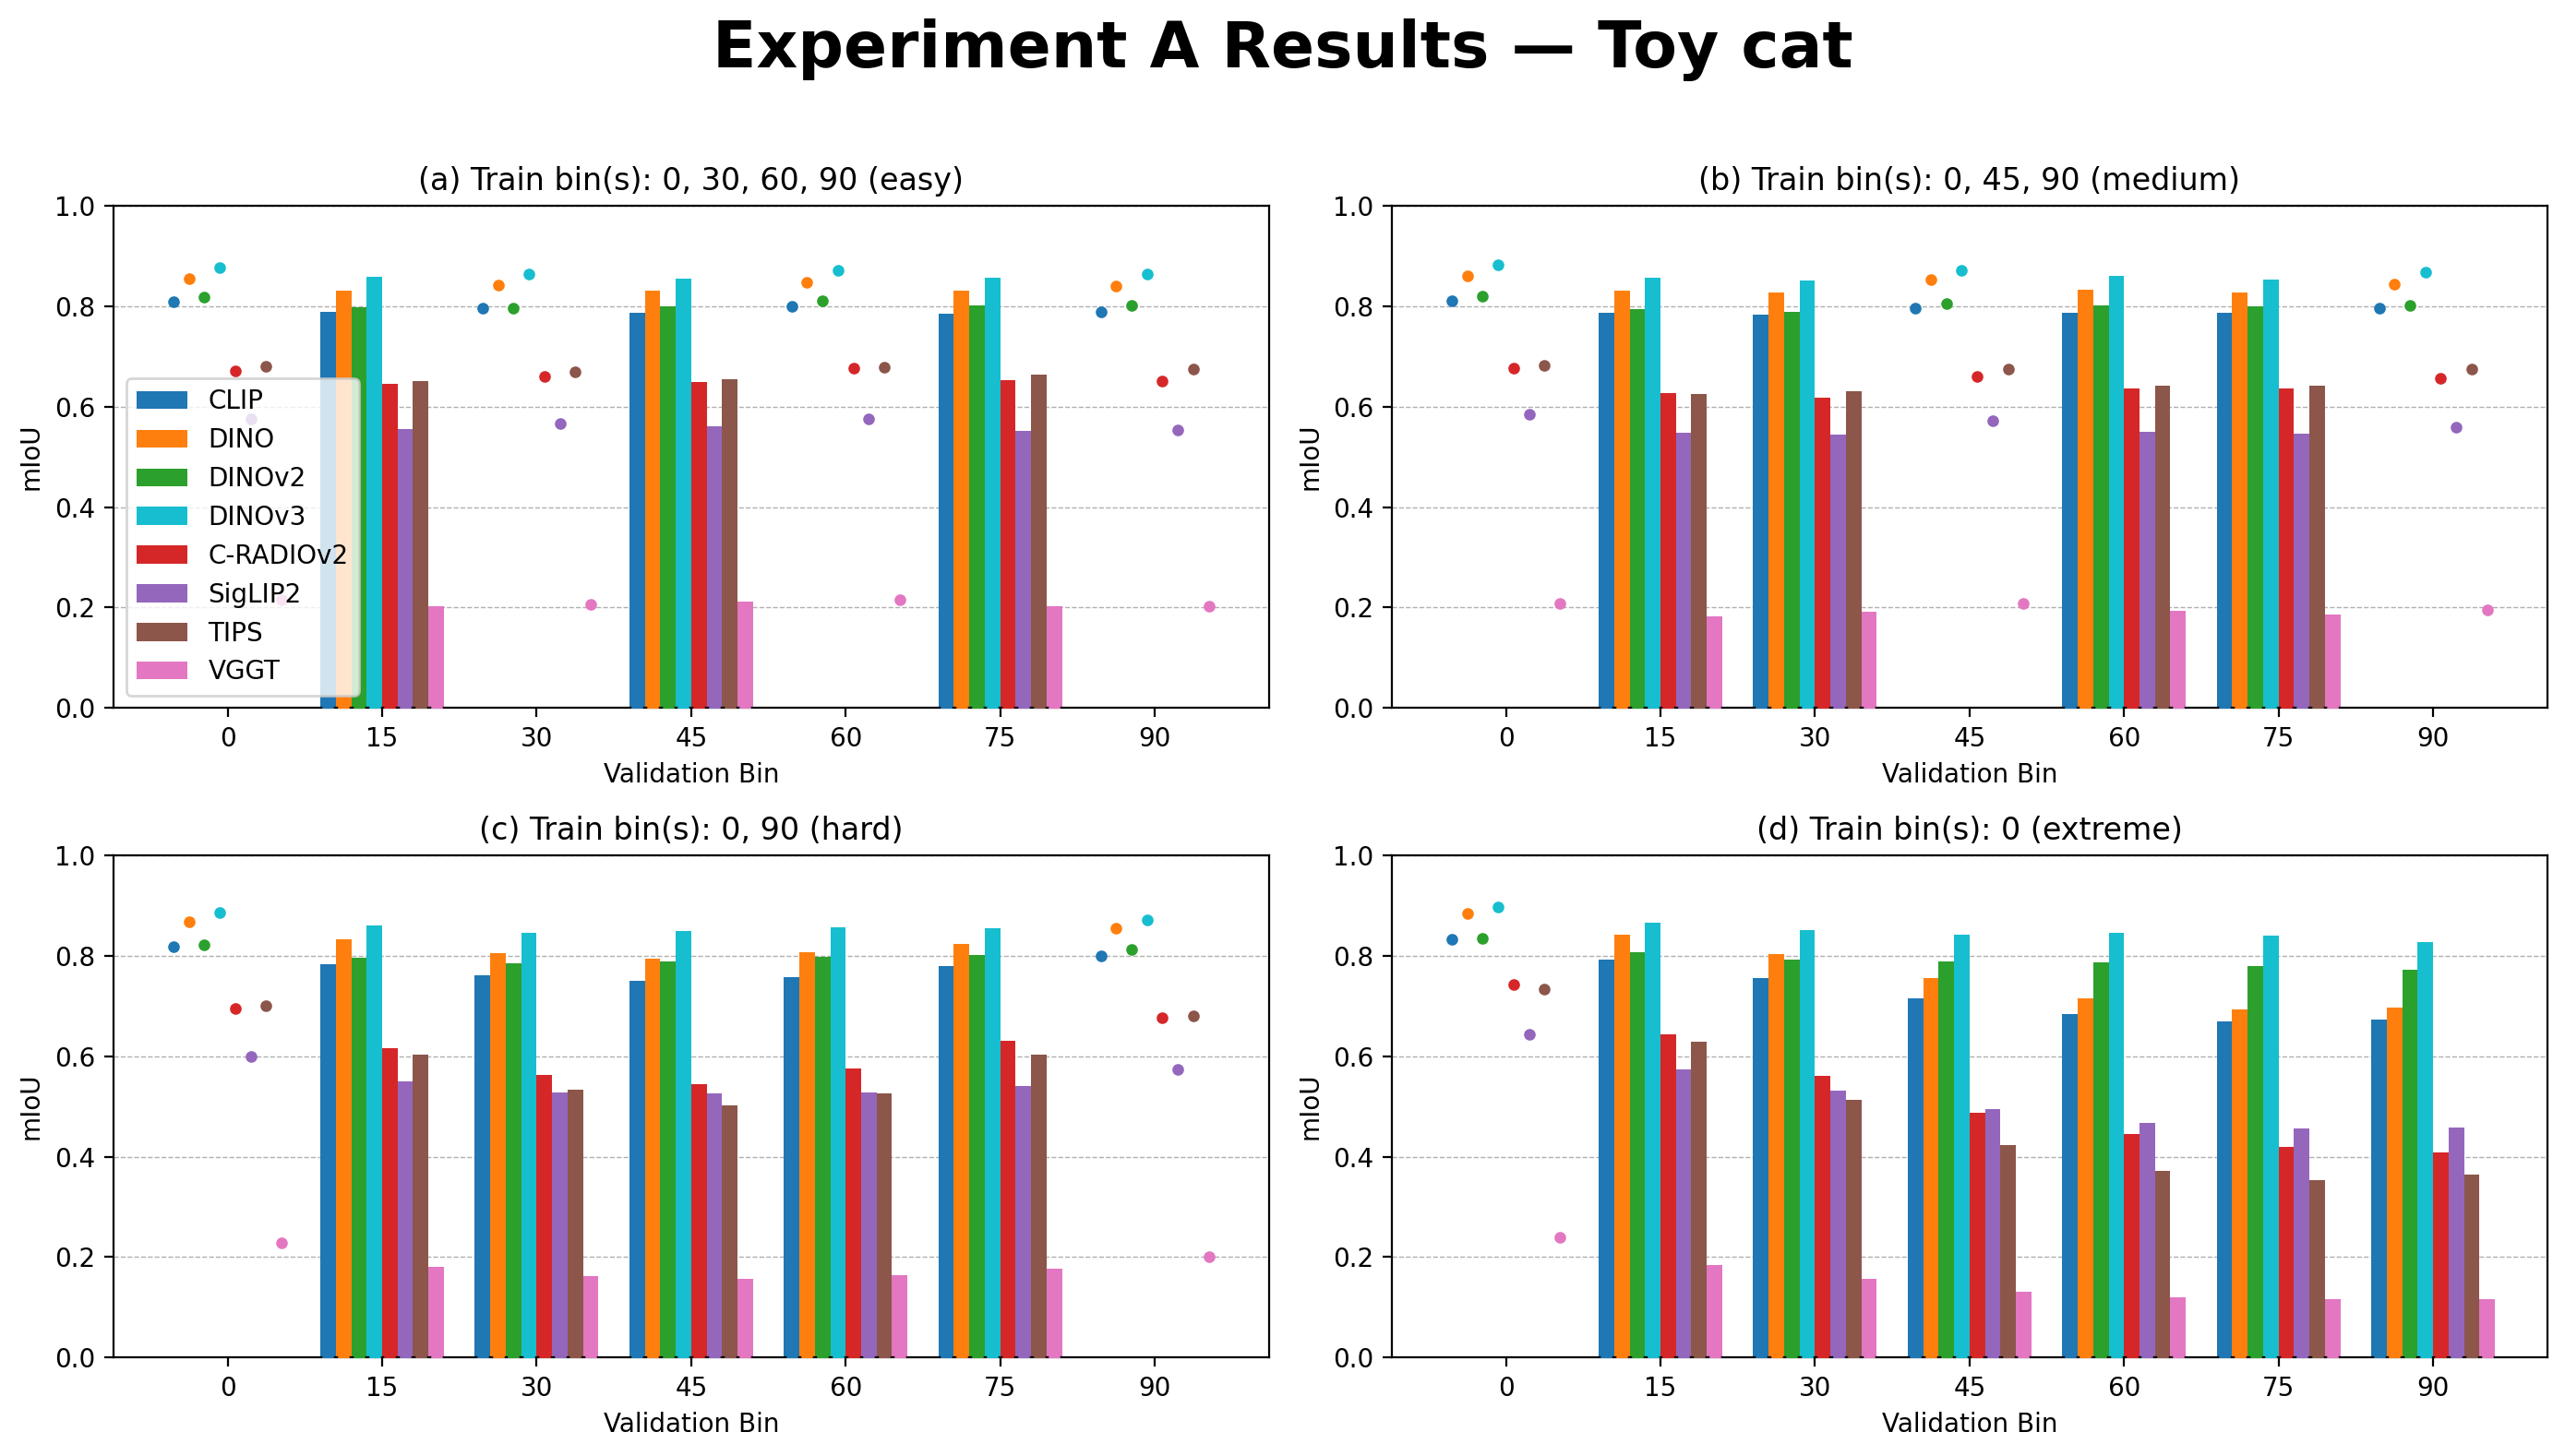

Saved figure to ../images/figures/6_toy_cow.png


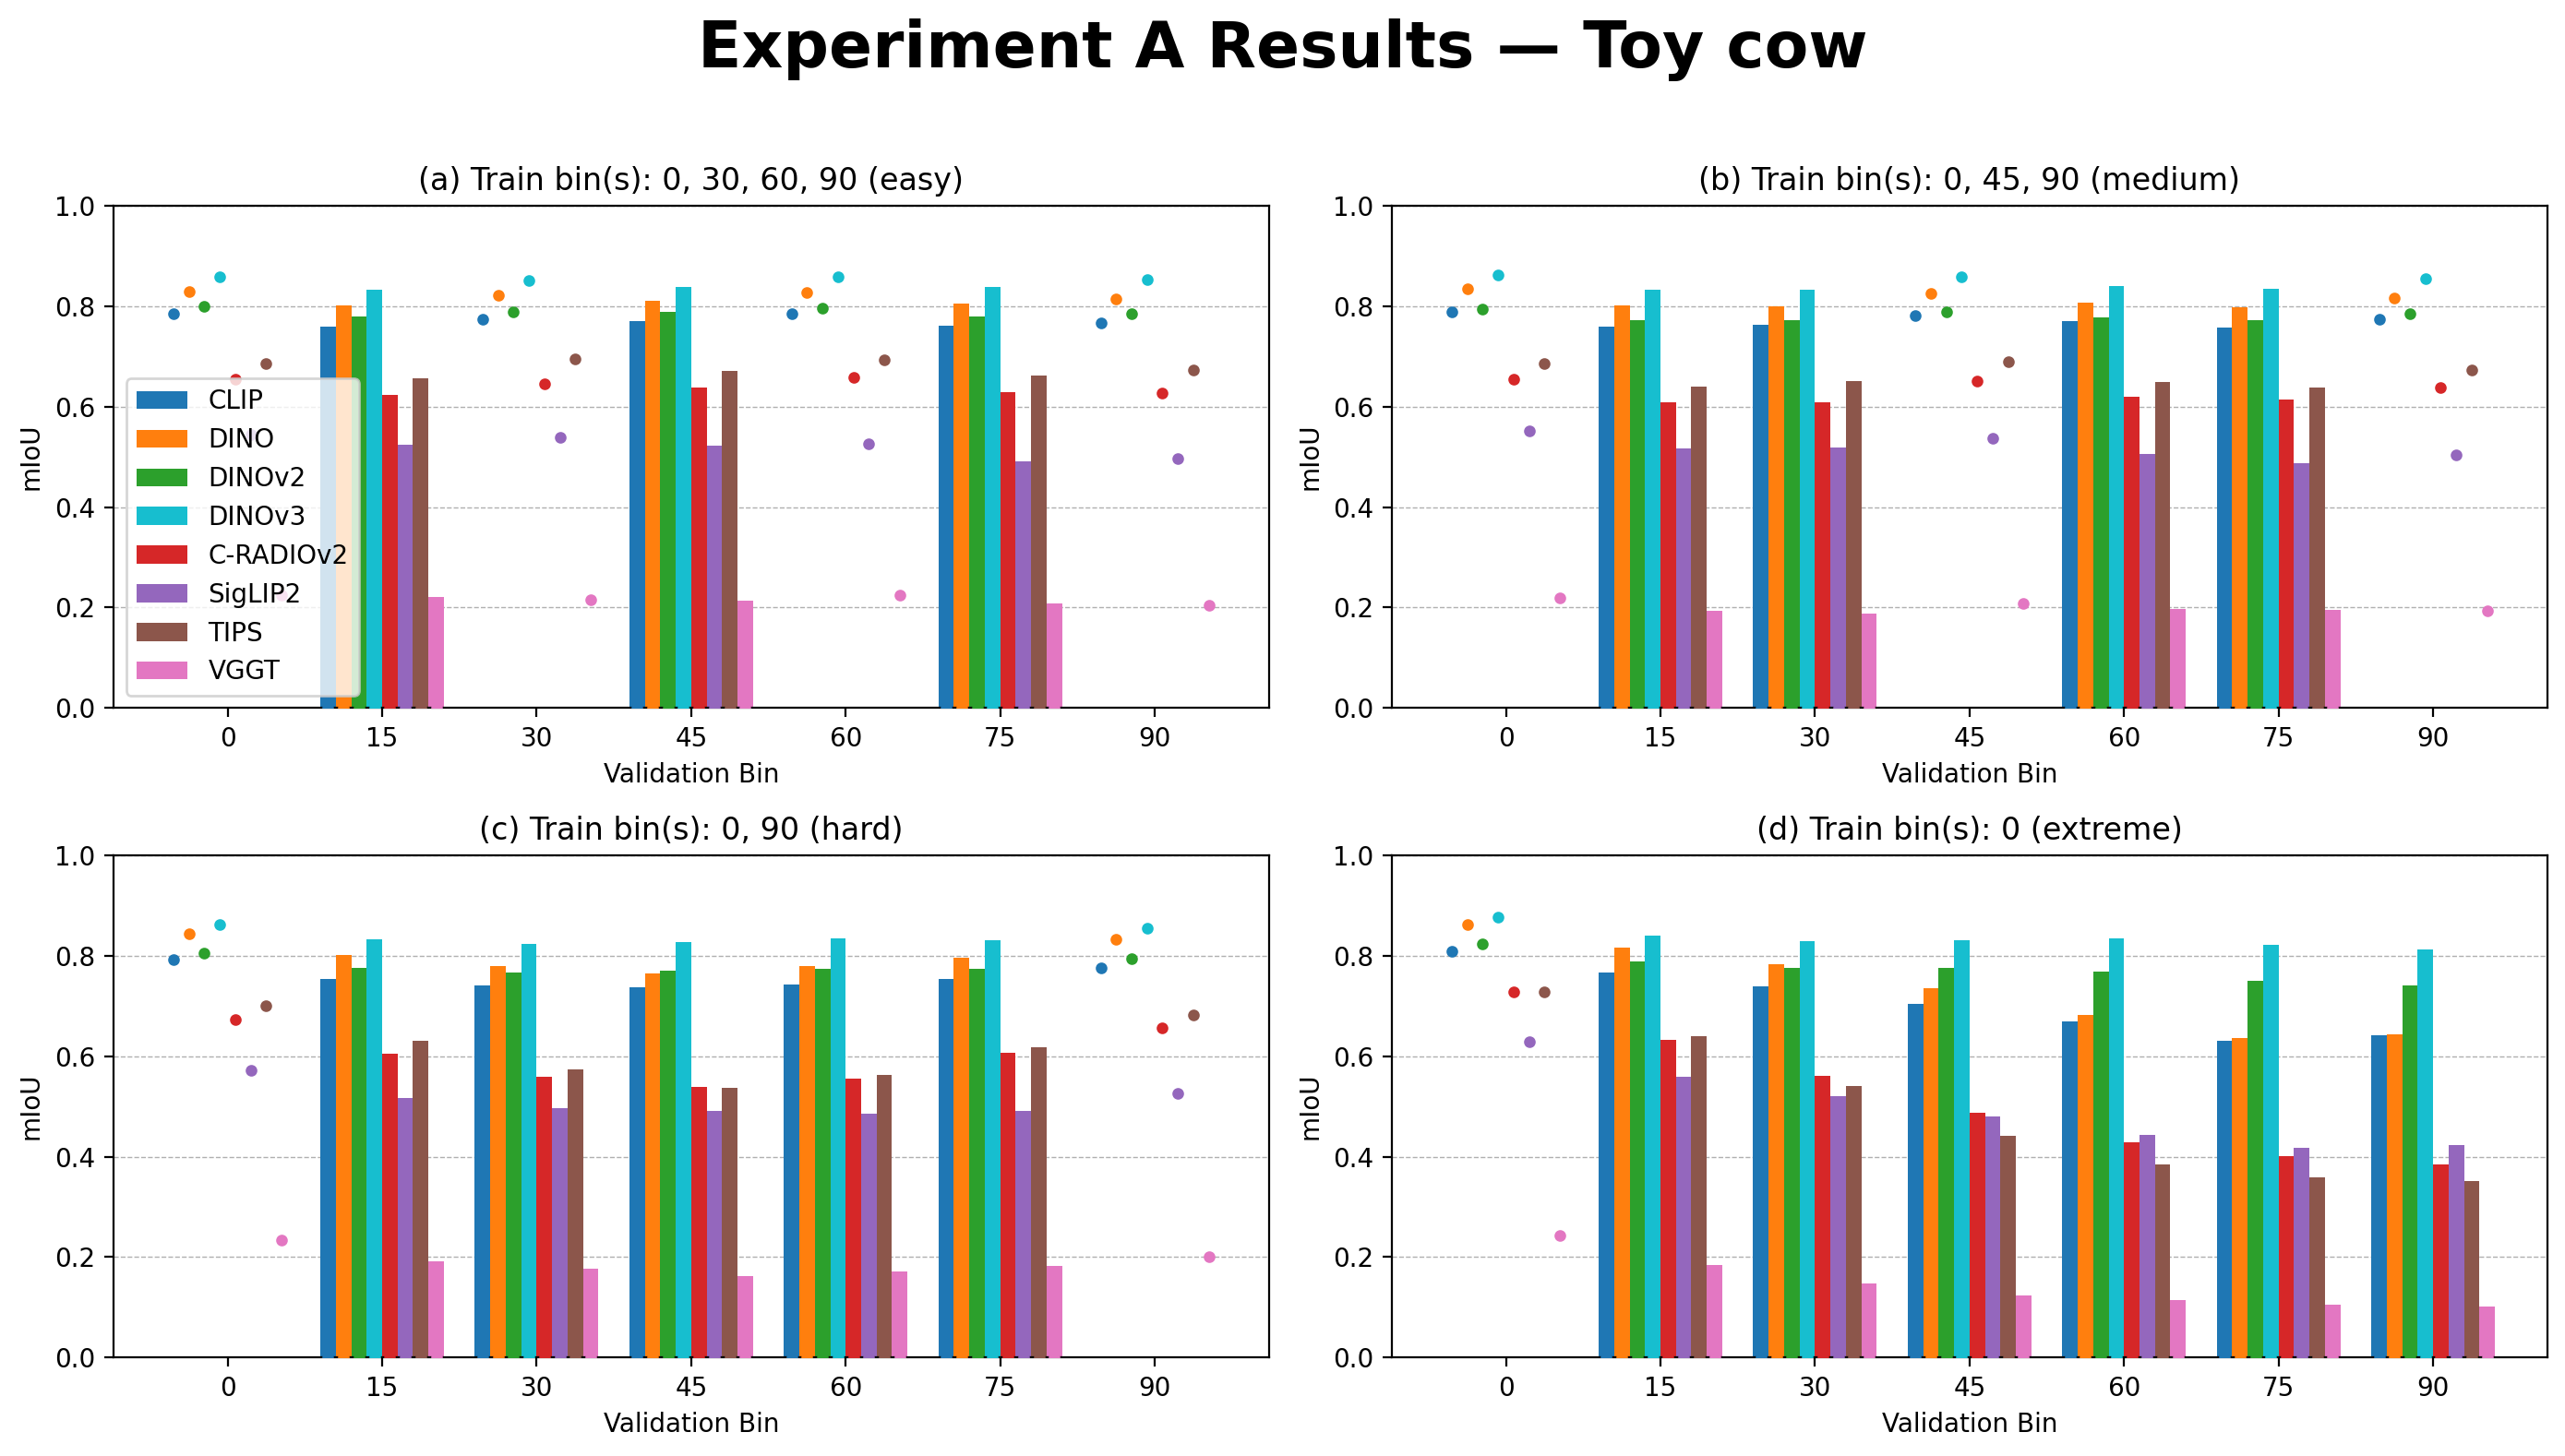

Saved figure to ../images/figures/7_toy_dragon.png


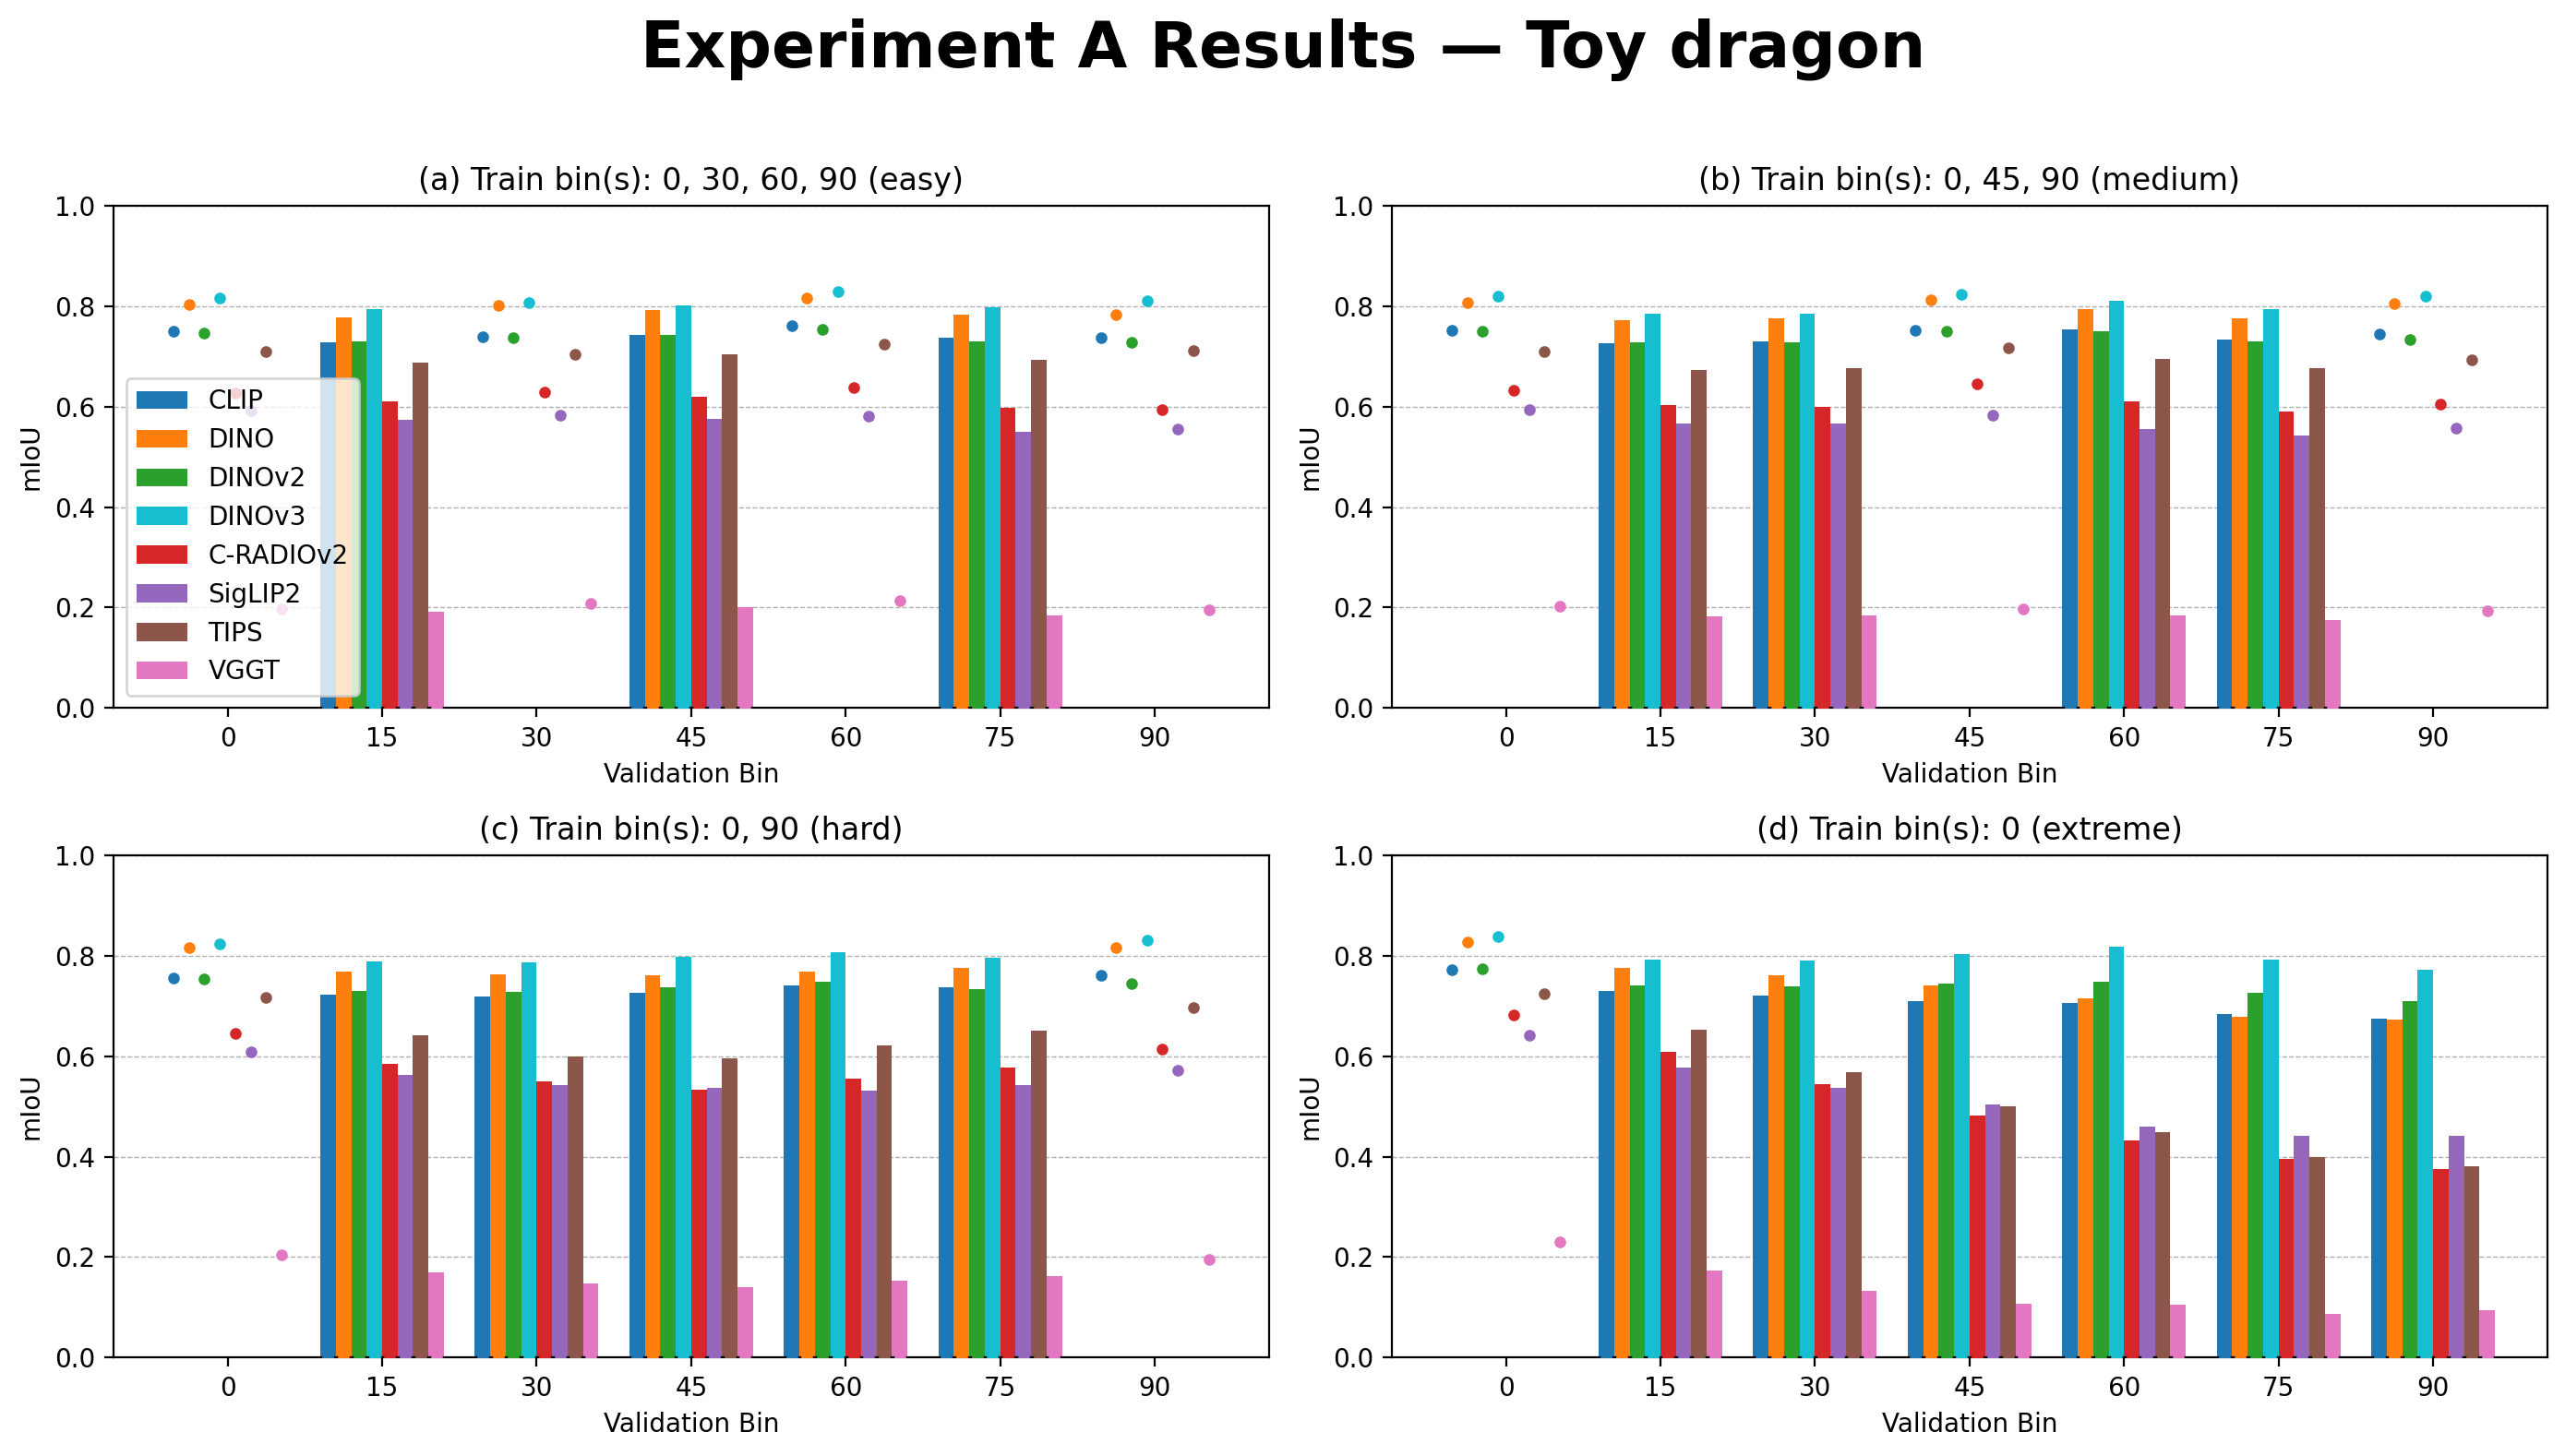

Saved figure to ../images/figures/8_coat_rack.png


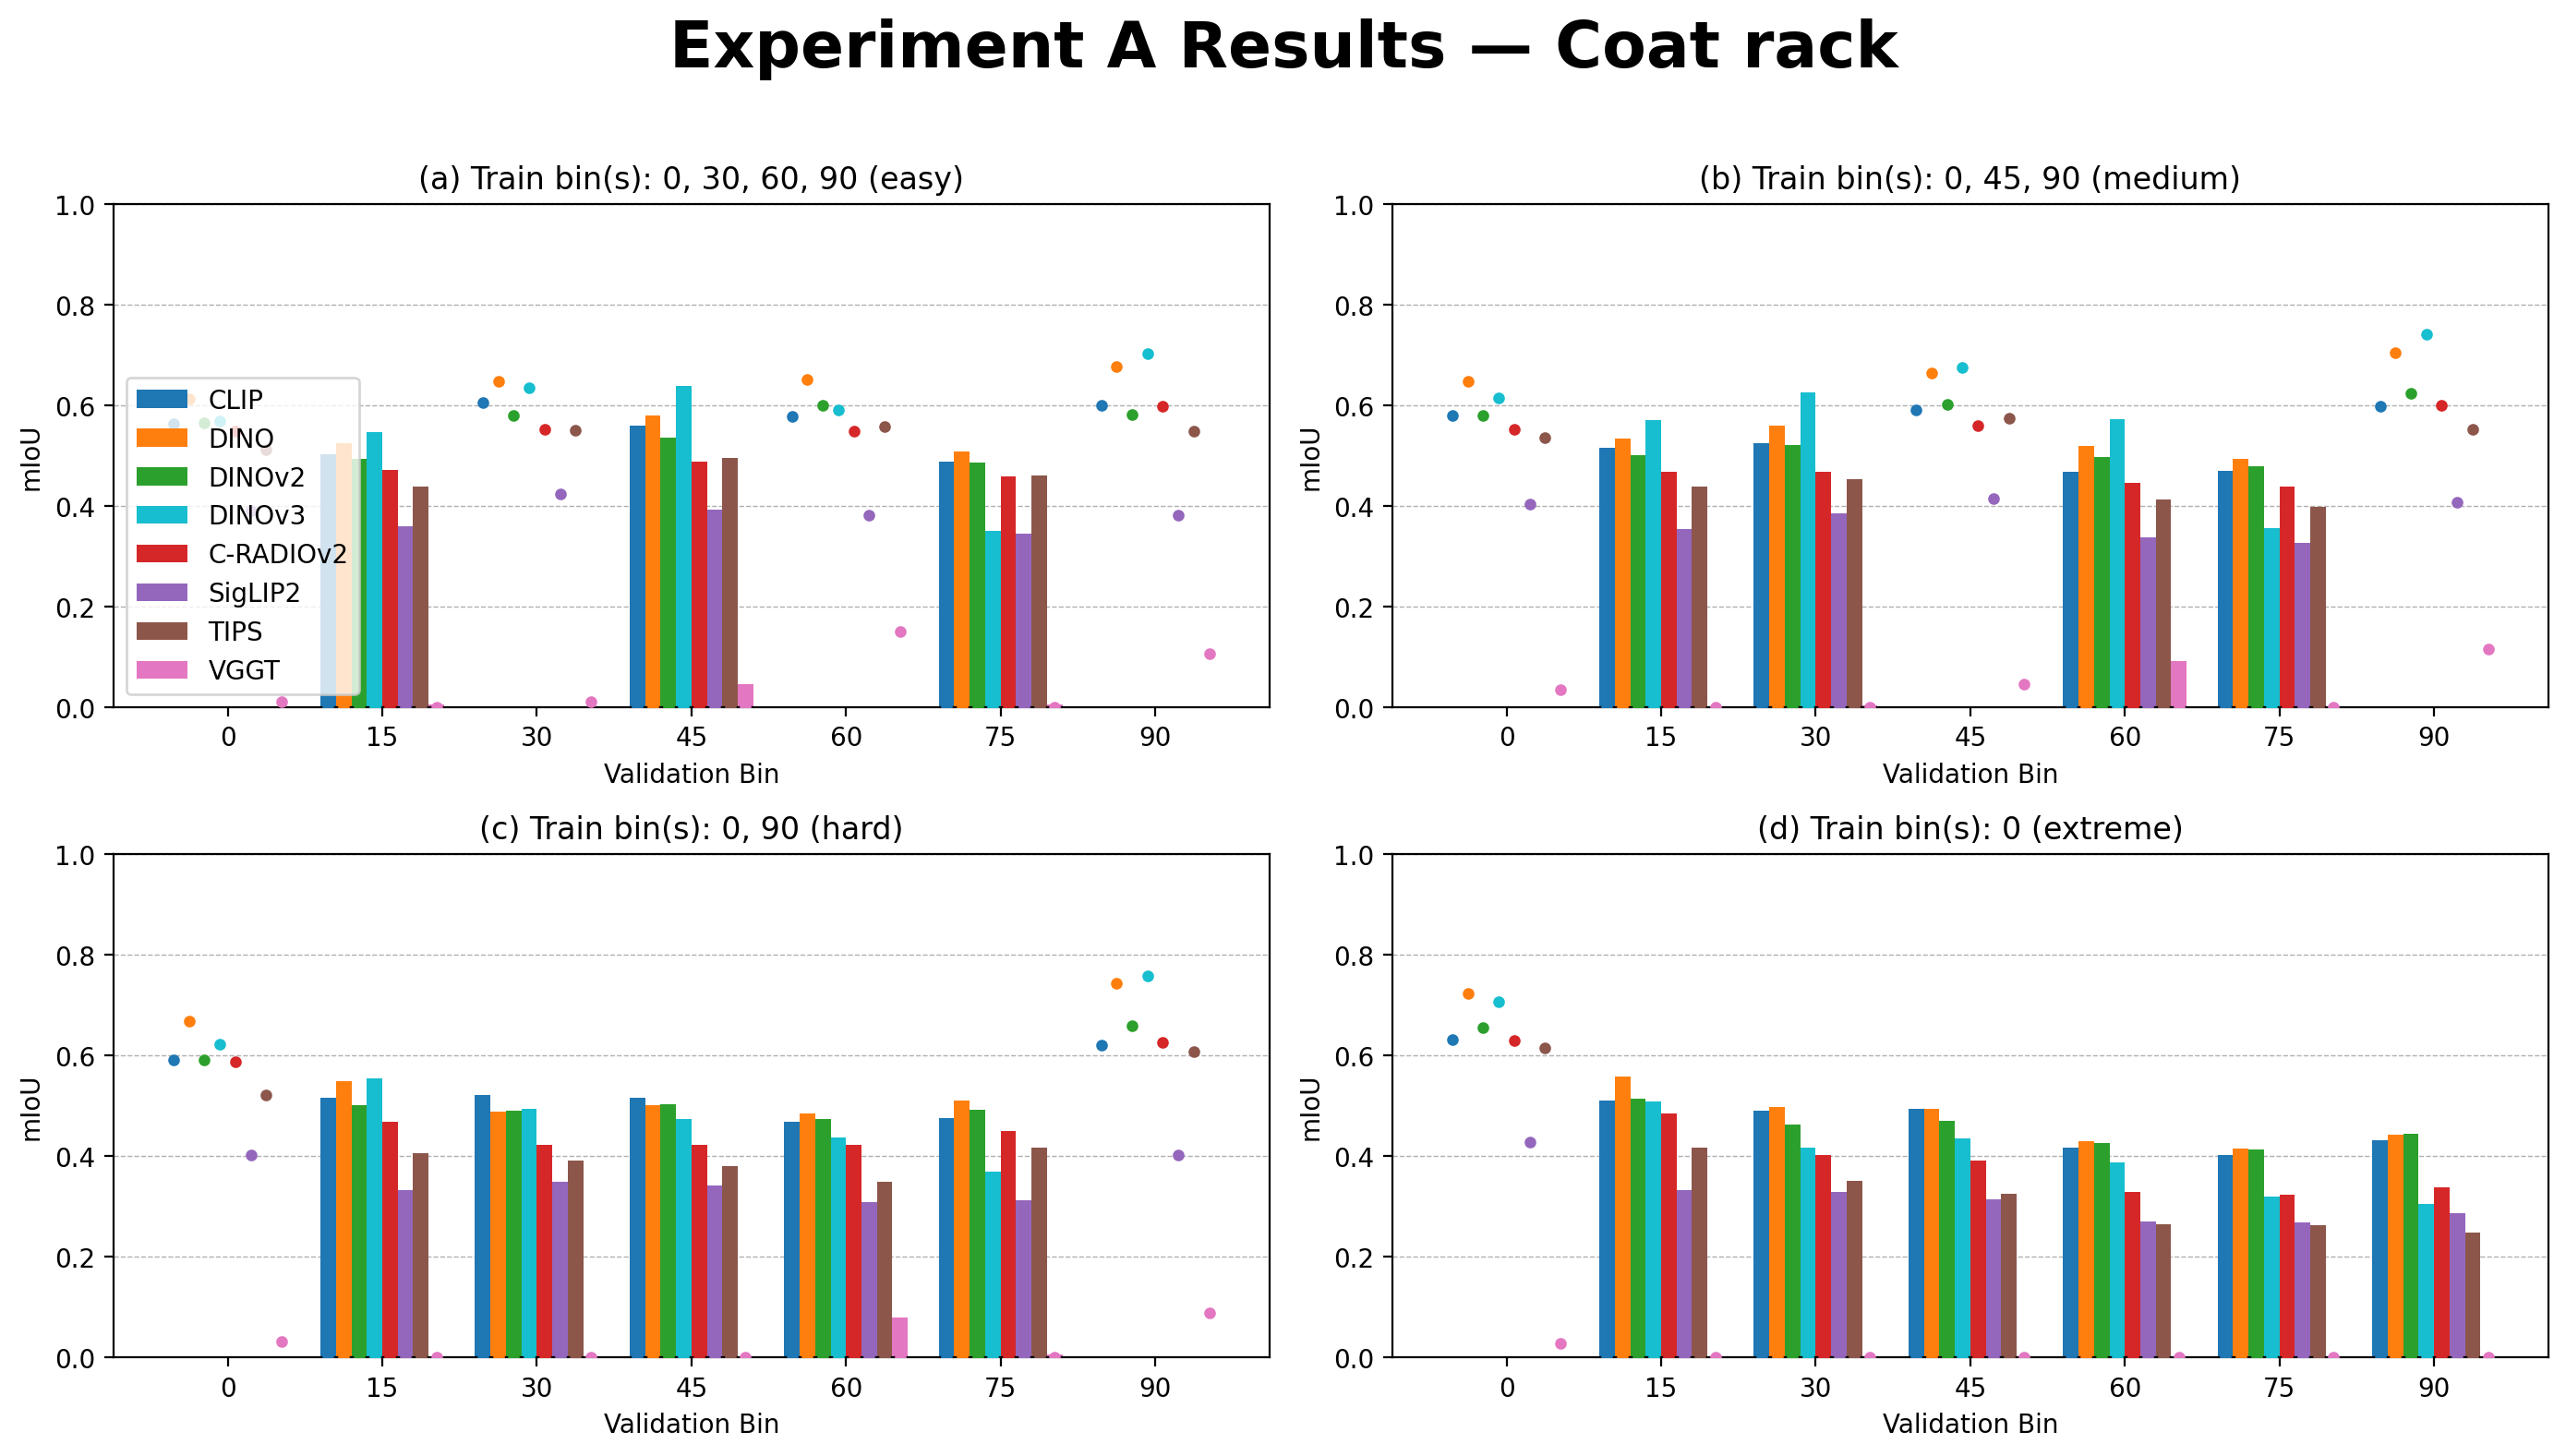

Saved figure to ../images/figures/9_guitar_stand.png


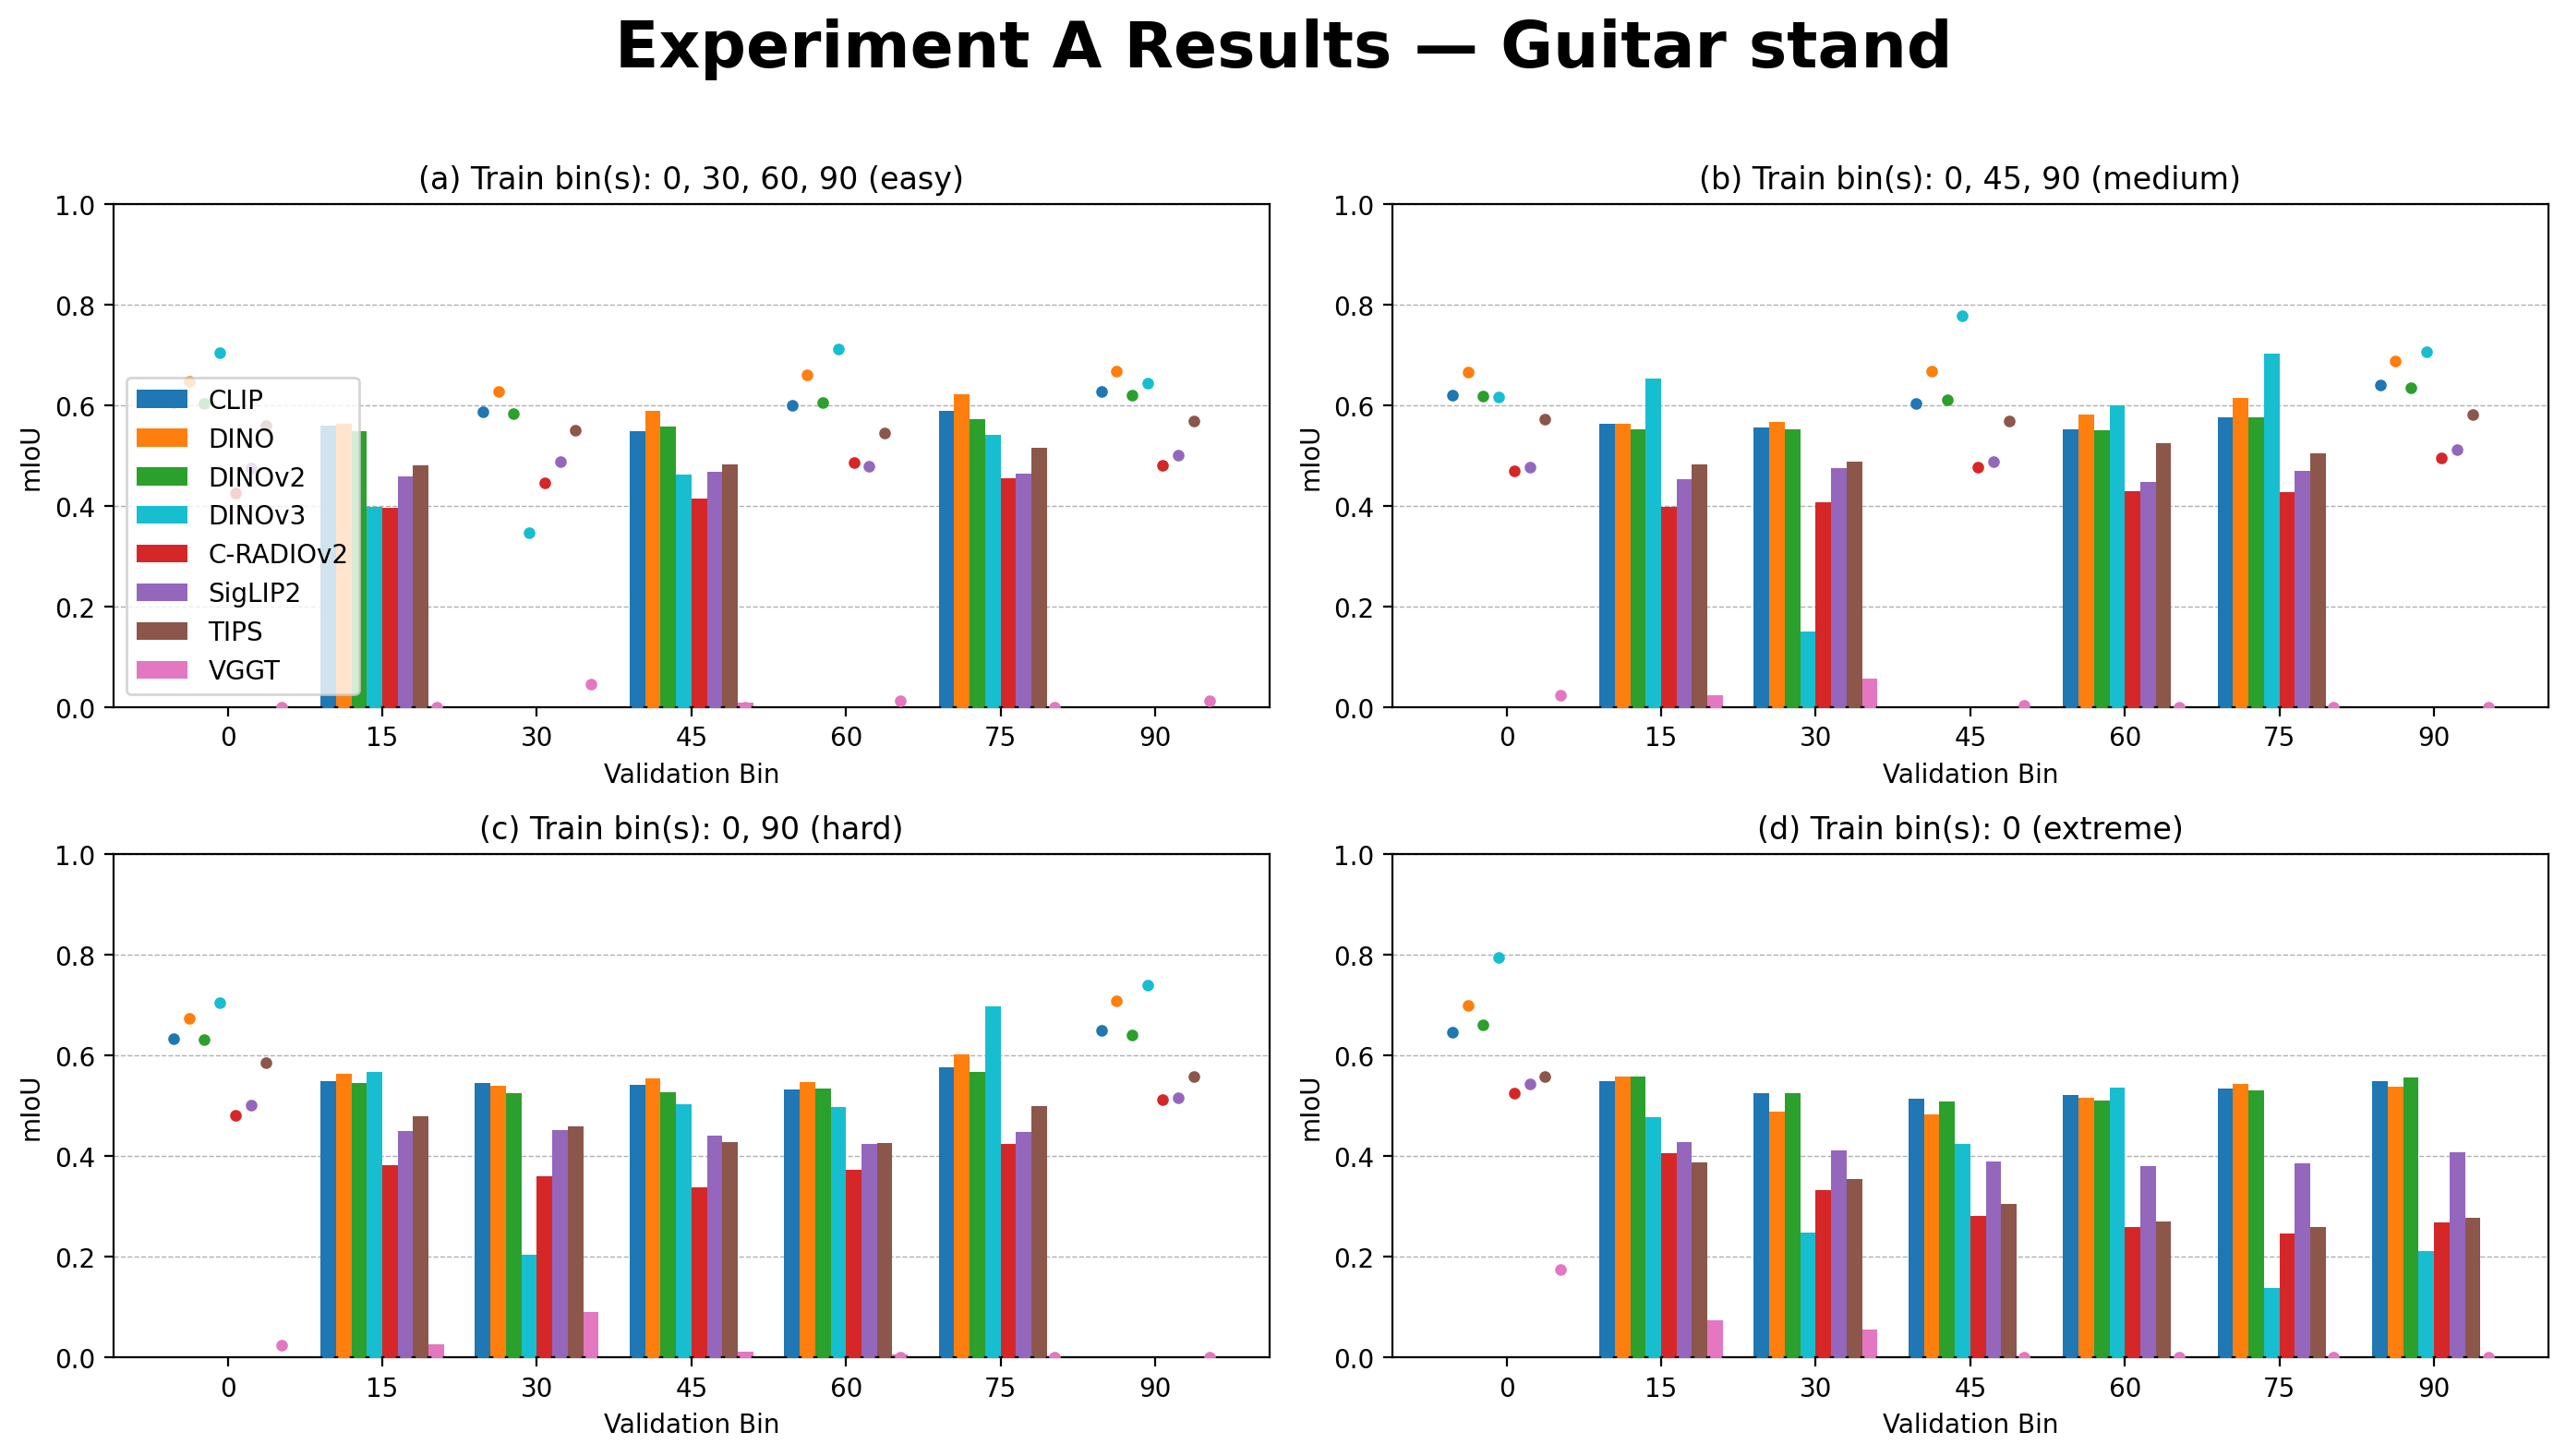

Saved figure to ../images/figures/10_ceiling_lamp.png


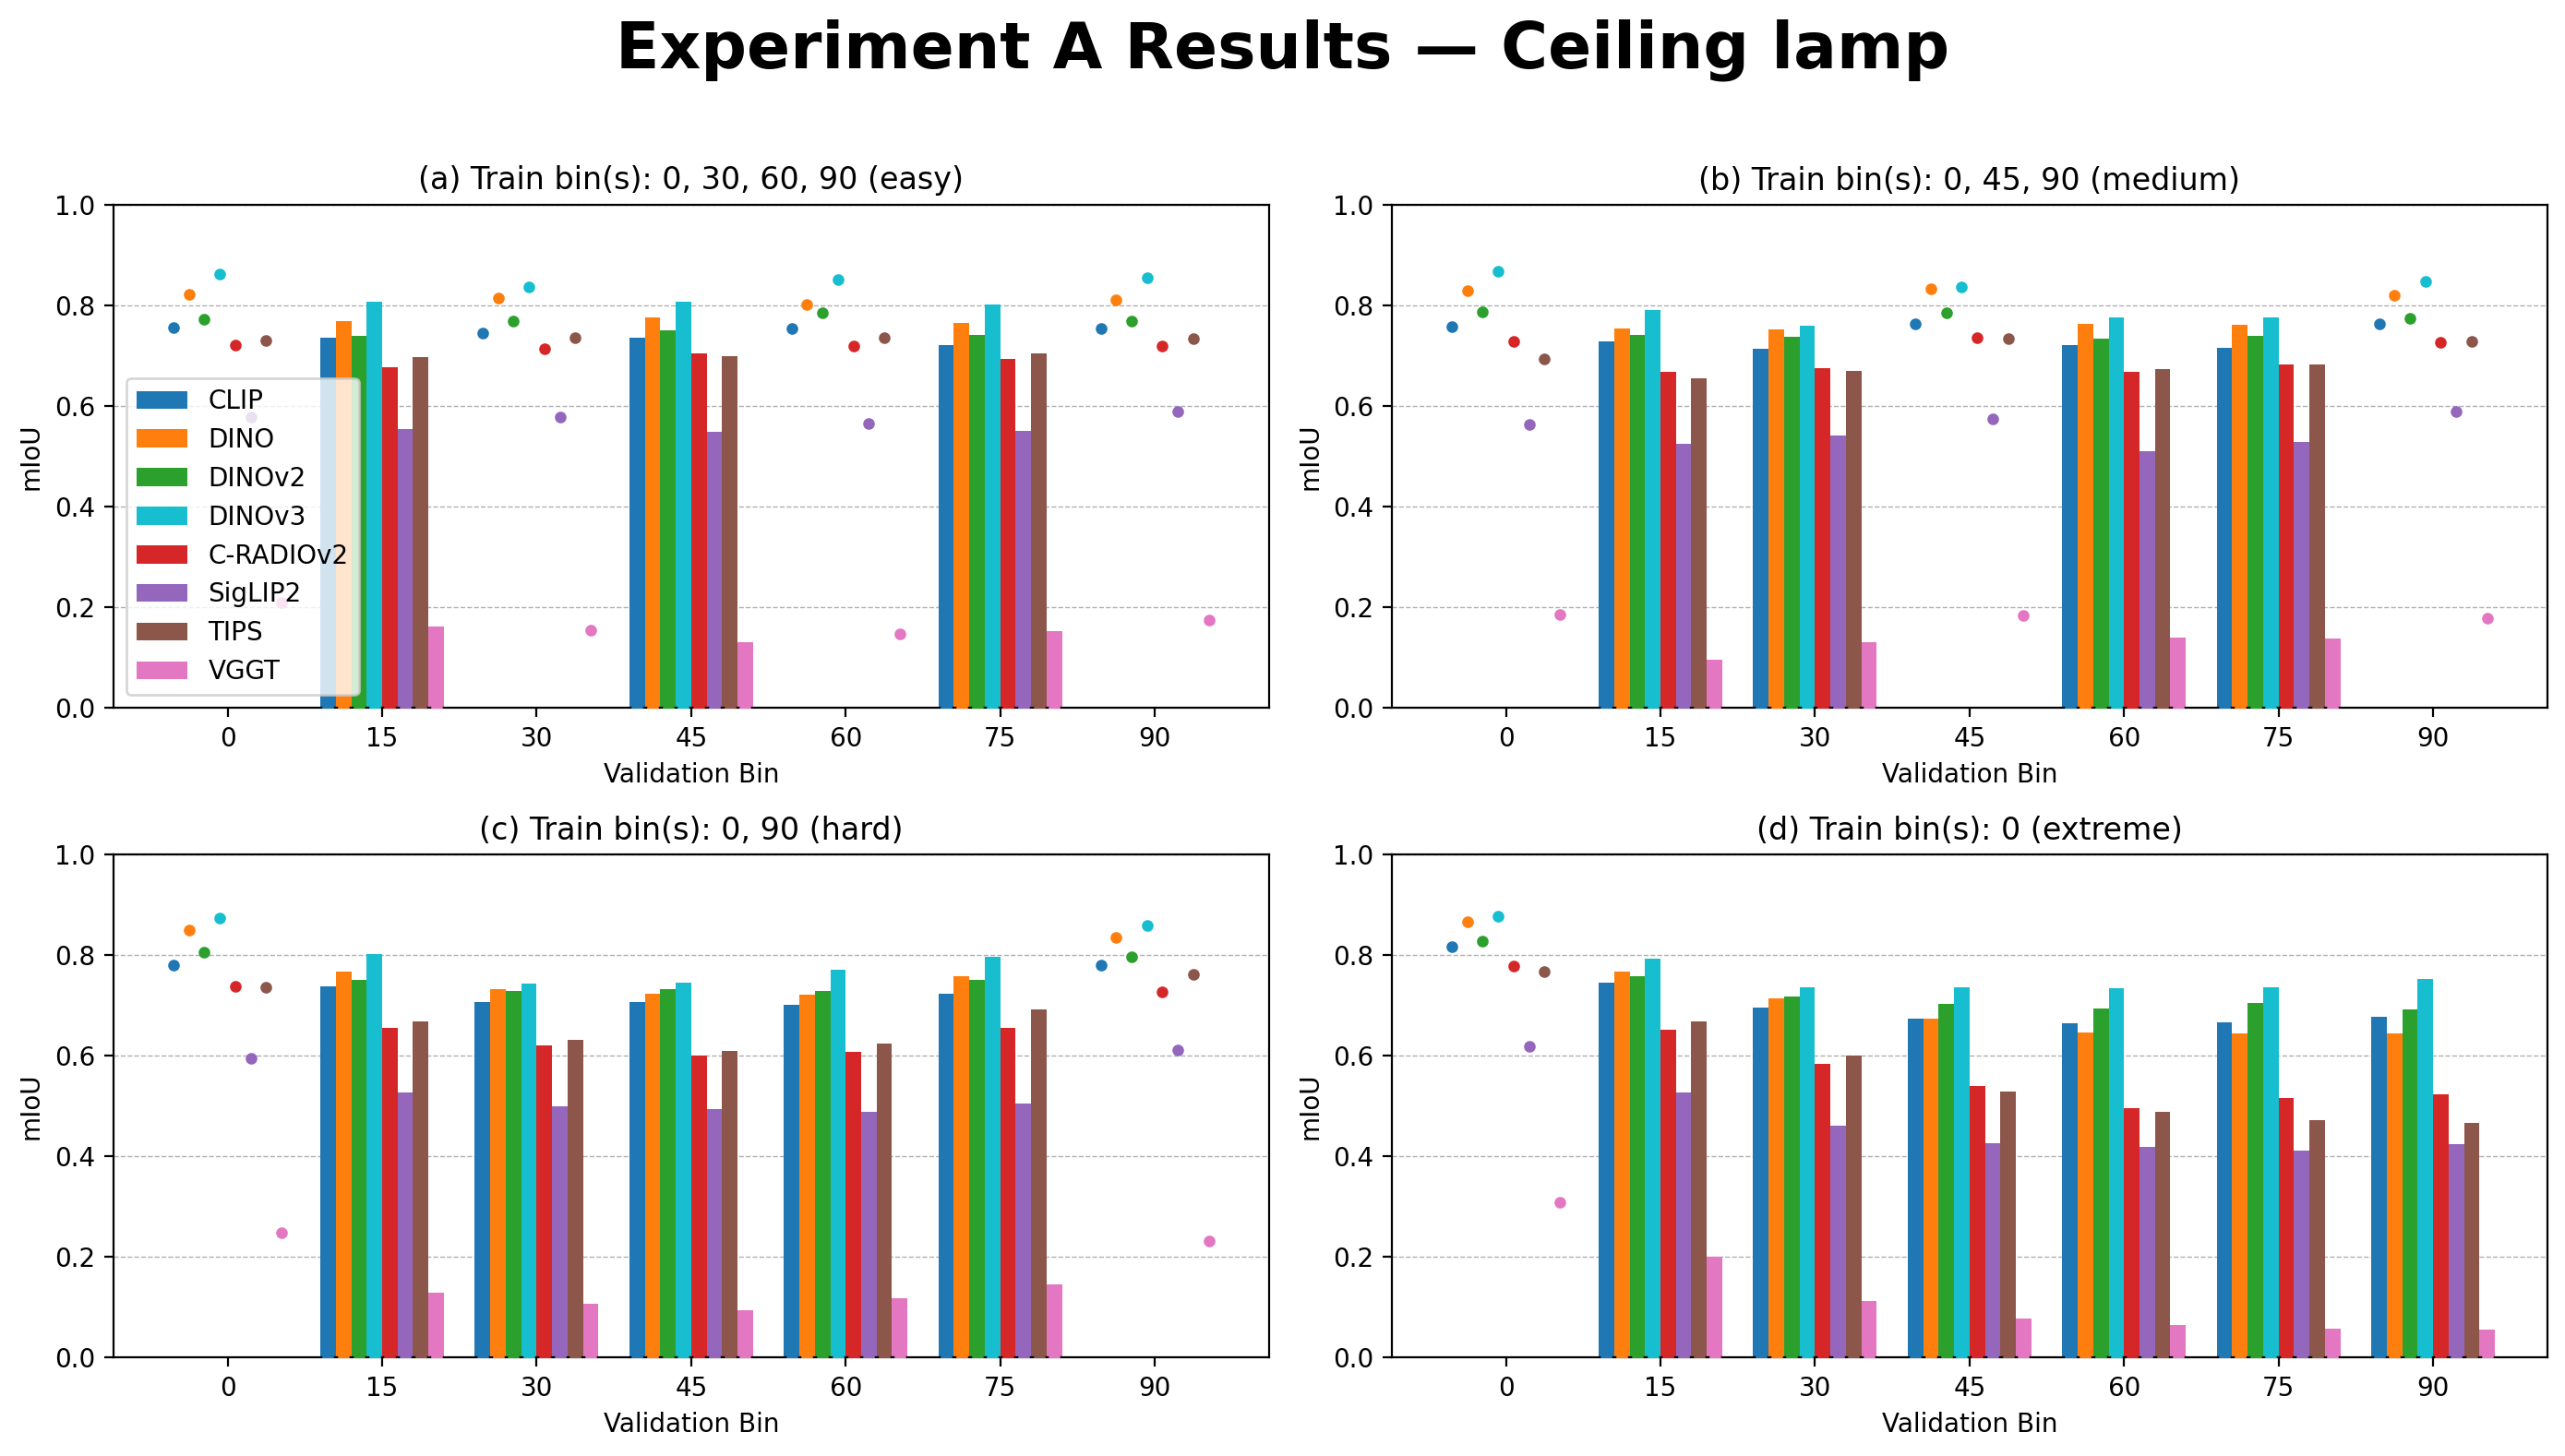

Saved figure to ../images/figures/11_toilet.png


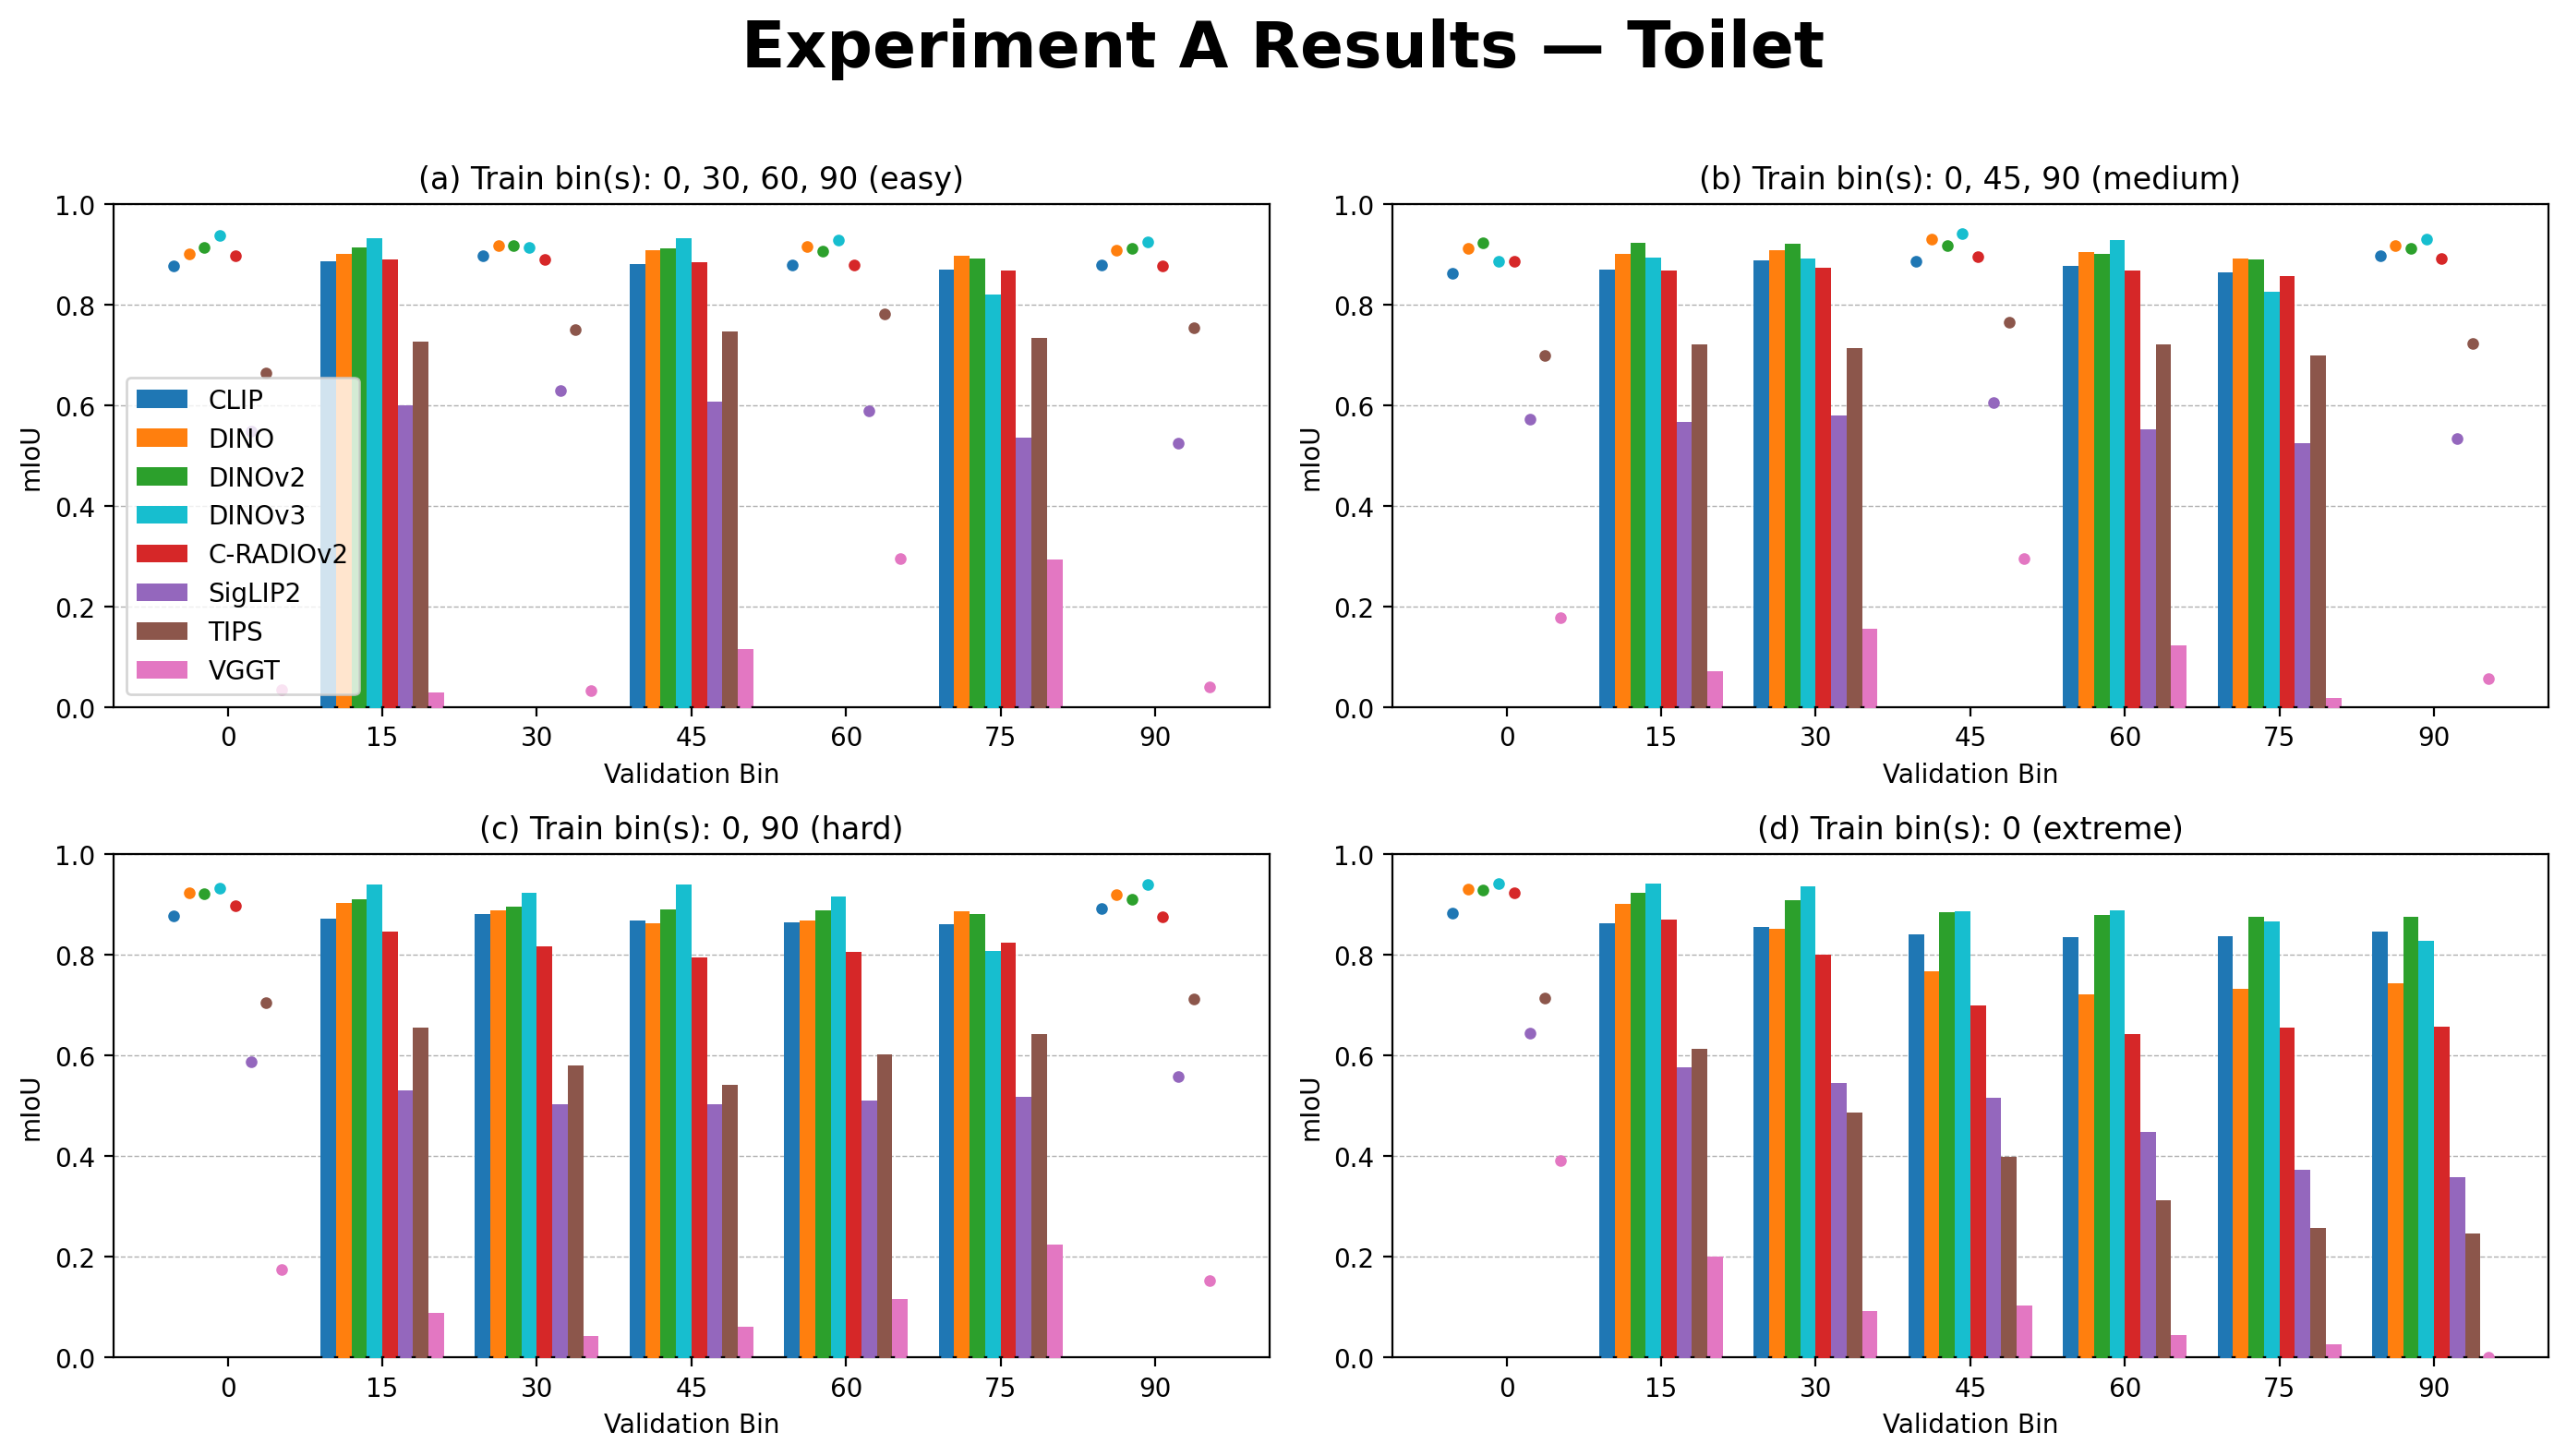

Saved figure to ../images/figures/12_sink.png


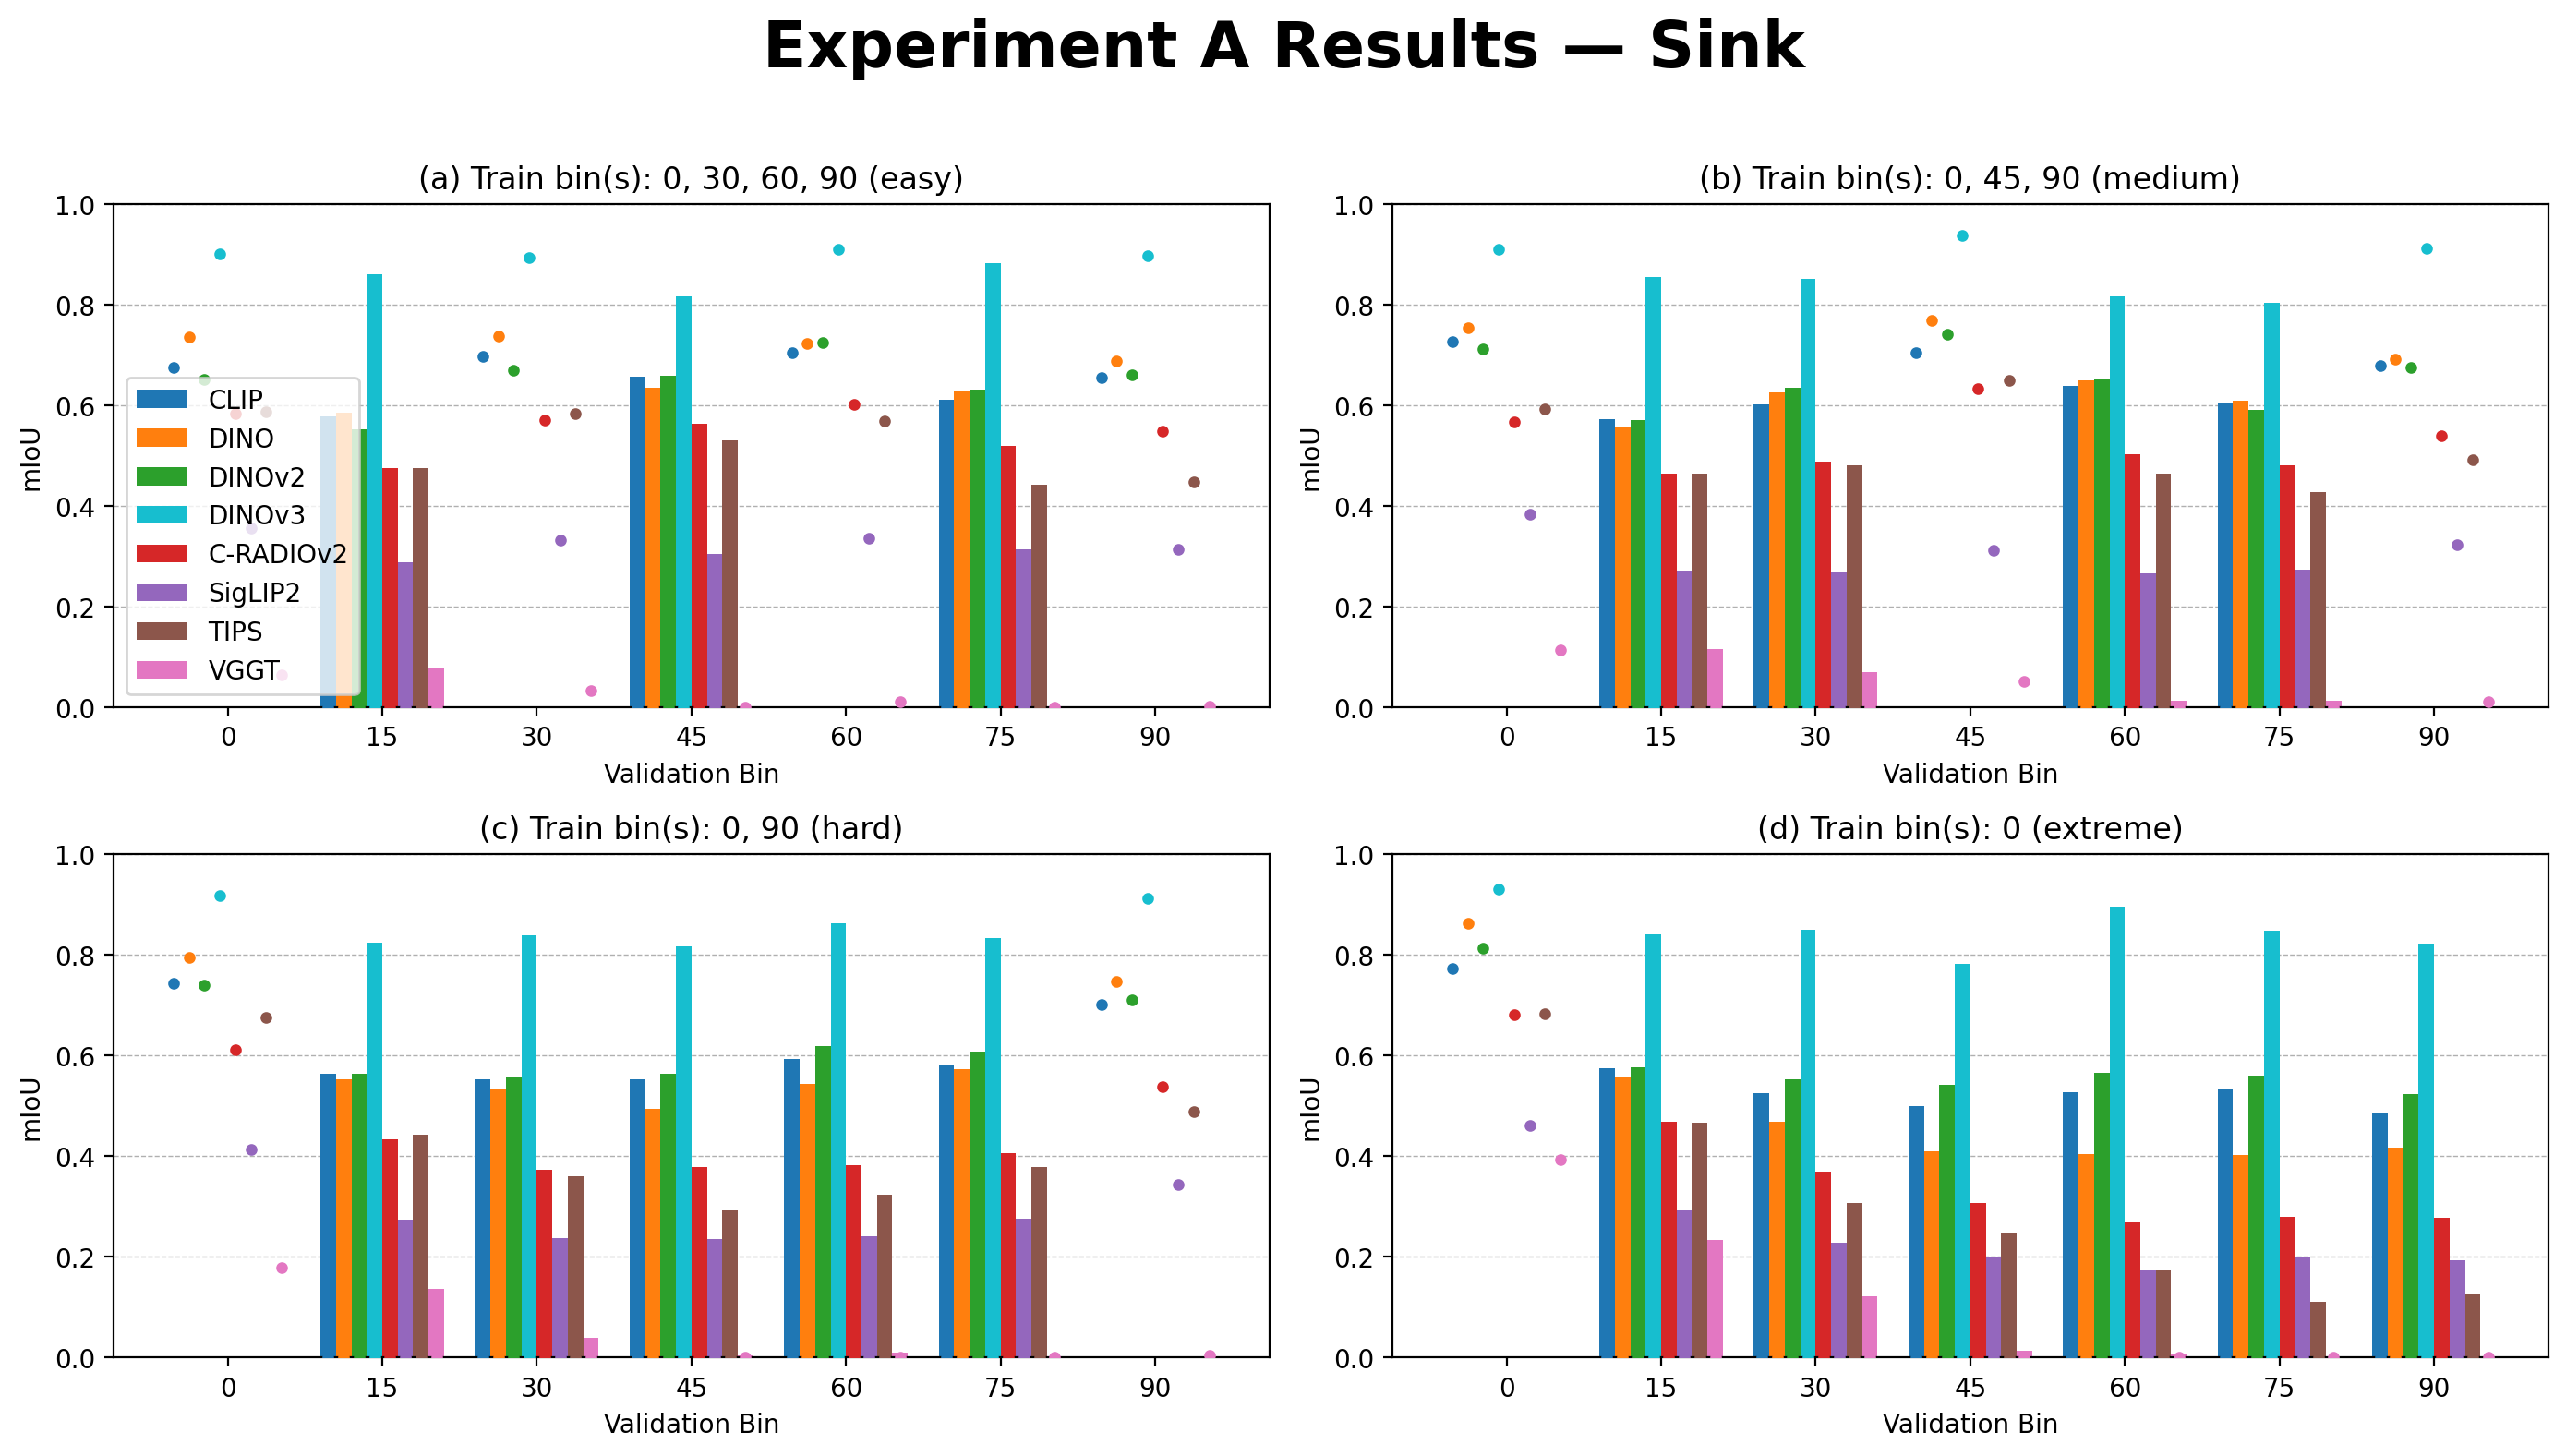

Saved figure to ../images/figures/13_strings.png


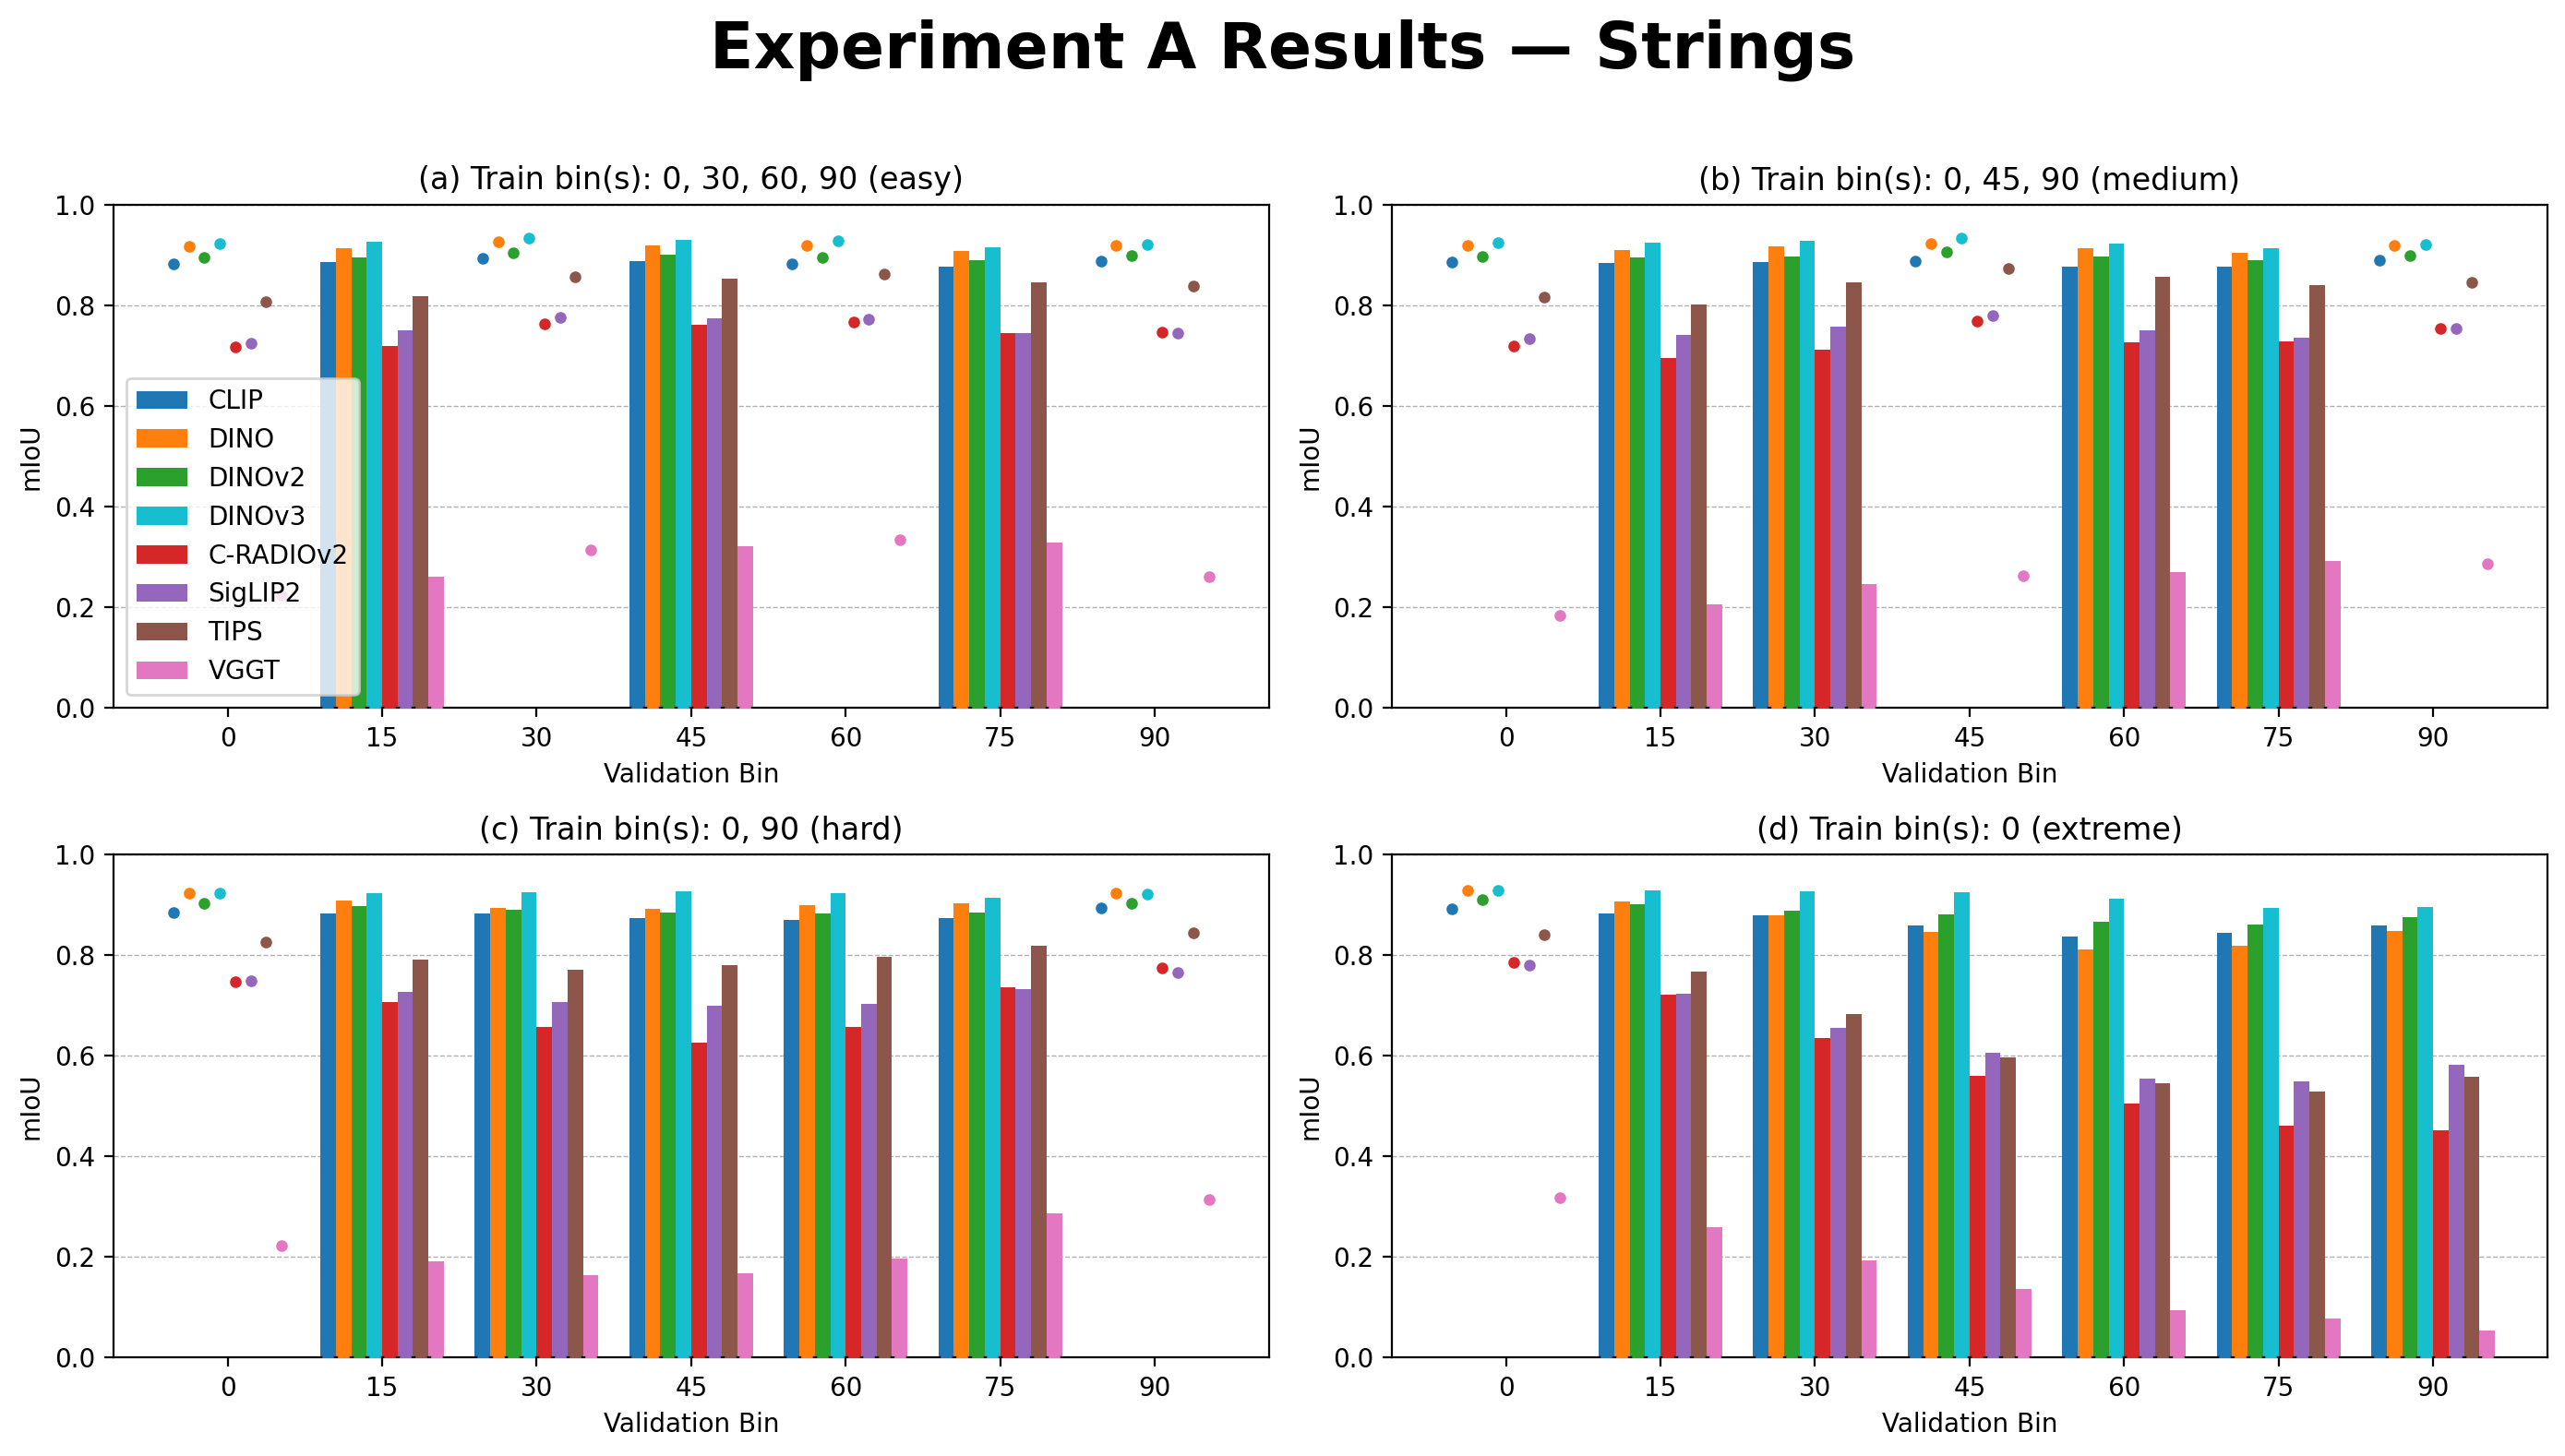

Saved figure to ../images/figures/14_broccoli.png


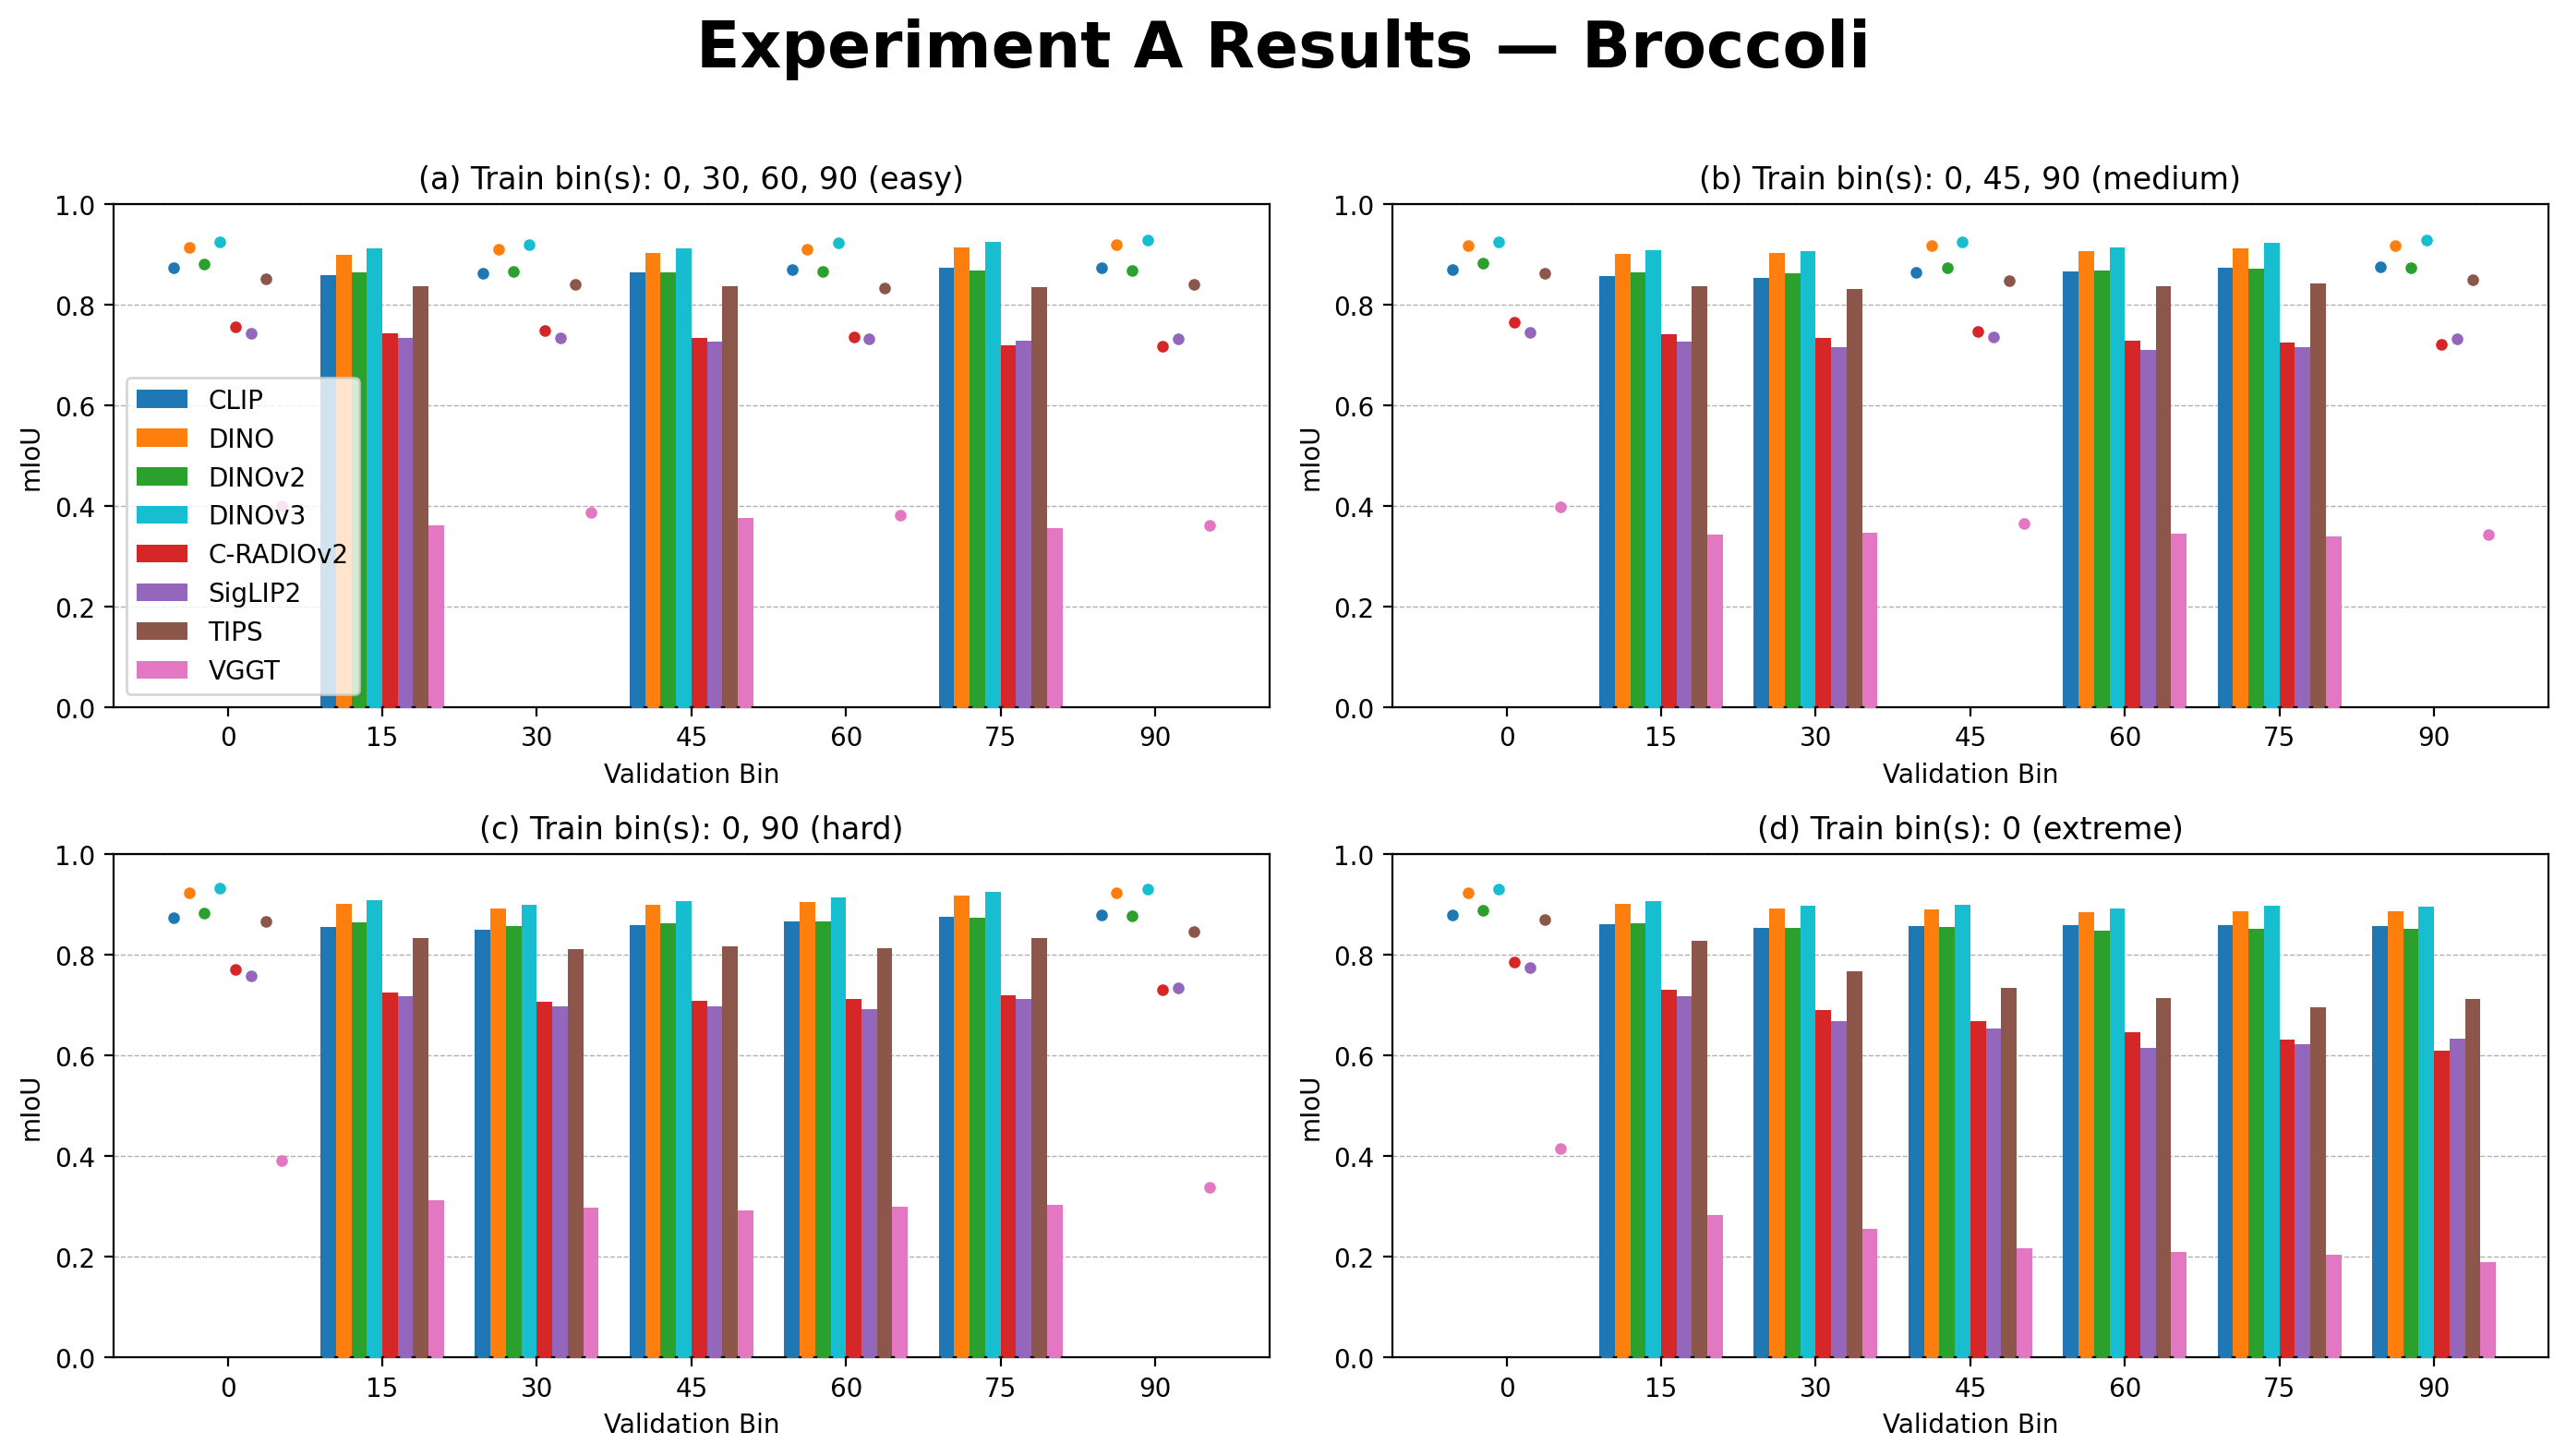

Saved figure to ../images/figures/15_durian.png


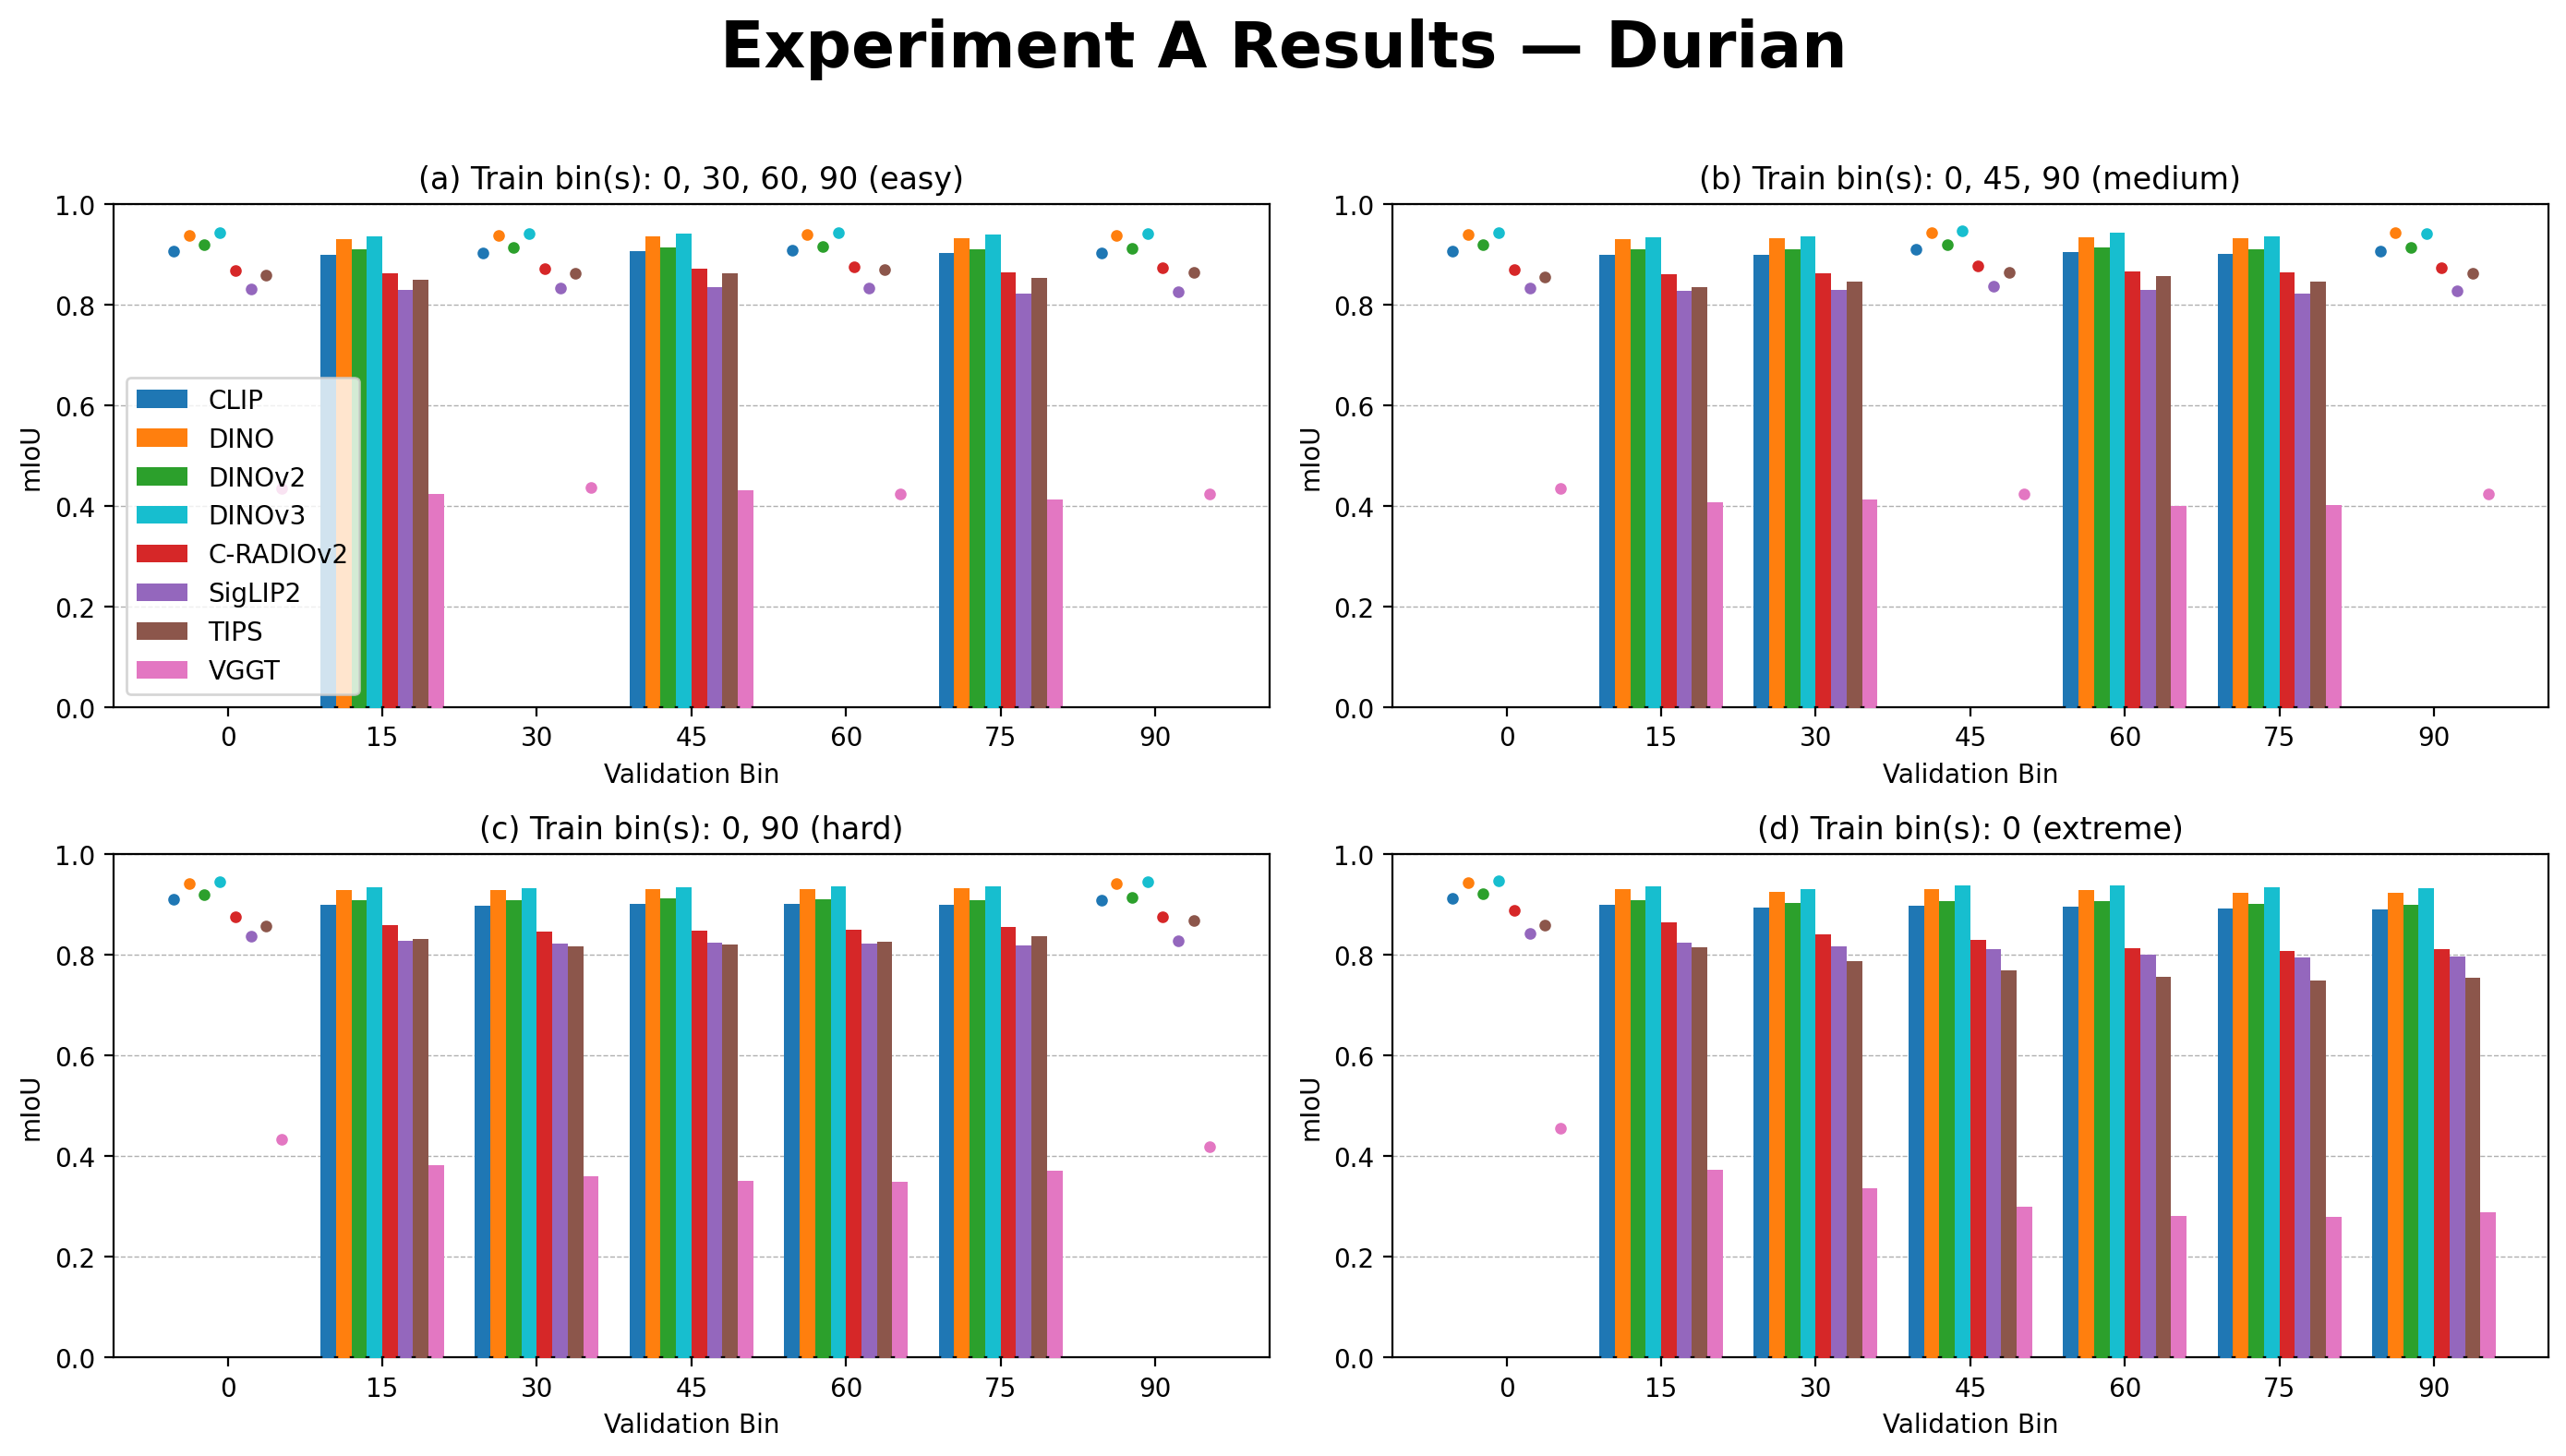

In [34]:

# Plot each class separately
for idx, (class_id, class_name) in enumerate(CLASS_TO_NAME.items()):
    save_path = f"../images/figures/{idx}_{class_name.replace(' ', '_')}.png"
    if class_id == 0:
        plot_exp_a([class_id], include_bg=True, extratitle=class_name.capitalize(), save_path=save_path)
    else:
        plot_exp_a([class_id], include_bg=False, extratitle=class_name.capitalize(), save_path=save_path)


### Comparing per class to the miou over all classes

In [36]:
DF_A = DF.copy()
# Compute baseline: mean over all classes jac0..jac15
class_cols = [f"jac{i}" for i in CLASS_TO_INDEX.values()]
DF_A["mean_all_classes"] = DF_A[class_cols].mean(axis=1)


In [37]:
rows = []

for _, row in DF_A.iterrows():

    model = row["model"]
    train_bins = row["train_bins"]
    difficulty = TRAIN_BINS_DIFFICULTY[train_bins]
    val_bin = row["val_bin"]
    all_mean = row["mean_all_classes"]

    for class_id, class_idx in CLASS_TO_INDEX.items():
        class_score = row[f"jac{class_idx}"]

        class_name = CLASS_TO_NAME[class_id]  # or CLASS_TO_NAME
        combined = f"{class_id} ({class_name})"

        rows.append({
            "model": model,
            "difficulty": difficulty,
            "train_bins": train_bins,
            "val_bin": val_bin,
            "class_id": class_id,
            "class_name": class_name,
            "class_full": combined,
            "class_mIoU": class_score,
            "all_classes_mIoU": all_mean,
            "difference": class_score - all_mean
        })

TABLE = pd.DataFrame(rows)


In [38]:
# Average difference per class (which classes underperform?)
TABLE.groupby("class_full")["difference"].mean().sort_values()

class_full
99 (coat rack)       -0.219892
100 (guitar stand)   -0.199012
46 (bed)             -0.170771
126 (sink)           -0.154606
19 (microwave)       -0.036231
70 (toy dragon)      -0.028744
113 (ceiling lamp)   -0.021919
60 (toy cow)         -0.019664
57 (toy cat)         -0.004200
8 (sofa)              0.044412
125 (toilet)          0.058157
7 (stove)             0.064318
152 (strings)         0.098948
166 (broccoli)        0.112425
196 (durian)          0.170171
0 (background)        0.306608
Name: difference, dtype: float64

In [39]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

TABLE.groupby(["model", "difficulty", "class_full"])["difference"].mean()

model                            difficulty  class_full        
C-RADIOv2-B                      easy        0 (background)        0.277929
                                             100 (guitar stand)   -0.247214
                                             113 (ceiling lamp)    0.017071
                                             125 (toilet)          0.192929
                                             126 (sink)           -0.138643
                                             152 (strings)         0.055643
                                             166 (broccoli)        0.046071
                                             19 (microwave)       -0.038500
                                             196 (durian)          0.178643
                                             46 (bed)             -0.054214
                                             57 (toy cat)         -0.032357
                                             60 (toy cow)         -0.050786
                        

In [40]:
def parse_train_bins(s):
    return set(map(int, s.split("_")))

TABLE["is_seen_bin"] = TABLE.apply(
    lambda r: r["val_bin"] in parse_train_bins(r["train_bins"]),
    axis=1
)


In [41]:
UNSEEN = TABLE[TABLE["is_seen_bin"] == False]


In [42]:
UNSEEN.groupby(["model", "difficulty", "class_full"])["difference"].mean()

model                            difficulty  class_full        
C-RADIOv2-B                      easy        0 (background)        0.293646
                                             100 (guitar stand)   -0.251354
                                             113 (ceiling lamp)    0.018979
                                             125 (toilet)          0.207313
                                             126 (sink)           -0.154354
                                             152 (strings)         0.068979
                                             166 (broccoli)        0.058979
                                             19 (microwave)       -0.044021
                                             196 (durian)          0.192646
                                             46 (bed)             -0.104021
                                             57 (toy cat)         -0.023687
                                             60 (toy cow)         -0.042687
                        

In [43]:
UNSEEN.groupby(["model", "difficulty", "class_full"])["class_mIoU"].mean()

model                            difficulty  class_full        
C-RADIOv2-B                      easy        0 (background)        0.966333
                                             100 (guitar stand)    0.421333
                                             113 (ceiling lamp)    0.691667
                                             125 (toilet)          0.880000
                                             126 (sink)            0.518333
                                             152 (strings)         0.741667
                                             166 (broccoli)        0.731667
                                             19 (microwave)        0.628667
                                             196 (durian)          0.865333
                                             46 (bed)              0.568667
                                             57 (toy cat)          0.649000
                                             60 (toy cow)          0.630000
                        

In [44]:
pd.pivot_table(
    UNSEEN,
    values="class_mIoU",
    index="difficulty",
    columns="model",
    aggfunc="mean"
)

model       C-RADIOv2-B  clip-vit-base-patch16  dino_vitb16  dinov2_vitb14  \
difficulty                                                                   
easy           0.672687               0.768208     0.794375       0.776062   
extreme        0.534208               0.717948     0.703906       0.743156   
hard           0.614738               0.749050     0.762625       0.762288   
medium         0.656844               0.762281     0.786906       0.771344   

model       dinov3-vitb16-pretrain-lvd1689m  siglip2-base-patch16-512  \
difficulty                                                              
easy                               0.818229                  0.588646   
extreme                            0.779375                  0.510417   
hard                               0.805400                  0.556800   
medium                             0.815922                  0.576484   

model       tips-b14   vggt-1b  
difficulty                      
easy        0.685271  0.234521  
extreme     0.492563  0.160531  
hard        0.611000  0.192725  
medium      0.666703  0.217047

In [45]:
pd.pivot_table(
    UNSEEN,
    values="difference",
    index="difficulty",
    columns="model",
    aggfunc="mean"
)

model        C-RADIOv2-B  clip-vit-base-patch16   dino_vitb16  dinov2_vitb14  \
difficulty                                                                     
easy        3.816392e-17           2.544261e-17  6.707597e-17  -2.081668e-17   
extreme     5.204170e-18           3.932040e-17 -7.517135e-18   2.081668e-17   
hard       -5.551115e-18           2.775558e-18 -1.387779e-17   1.665335e-17   
medium      4.683753e-17           3.209238e-17  9.194034e-17  -4.510281e-17   

model       dinov3-vitb16-pretrain-lvd1689m  siglip2-base-patch16-512  \
difficulty                                                              
easy                          -3.353799e-17              9.483155e-17   
extreme                       -7.632783e-17              1.966020e-17   
hard                          -2.081668e-18              3.400058e-17   
medium                        -9.714451e-17              3.295975e-17   

model           tips-b14       vggt-1b  
difficulty                              
easy        4.857226e-17  9.251859e-18  
extreme     3.064678e-17  2.891206e-19  
hard       -1.318390e-17 -8.673617e-18  
medium     -1.214306e-17  8.673617e-19

## Job Statistics

In [46]:
DF_JOB = DF.copy()

job_id = str(DF_JOB['job_id'].iloc[0])
model = DF_JOB['model'].iloc[0]
prefix = PREFIXES.get(model)
if prefix is None:
    raise ValueError(f"Unknown model name: {model}")

log_path = Path(f"../logs/exp_a_b/{prefix}.job_{job_id}.log")

# Read last 15 lines after JOB STATISTICS
def tail_log_after_statistics(path, num_lines=15):
    if not path.exists():
        return f"Log file not found: {path}"
    
    with open(path, 'r') as f:
        lines = f.readlines()
        try:
            start_idx = next(i for i, line in enumerate(lines) if 'JOB STATISTICS' in line)
            return ''.join(lines[start_idx:start_idx + num_lines])
        except StopIteration:
            return "JOB STATISTICS not found in log file."

# Output result
log_tail = tail_log_after_statistics(log_path)
print(log_tail)


JOB STATISTICS
Job ID: 12081378
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-07:03:04
CPU Efficiency: 11.75% of 28-00:37:12 core-walltime
Job Wall-clock time: 09:20:31
Memory Utilized: 207.41 GB
Memory Efficiency: 43.21% of 480.00 GB (480.00 GB/node)



In [47]:
# Get all unique (job_id, model) pairs
unique_jobs = DF.copy()
unique_jobs = unique_jobs[['job_id', 'model']].drop_duplicates()

# Function to extract JOB STATISTICS section
def print_job_statistics(job_id, model):
    prefix = PREFIXES.get(model)
    if not prefix:
        print(f"Skipping unknown model: {model}")
        return
    
    log_path = Path(f"../logs/exp_a_b/{prefix}.job_{job_id}.log")
    print(f"\n=== JOB STATISTICS for job_id: {job_id}, model: {model} ===")
    
    if not log_path.exists():
        print(f"Log file not found: {log_path}")
        return

    with open(log_path, 'r') as f:
        lines = f.readlines()
        try:
            start_idx = next(i for i, line in enumerate(lines) if 'JOB STATISTICS' in line)
            for line in lines[start_idx:]:
                print(line, end='')  # already includes newline
        except StopIteration:
            print("'JOB STATISTICS' section not found in log.")

# Loop and print
print(f"The following JOB STATISTICS are for memory: {MEMORY}")
for _, row in unique_jobs.iterrows():
    job_id = str(row['job_id'])
    model = row['model']
    print_job_statistics(job_id, model)


The following JOB STATISTICS are for memory: 1024000

=== JOB STATISTICS for job_id: 12081378, model: clip-vit-base-patch16 ===
JOB STATISTICS
Job ID: 12081378
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-07:03:04
CPU Efficiency: 11.75% of 28-00:37:12 core-walltime
Job Wall-clock time: 09:20:31
Memory Utilized: 207.41 GB
Memory Efficiency: 43.21% of 480.00 GB (480.00 GB/node)

=== JOB STATISTICS for job_id: 12081380, model: dino_vitb16 ===
JOB STATISTICS
Job ID: 12081380
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-07:07:59
CPU Efficiency: 11.58% of 28-11:38:24 core-walltime
Job Wall-clock time: 09:29:42
Memory Utilized: 213.23 GB
Memory Efficiency: 44.42% of 480.00 GB (480.00 GB/node)

=== JOB STATISTICS for job_id: 12081383, model: C-RADIOv2-B ===
JOB STATISTICS
Job ID: 12081383
Cluster: snellius
User/Group: scur0542/scur0542
Stat

## Table

In [48]:
df = DF.copy()

# change train_bins to a list of integers
df["train_bins"] = df["train_bins"].apply(lambda x: list(map(int, x.split("_"))))

# if val_bin is in train_bins, set val_in_trained accordingly
df["val_in_trained"] = df.apply(lambda row: row["val_bin"] in row["train_bins"], axis=1)

# set difficulty column
df["difficulty"] = df["train_bins"].apply(lambda x: TRAIN_BINS_DIFFICULTY["_".join(map(str, x))])

# filter only untrained bins
df = df[~df["val_in_trained"]].copy()

df_exp_a = pd.DataFrame(columns=["model", "easy", "medium", "hard", "extreme"])

# for each model and difficulty, calculate the mean and std of jac_mean
for model in MODELS.keys():
    model_df = df[df["model"] == model]
    model_df.loc[:, "jac_mean"] = model_df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
    model_df.loc[:, "jac_std"] = model_df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
    
    # calculate mean and std for each difficulty
    means = model_df.groupby("difficulty")["jac_mean"].mean()
    stds = model_df.groupby("difficulty")["jac_std"].mean()

    # create a row for the model
    row = {
        "model": MODELS[model],
        "easy": f"{means.get('easy', 0):.3f} ± {stds.get('easy', 0):.3f}",
        "medium": f"{means.get('medium', 0):.3f} ± {stds.get('medium', 0):.3f}",
        "hard": f"{means.get('hard', 0):.3f} ± {stds.get('hard', 0):.3f}",
        "extreme": f"{means.get('extreme', 0):.3f} ± {stds.get('extreme', 0):.3f}"
    }
    
    df_exp_a = pd.concat([df_exp_a, pd.DataFrame([row])], ignore_index=True)

df_exp_a

model           easy         medium           hard        extreme
0       CLIP  0.755 ± 0.130  0.748 ± 0.134  0.734 ± 0.140  0.701 ± 0.149
1       DINO  0.782 ± 0.132  0.774 ± 0.137  0.748 ± 0.153  0.686 ± 0.171
2     DINOv2  0.763 ± 0.136  0.758 ± 0.139  0.748 ± 0.143  0.728 ± 0.154
3     DINOv3  0.807 ± 0.153  0.805 ± 0.146  0.794 ± 0.161  0.766 ± 0.191
4  C-RADIOv2  0.653 ± 0.129  0.636 ± 0.132  0.592 ± 0.141  0.506 ± 0.150
5    SigLIP2  0.564 ± 0.150  0.551 ± 0.153  0.530 ± 0.157  0.481 ± 0.152
6       TIPS  0.667 ± 0.137  0.647 ± 0.146  0.588 ± 0.162  0.462 ± 0.169
7       VGGT  0.190 ± 0.132  0.172 ± 0.119  0.146 ± 0.102  0.112 ± 0.083

In [49]:
# give latex table
latex_table = df_exp_a.to_latex(index=False, escape=False, column_format='lcccc', 
                                  header=["Model", "Easy", "Medium", "Hard", "Extreme"])
print(latex_table)

\begin{tabular}{lcccc}
\toprule
Model & Easy & Medium & Hard & Extreme \\
\midrule
CLIP & 0.755 ± 0.130 & 0.748 ± 0.134 & 0.734 ± 0.140 & 0.701 ± 0.149 \\
DINO & 0.782 ± 0.132 & 0.774 ± 0.137 & 0.748 ± 0.153 & 0.686 ± 0.171 \\
DINOv2 & 0.763 ± 0.136 & 0.758 ± 0.139 & 0.748 ± 0.143 & 0.728 ± 0.154 \\
DINOv3 & 0.807 ± 0.153 & 0.805 ± 0.146 & 0.794 ± 0.161 & 0.766 ± 0.191 \\
C-RADIOv2 & 0.653 ± 0.129 & 0.636 ± 0.132 & 0.592 ± 0.141 & 0.506 ± 0.150 \\
SigLIP2 & 0.564 ± 0.150 & 0.551 ± 0.153 & 0.530 ± 0.157 & 0.481 ± 0.152 \\
TIPS & 0.667 ± 0.137 & 0.647 ± 0.146 & 0.588 ± 0.162 & 0.462 ± 0.169 \\
VGGT & 0.190 ± 0.132 & 0.172 ± 0.119 & 0.146 ± 0.102 & 0.112 ± 0.083 \\
\bottomrule
\end{tabular}



# Experiment B

In [58]:
DF_B = DF.copy()
df_extreme = DF_B[DF_B["train_bins"] == "0"].copy() # extreme difficulty
df_extreme.head(10)

job_id                  model train_bins  val_bin  jac_mean  jac_std  \
98   12081378  clip-vit-base-patch16          0        0     0.824    0.090   
99   12081378  clip-vit-base-patch16          0       15     0.755    0.139   
100  12081378  clip-vit-base-patch16          0       30     0.733    0.150   
101  12081378  clip-vit-base-patch16          0       45     0.714    0.155   
102  12081378  clip-vit-base-patch16          0       60     0.704    0.157   
103  12081378  clip-vit-base-patch16          0       75     0.700    0.160   
104  12081378  clip-vit-base-patch16          0       90     0.702    0.160   
112  12081380            dino_vitb16          0        0     0.876    0.075   
113  12081380            dino_vitb16          0       15     0.783    0.143   
114  12081380            dino_vitb16          0       30     0.734    0.171   

      jac0   jac1   jac2   jac3   jac4   jac5   jac6   jac7   jac8   jac9  \
98   0.976  0.879  0.888  0.841  0.747  0.833  0.809  0.772  0.631  0.647   
99   0.970  0.837  0.836  0.735  0.524  0.792  0.766  0.730  0.510  0.550   
100  0.969  0.827  0.819  0.695  0.487  0.755  0.738  0.720  0.490  0.526   
101  0.969  0.811  0.779  0.666  0.443  0.714  0.704  0.710  0.494  0.514   
102  0.969  0.796  0.770  0.653  0.452  0.684  0.669  0.705  0.417  0.522   
103  0.969  0.792  0.782  0.652  0.445  0.669  0.631  0.683  0.402  0.534   
104  0.969  0.787  0.785  0.660  0.438  0.673  0.642  0.675  0.432  0.550   
112  0.984  0.914  0.936  0.897  0.828  0.884  0.862  0.826  0.723  0.700   
113  0.977  0.862  0.865  0.752  0.552  0.842  0.815  0.775  0.559  0.559   
114  0.974  0.814  0.816  0.658  0.417  0.803  0.783  0.761  0.497  0.489   

     jac10  jac11  jac12  jac13  jac14  jac15  d_model  batch_size  \
98   0.817  0.883  0.773  0.893  0.880  0.912      768           4   
99   0.746  0.863  0.574  0.884  0.861  0.899      768           4   
100  0.697  0.855  0.526  0.880  0.854  0.894      768           4   
101  0.674  0.841  0.499  0.859  0.857  0.898      768           4   
102  0.665  0.835  0.528  0.838  0.859  0.895      768           4   
103  0.667  0.838  0.535  0.845  0.860  0.892      768           4   
104  0.677  0.847  0.486  0.860  0.858  0.890      768           4   
112  0.867  0.930  0.863  0.929  0.924  0.944      768           4   
113  0.767  0.901  0.558  0.908  0.902  0.931      768           4   
114  0.715  0.851  0.468  0.880  0.893  0.926      768           4   

     input_size  patch_size  
98          512          16  
99          512          16  
100         512          16  
101         512          16  
102         512          16  
103         512          16  
104         512          16  
112         512          16  
113         512          16  
114         512          16

In [59]:
def plot_exp_b(normalize=False, save_path: str | None = None):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    if normalize:
        # plt.scatter(0, 1, color="black", marker="x", zorder=5, label="Baseline performance")
        plt.scatter(0, 1, color="black", marker="x", zorder=5, label="Baseline")
        plot_title = "Experiment B results (normalized to 0-bin performance)"
        y_label = "Normalized mIoU"
    else:
        plot_title = "Experiment B results"
        y_label = "mIoU"

    for model in MODELS.keys():
        df = df_extreme[df_extreme["model"] == model].copy()
        df["jac_mean"] = df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
        df["jac_std"] = df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)

        if not normalize:
            # plot the 0-bin performance
            df0 = df[df["val_bin"] == 0]
            x_values = df0["val_bin"]
            y_values = df0["jac_mean"]
            plt.scatter(x_values, y_values, color=COLORS[model], marker="x", s=100, zorder=5)

        # plot the other validation bins [15, ..., 90]
        if normalize:
            # get bin=0 performance
            df0 = df[df["val_bin"] == 0]
            model_0_score = df0["jac_mean"].values[0]

            df1590 = df[df["val_bin"] != 0].copy()
            df1590["jac_norm"] = df1590["jac_mean"] / model_0_score
            x_values = df1590["val_bin"]
            y_values = df1590["jac_norm"]
        else:
            df1590 = df[df["val_bin"] != 0]
            x_values = df1590["val_bin"]
            y_values = df1590["jac_mean"].values

        plt.plot(x_values, y_values, label=MODELS[model], color=COLORS[model])

    plt.xlabel("Bin")
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.xticks(XTICKS)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.ylim(0, 1.1)
    plt.tight_layout()


    # Save figure
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    plt.show()


## Plots

Saved figure to ../images/expb_norm.png


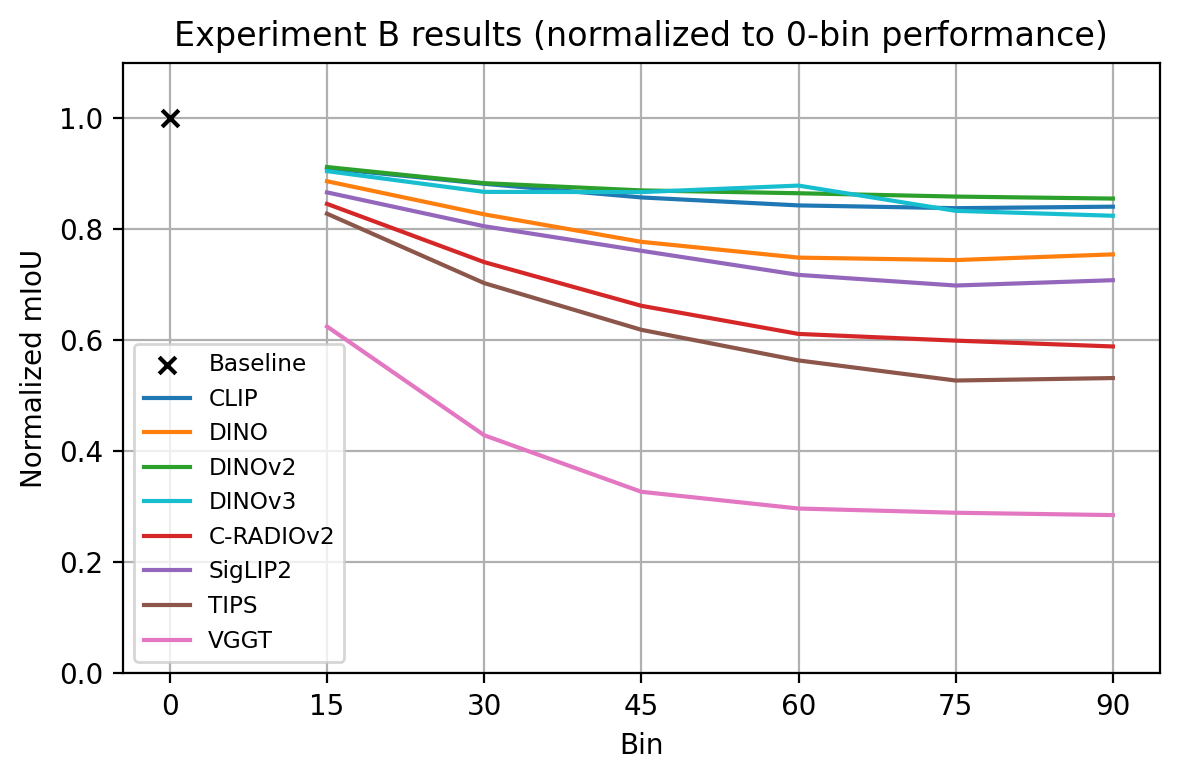

Saved figure to ../images/expb_raw.png


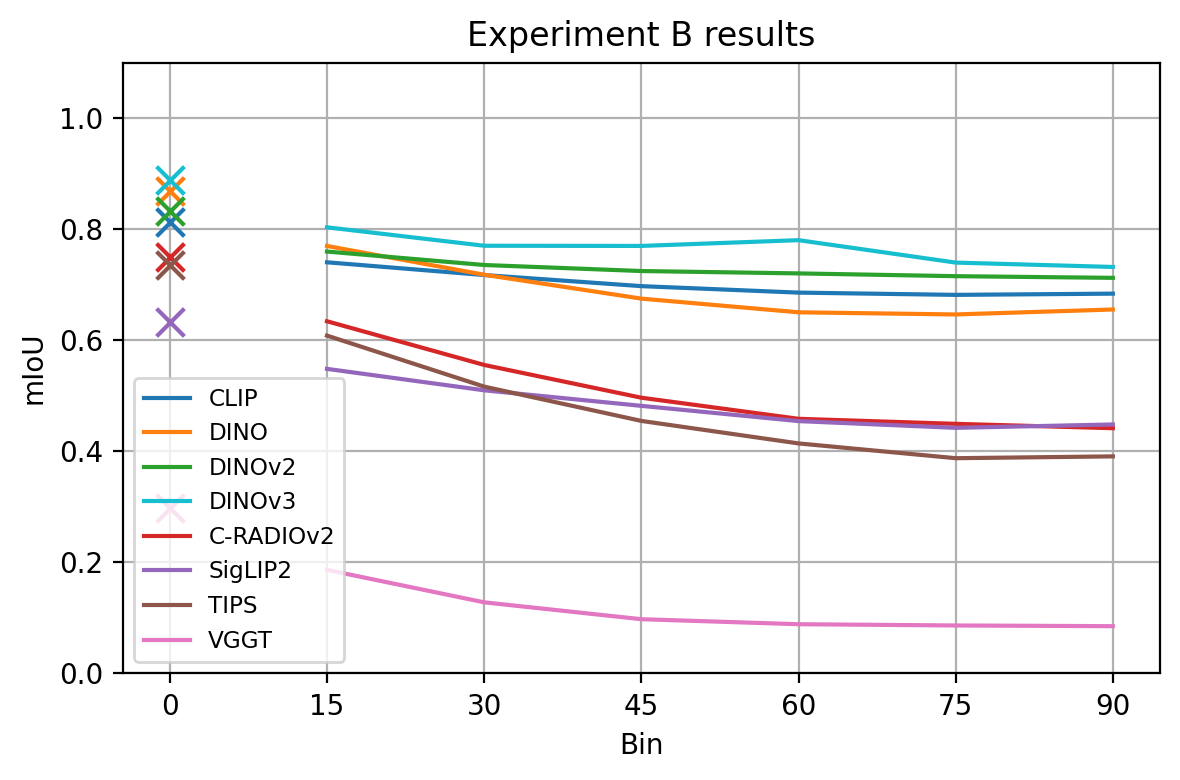

In [60]:
plot_exp_b(normalize=True, save_path="../images/expb_norm.png")
plot_exp_b(normalize=False, save_path="../images/expb_raw.png")

## Table

In [53]:
assert DF.equals(ORIGINAL_DF), "DataFrame DF has been modified!"

In [54]:
# DF.loc[:, "jac_mean"] = DF[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
# DF.loc[:, "jac_std"] = DF[[f"jac{i}" for i in range(1, 16)]].std(axis=1)

DF_BREAK = ORIGINAL_DF.copy()  # safe copy for experiment B
assert DF_BREAK.equals(ORIGINAL_DF), "DataFrame DF has been modified!"
df_extreme = DF_BREAK[DF_BREAK["train_bins"] == "0"].copy() # extreme difficulty

# Compute jac_mean for each row: raw mIoU per sample.
DF_BREAK.loc[:, "jac_mean"] = DF_BREAK[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
DF_BREAK.loc[:, "jac_std"] = DF_BREAK[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
final_df = None
threshold = 0.05

for model in MODELS.keys():
    df = df_extreme[df_extreme["model"] == model].copy()
    # df = DF_BREAK[DF_BREAK["model"] == model].copy()

    # get bin=0 performance
    df0 = df[df["val_bin"] == 0]
    model_0_score = df0["jac_mean"].values[0]

    # Divide the jac_mean by the 0-bin performance (model_0_score) to get 
    # normalized jac_mean (jac_norm). This means we are using normalized mIoU, 
    # relative to the 0° bin baseline.
    df["jac_norm"] = df["jac_mean"] / model_0_score

    # jac_mean_prev is jac_mean but shifted down by one row
    df["jac_norm_prev"] = df["jac_norm"].shift(1)

    # Compute delta from jac_norm: Delta is difference between jac norm and shifted jac norm
    # In this way the deltas (drops) are in normalized space.
    # Conclusion: we are currently using normalized mIoU drops to detect breaking points.
    df["delta"] = df["jac_norm"] - df["jac_norm_prev"]
    df = df[df["val_bin"] != 0]

    # concat
    if final_df is None:
        final_df = df.copy()
    else:
        final_df = pd.concat([final_df, df], ignore_index=True)

final_df

# To find a breaking point: check the last column called delta, compare the delta with the threshold
# The first delta exceeding the treshold is the breaking point


job_id                            model train_bins  val_bin  jac_mean  \
0   12081378            clip-vit-base-patch16          0       15     0.755   
1   12081378            clip-vit-base-patch16          0       30     0.733   
2   12081378            clip-vit-base-patch16          0       45     0.714   
3   12081378            clip-vit-base-patch16          0       60     0.704   
4   12081378            clip-vit-base-patch16          0       75     0.700   
5   12081378            clip-vit-base-patch16          0       90     0.702   
6   12081380                      dino_vitb16          0       15     0.783   
7   12081380                      dino_vitb16          0       30     0.734   
8   12081380                      dino_vitb16          0       45     0.694   
9   12081380                      dino_vitb16          0       60     0.670   
10  12081380                      dino_vitb16          0       75     0.667   
11  12081380                      dino_vitb16          0       90     0.675   
12  12081381                    dinov2_vitb14          0       15     0.773   
13  12081381                    dinov2_vitb14          0       30     0.750   
14  12081381                    dinov2_vitb14          0       45     0.740   
15  12081381                    dinov2_vitb14          0       60     0.736   
16  12081381                    dinov2_vitb14          0       75     0.731   
17  12081381                    dinov2_vitb14          0       90     0.728   
18  15830075  dinov3-vitb16-pretrain-lvd1689m          0       15     0.815   
19  15830075  dinov3-vitb16-pretrain-lvd1689m          0       30     0.783   
20  15830075  dinov3-vitb16-pretrain-lvd1689m          0       45     0.783   
21  15830075  dinov3-vitb16-pretrain-lvd1689m          0       60     0.793   
22  15830075  dinov3-vitb16-pretrain-lvd1689m          0       75     0.755   
23  15830075  dinov3-vitb16-pretrain-lvd1689m          0       90     0.747   
24  12081383                      C-RADIOv2-B          0       15     0.655   
25  12081383                      C-RADIOv2-B          0       30     0.581   
26  12081383                      C-RADIOv2-B          0       45     0.525   
27  12081383                      C-RADIOv2-B          0       60     0.490   
28  12081383                      C-RADIOv2-B          0       75     0.481   
29  12081383                      C-RADIOv2-B          0       90     0.474   
30  12081385         siglip2-base-patch16-512          0       15     0.574   
31  12081385         siglip2-base-patch16-512          0       30     0.538   
32  12081385         siglip2-base-patch16-512          0       45     0.511   
33  12081385         siglip2-base-patch16-512          0       60     0.486   
34  12081385         siglip2-base-patch16-512          0       75     0.474   
35  12081385         siglip2-base-patch16-512          0       90     0.480   
36  12081386                         tips-b14          0       15     0.630   
37  12081386                         tips-b14          0       30     0.544   
38  12081386                         tips-b14          0       45     0.486   
39  12081386                         tips-b14          0       60     0.447   
40  12081386                         tips-b14          0       75     0.422   
41  12081386                         tips-b14          0       90     0.426   
42  15926053                          vggt-1b          0       15     0.231   
43  15926053                          vggt-1b          0       30     0.176   
44  15926053                          vggt-1b          0       45     0.147   
45  15926053                          vggt-1b          0       60     0.138   
46  15926053                          vggt-1b          0       75     0.136   
47  15926053                          vggt-1b          0       90     0.135   

    jac_std   jac0   jac1   jac2   jac3   jac4   jac5   jac6   jac7   jac8  \
0     0.139  0.970  0.837  0.836  0.735  0.524  0.792  0